In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth

import timeit
import ODE_utils as odeu
from scipy import optimize
import tables
from scipy.integrate import cumtrapz as trapint
#from mpmath import *
#!jt -t onedork -cellw 100%

### Evolution Code

In [2]:
###Initial Values###

M0=1.0   ###inital mass
Q=0.95   ###charge
Lambda=0.000   ###cosmological constant
scalarfield=True   ###whether scalar field is applied at u=0 boundary
A=.01   ###amplitude of scalar field
vscalarfield=False   ###legacy, will eventually control whether scalar field is applied along v=0


In [3]:
N=25  ###Resolution in v-direction
Tol=10**(-3)#/N  ###Determines the error tolerance above which the code will reduce the step size
Nul=20*N   ### Base Resolution in u-direction
scal=50  ###extra scaling on the u=0 boundary to reduce error from boundary condtions there
uscal=100   ###how often results are printed/saved to file (saved every uscal points)
umax=17  ###max value of u that the code will go to
vmax=40# 150 ###max value of v that the code will go to
extraterms=True ###saves the derivatives of r,sig,phi to hard drive if True
rcosmtol=.00000001 ###how close the code will let r get to rcosm if u=0 initial conditions include cosmological horizon

datatype=np.float64   ###legacy, previous versions used decimal 

ru0=2.0  ###initial value of r at (u=0,v=0)

dr0v=.1   ###the value of dr/dr at (u=0,v=0), not choosable for eddington coordinates

vbdytype="edd"   ###coordinate choice in v-direction (can choose "stan" standard, "edd" eddington)
ubdytype="stan"   ###coordinate choice in v-direction (can choose "stan" standard, "edd" eddington, "adapt" adaptive gauge) 

if vbdytype=="edd":
    dr0v=0.5*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda/3*ru0**2.0)  ###forces dr0v to be a certain value for eddington coordinates
    
print(dr0v)


print("Max error is: "+str(Tol*umax))

0.1128125
Max error is: 0.017


In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    dv0=1/N    
else:
    dv0=M0/N
    


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda>0 or Lambda<0:
    sol = optimize.root(fr,[0.687,1.3,500.0],args=(M0,Q,Lambda), method='hybr')
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
else:
    rplus=M0+(M0**2-Q**2)**(.5)
    rminus=M0-(M0**2-Q**2)**(.5)
    rcosm=0.0
    

wHD=True 

print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

print("Max r along u=0: "+str(ru0+vmax*dr0v))
###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax#int(umax/du0)
Nv=int(vmax/dv0)


r+: 1.31224989991992
r-: 0.6877501000800801
rc: 0.0
Max r along u=0: 6.5125


In [5]:
print((rplus-rminus)/(2*rminus)*rcosm/rminus)

0.0


In [6]:
##################################
###Applying Boundary Conditions###

rnpf=np.zeros((2,Nv),dtype=datatype)
signpf=np.zeros((2,Nv),dtype=datatype)
phinpf=np.zeros((2,Nv),dtype=datatype)
drnpvf=np.zeros((2,Nv),dtype=datatype)
dsignpvf=np.zeros((2,Nv),dtype=datatype)
dphinpvf=np.zeros((2,Nv),dtype=datatype)
drnpuf=np.zeros((2,Nv),dtype=datatype)
dsignpuf=np.zeros((2,Nv),dtype=datatype)
dphinpuf=np.zeros((2,Nv),dtype=datatype)
massnpf=np.full((2,Nv),M0)#np.zeros((2,Nv))
#drunpv=np.full((1,Nv-1),-1/(4*dr0v)*(1-2*M0/ru0+Q**2/ru0**2))

rnpf[0], signpf[0], phinpf[0] , drnpvf[0], dsignpvf[0], dphinpvf[0], drnpuf[0], dsignpuf[0], dphinpuf[0] , massnpf[0]= odeu.boundaryv(scal,ubdytype,vbdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,Lambda,scalarfield,A,rcosmtol,datatype)


mask=~np.isnan(rnpf[0])
print(Nv)
rnpf=rnpf[:,mask]

Nv=int(len(rnpf[0]))
rnpf=rnpf.reshape(2,Nv)
signpf=signpf[:,mask]#.reshape(2,Nv)
phinpf=phinpf[:,mask]#.reshape(2,Nv)
dphinpuf=dphinpuf[:,mask]#.reshape(2,Nv)  
dphinpvf=dphinpvf[:,mask]#.reshape(2,Nv)
dsignpuf=dsignpuf[:,mask]#.reshape(2,Nv)
dsignpvf=dsignpvf[:,mask]#.reshape(2,Nv)
drnpuf=drnpuf[:,mask]#.reshape(2,Nv)
drnpvf=drnpvf[:,mask]#.reshape(2,Nv)
massnpf=massnpf[:,mask]#.reshape(2,Nv)
print(Nv)
#print(massnpf)

dr/dv is 0.1128125
1000
1000


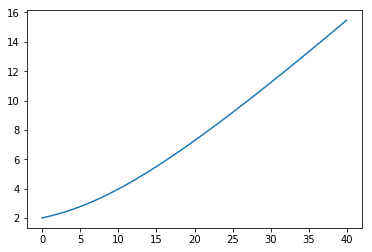

1.000513699292307 inf
-0.1128125
0.1128125


In [7]:
vmax=(Nv)*dv0

vrange=np.arange(0,vmax-.00000001*vmax,dv0)#*rnpf[0])/rnpf[0]

    
plt.plot(vrange,rnpf[0])
#plt.plot(dphinpvf[0])
#plt.plot(dphinpuf[0])
Mc=np.nanmax(massnpf[0])
rcosm=odeu.rc(Mc,Q,Lambda)
plt.plot([0,vmax],[rcosm,rcosm],linestyle='--',color='green')
plt.show()



#print(vrange)
print(Mc,rcosm)
print(drnpuf[0,0])

print(drnpvf[0,0])

In [8]:
drunptemp=np.empty((Nv))*np.nan

###Applying Propagation Algorithm###

urange=np.array([0.0],dtype=datatype)



i=0
icount=0
dv=dv0
if M0>0:
    du0=M0/Nul
    #du0=M0/N
elif M0==0:
    du0=1/Nul
    #du0=1/N
du=du0

    
atom = tables.Float64Atom()

rnpfile = tables.open_file('rnp.h5', mode='w',encoding="utf8") 
rnp = rnpfile.create_earray(rnpfile.root, 'data', atom, (0, Nv))
signpfile = tables.open_file('signp.h5', mode='w',encoding="utf8") 
signp = signpfile.create_earray(signpfile.root, 'data', atom, (0, Nv))
phinpfile = tables.open_file('phinp.h5', mode='w',encoding="utf8") 
phinp = phinpfile.create_earray(phinpfile.root, 'data', atom, (0, Nv))
massnpfile = tables.open_file('massnp.h5', mode='w',encoding="utf8") 
massnp = massnpfile.create_earray(massnpfile.root, 'data', atom, (0, Nv))

if extraterms==True:
    drnpufile = tables.open_file('drnpu.h5', mode='w',encoding="utf8") 
    drnpu = drnpufile.create_earray(drnpufile.root, 'data', atom, (0, Nv))
    drnpvfile = tables.open_file('drnpv.h5', mode='w',encoding="utf8") 
    drnpv = drnpvfile.create_earray(drnpvfile.root, 'data', atom, (0, Nv))
    dsignpufile = tables.open_file('dsignpu.h5', mode='w',encoding="utf8") 
    dsignpu = dsignpufile.create_earray(dsignpufile.root, 'data', atom, (0, Nv))
    dsignpvfile = tables.open_file('dsignpv.h5', mode='w',encoding="utf8") 
    dsignpv = dsignpvfile.create_earray(dsignpvfile.root, 'data', atom, (0, Nv))
    dphinpufile = tables.open_file('dphinpu.h5', mode='w',encoding="utf8") 
    dphinpu = dphinpufile.create_earray(dphinpufile.root, 'data', atom, (0, Nv))
    dphinpvfile = tables.open_file('dphinpv.h5', mode='w',encoding="utf8") 
    dphinpv = dphinpvfile.create_earray(dphinpvfile.root, 'data', atom, (0, Nv))
    
rnp.append(rnpf[0].reshape(1,Nv))
signp.append(signpf[0].reshape(1,Nv))
phinp.append(phinpf[0].reshape(1,Nv))
massnp.append(massnpf[0].reshape(1,Nv))

if extraterms==True:
    drnpu.append(drnpuf[0].reshape(1,Nv))
    drnpv.append(drnpvf[0].reshape(1,Nv))
    dsignpu.append(dsignpuf[0].reshape(1,Nv))
    dsignpv.append(dsignpvf[0].reshape(1,Nv))
    dphinpu.append(dphinpuf[0].reshape(1,Nv))
    dphinpv.append(dphinpvf[0].reshape(1,Nv))
    
drunptemp=np.nanmax(np.abs(drnpuf[0]))     
dsigunpvalue=np.nanmax(np.abs(dsignpuf[0]))
dphiutemp=np.nanmax(np.abs(dphinpuf[0]))
druunptemp=np.nanmax(np.abs(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])))

i=0
TempTol=1 
TempTolv=1
Eres=False
if ubdytype=='adapt':
    maxsig1=signpf[0][0]-np.nanmax(signpf[0])
    maxsig2=signpf[0][0]-np.nanmax(signpf[0])
    maxsig3=signpf[0][0]-np.nanmax(signpf[0])
    print(maxsig1,maxsig2,maxsig3)
   
du=du0

drnpuf2=np.empty(Nv)
rnpf2=np.empty(Nv)

while max(urange)<umax and i<2000000 and du>0.0: #and rnpf[1][0]>0.0 :


    du = np.min([du,1/(1*Nul)])
    
    ###############
    ###Predictor###
    ###############
    drnpvf[1] = drnpvf[0]+du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    dsignpvf[1] = dsignpvf[0]+du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf[1] = dphinpvf[0]+du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    #drnpuf[1] = drnpuf[0]+du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    #rnpf[1] = rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    drnpuf[1][0] = drnpuf[0][0]+du*odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])
    rnpf[1][0] = rnpf[0][0]+0.5*du*(drnpuf[0][0]+drnpuf[1][0])
    rnpf[1] = rnpf[1][0]+dv*trapint(drnpvf[1],initial=0)
    
    if ubdytype=='adapt':
        #nextsig=(maxsig1*3.0-maxsig2*3.0+maxsig3*1.0)
        #dsignpuf[1][0]=-np.nanmax(np.abs(dsignpuf[0]))/Nul
        dsignpuf[1][0] = -(signpf[1][-1]-np.log(drnpvf[1][-1])+3/2*np.log(2))
    elif ubdytype=='edd':
        #dsignpuf[1][0]=(np.log(abs(1-2*M0/rnpf[1][0]+Q**2.0/rnpf[1][0]-Lambda*rnpf[1][0]**2.0/3))-signpf[0][0])/du
        dsignpuf[1][0] = 2*(3*Q**2-3*M0*rnpf[1][0]+rnpf[1][0]**4*Lambda)/(rnpf[1][0]*(-3*Q**2+rnpf[1][0]*(6*M0-3*rnpf[1][0]+rnpf[1][0]**3*Lambda)))*drnpuf[1][0]
    
    elif ubdytype=='stan':
        dsignpuf[1][0] = 0.0
    
    signpf[1] = signpf[0]+du*dsignpuf[0]
    phinpf[1] = phinpf[0]+du*dphinpuf[0]
    
    drnpuf[1][0] = -1/(4*drnpvf[1][0])*np.exp(signpf[1][0])*(1-2*M0/rnpf[1][0]+Q**2/rnpf[1][0]**2-Lambda*rnpf[1][0]**2/3)
    #drnpuf[1][0] = drnpuf[0][0]+du*odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])
    drnpuf[1] = 1/rnpf[1]*(rnpf[1][0]*drnpuf[1][0]+dv*trapint(-np.exp(signpf[1])/(4)*(1-Q**2/rnpf[1]**2-Lambda*rnpf[1]**2),initial=0))
    
    
    dphinpuf[1] = 1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-dv*trapint(drnpuf[1]*dphinpvf[1],initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1] = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
 
    ###Coarse Grid (to estimate error)###
    drnpvf2 = drnpvf[0]+2*du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    dsignpvf2 = dsignpvf[0]+2*du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf2 = dphinpvf[0]+2*du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    
    drnpuf2[0] = drnpuf[0][0]+2*du*odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])
    rnpf2[0] = rnpf[0][0]+du*(drnpuf[0][0]+drnpuf2[0])
    rnpf2 = rnpf2[0]+dv*trapint(drnpvf2,initial=0)
    #drnpuf2 = drnpuf[0]+2*du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    #rnpf2 = rnpf[0]+du*(drnpuf[0]+drnpuf2)
    signpf2 = signpf[0]+2*du*dsignpuf[0]
    phinpf2 = phinpf[0]+2*du*dphinpuf[0]
    
    drnpuf2[0] = -1/(4*drnpvf2[0])*np.exp(signpf2[0])*(1-2*M0/rnpf2[0]+Q**2/rnpf2[0]**2-Lambda*rnpf2[0]**2/3)
    #drnpuf[1][0] = drnpuf[0][0]+du*odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])
    drnpuf2 = 1/rnpf2*(rnpf2[0]*drnpuf2[0]+dv*trapint(-np.exp(signpf2)/(4)*(1-Q**2/rnpf2**2-Lambda*rnpf2**2),initial=0))
    
    dphinpuf2 = 1/(rnpf2)*(rnpf2[0]*0.0-dv*trapint(drnpuf2*dphinpvf2,initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q)
    dsignpuf2 = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    ###
    
    drnpvf2 = drnpvf[0]+du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf2,drnpuf2,rnpf2,signpf2,Q,Lambda))
    dsignpvf2 = dsignpvf[0]+du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q))
    dphinpvf2 = dphinpvf[0]+du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2))
    drnpuf2 = drnpuf[0]+du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf2,dsignpuf2,dphinpuf2,rnpf2))
    
    drnpuf2[0] = drnpuf[0][0]+du*(odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])+odeu.Coneq(drnpuf2[0],dsignpuf2[0],dphinpuf2[0],rnpf2[0]))
    rnpf2[0] = rnpf[0][0]+du*(drnpuf[0][0]+drnpuf2[0])
    rnpf2 = rnpf2[0]+dv*trapint(drnpvf2,initial=0)
    
    signpf2 = signpf[0]+du*(dsignpuf[0]+dsignpuf2)
    phinpf2 = phinpf[0]+du*(dphinpuf[0]+dphinpuf2)
    
    drnpuf2[0] = -1/(4*drnpvf2[0])*np.exp(signpf2[0])*(1-2*M0/rnpf2[0]+Q**2/rnpf2[0]**2-Lambda*rnpf2[0]**2/3)
    #drnpuf[1][0] = drnpuf[0][0]+du*odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])
    drnpuf2 = 1/rnpf2*(rnpf2[0]*drnpuf2[0]+dv*trapint(-np.exp(signpf2)/(4)*(1-Q**2/rnpf2**2-Lambda*rnpf2**2),initial=0))
    
    dphinpuf2 = 1/(rnpf2)*(rnpf2[0]*0.0-dv*trapint(drnpuf2*dphinpvf2,initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf2,drnpuf2,dphinpuf2,dphinpvf2,rnpf2,signpf2,Q)
    dsignpuf2 = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    ###
    
    ################
    ###Corrector###
    ################
    drnpvf[1] = drnpvf[0]+1/2*du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))
    dsignpvf[1] = dsignpvf[0]+1/2*du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q))
    dphinpvf[1] = dphinpvf[0]+1/2*du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1]))
    #drnpuf[1] = drnpuf[0]+1/2*du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf[1],dsignpuf[1],dphinpuf[1],rnpf[1]))
    
    #rnpf[1] = rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    rnpf[1][0] = rnpf[0][0]+0.5*du*(drnpuf[0][0]+drnpuf[1][0])
    rnpf[1] = rnpf[1][0]+dv*trapint(drnpvf[1],initial=0)
    signpf[1] = signpf[0]+1/2*du*(dsignpuf[0]+dsignpuf[1])
    phinpf[1] = phinpf[0]+1/2*du*(dphinpuf[0]+dphinpuf[1])
    
    signpf[1] = signpf[0]+1/2*du*(dsignpuf[0]+dsignpuf[1])
    phinpf[1] = phinpf[0]+1/2*du*(dphinpuf[0]+dphinpuf[1])
    
    if ubdytype=='edd':
        #dsignpuf[1][0]=(np.log(abs(1-2*M0/rnpf[1][0]+Q**2.0/rnpf[1][0]-Lambda*rnpf[1][0]**2.0/3))-signpf[0][0])/du
        dsignpuf[1][0] = 2*(3*Q**2-3*M0*rnpf[1][0]+rnpf[1][0]**4*Lambda)/(rnpf[1][0]*(-3*Q**2+rnpf[1][0]*(6*M0-3*rnpf[1][0]+rnpf[1][0]**3*Lambda)))*drnpuf[1][0]
    
    drnpuf[1][0] = -1/(4*drnpvf[1][0])*np.exp(signpf[1][0])*(1-2*M0/rnpf[1][0]+Q**2/rnpf[1][0]**2-Lambda*rnpf[1][0]**2/3)
    #drnpuf[0][0]+0.5*du*(odeu.Coneq(drnpuf[0][0],dsignpuf[0][0],dphinpuf[0][0],rnpf[0][0])+odeu.Coneq(drnpuf[1][0],dsignpuf[1][0],dphinpuf[1][0],rnpf[1][0]))
    drnpuf[1] = 1/rnpf[1]*(rnpf[1][0]*drnpuf[1][0]+dv*trapint(-np.exp(signpf[1])/(4)*(1-Q**2/rnpf[1]**2-Lambda*rnpf[1]**2),initial=0))
    
    
    dphinpuf[1] = 1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-dv*trapint(drnpuf[1]*dphinpvf[1],initial=0))
    Sigfuncnp = odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1] = dsignpuf[1][0]+dv*trapint(Sigfuncnp,initial=0)
    
    massnpf[1] = (1+4.0*np.exp(-signpf[1])*drnpuf[1]*drnpvf[1])*rnpf[1]/2.0+np.power(Q,2.0)/(2.0*rnpf[1])-Lambda*np.power(rnpf[1],3.0)/6.0
    #####
    diff1=np.nanmax(np.abs((drnpuf[1]-drnpuf2)))#*4/3*(du)**(-1)))
    diff2=0.0#np.nanmax(np.abs((dsignpuf[1]-dsignpuf2)))#*4/3*(du)**(-1)))
    diff3=np.nanmax(np.abs((dphinpuf[1]-dphinpuf2)))#*4/3*(du)**(-1)))
    diff4=np.nanmax(np.abs((rnpf[1]-rnpf2)))#*4/3*(du)**(-1)))
    diff5=np.nanmax(np.abs((signpf[1]-signpf2)))#*4/3*(du)**(-1)))
    diff6=np.nanmax(np.abs((phinpf[1]-phinpf2)))#*4/3*(du)**(-1)))
    diff7=np.nanmax(np.abs((drnpvf[1]-drnpvf2)))#*4/3*(du)**(-1)))
    diff8=np.nanmax(np.abs((dsignpvf[1]-dsignpvf2)))#*4/3*(du)**(-1)))
    diff9=np.nanmax(np.abs((dphinpvf[1]-dphinpvf2)))#*4/3*(du)**(-1)))
    
    
    #print(diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9)
    diff=np.nanmax([diff1,diff2,diff3,diff4,diff5,diff6,diff7])
    #print(du,diff)
    ###
    
    

    if icount==uscal and diff< Tol:
        urange=np.append(urange,urange[i]+du)
        rnp.append(rnpf[1].reshape(1,Nv))
        signp.append(signpf[1].reshape(1,Nv))
        phinp.append(phinpf[1].reshape(1,Nv))
        massnp.append(massnpf[1].reshape(1,Nv))
        if extraterms==True:
            drnpu.append(drnpuf[1].reshape(1,Nv))
            drnpv.append(drnpvf[1].reshape(1,Nv))
            dsignpu.append(dsignpuf[1].reshape(1,Nv))
            dsignpv.append(dsignpvf[1].reshape(1,Nv))
            dphinpu.append(dphinpuf[1].reshape(1,Nv))
            dphinpv.append(dphinpvf[1].reshape(1,Nv))
        icount=0

        print("%.24f" % urange[i])
        #print("%.24f" % du)
        print(du)
        print(drnpuf[1][-1],dsignpuf[1][-1],dphinpuf[1][-1])
        #print(dsignpuf[1][-1])
        print(drnpvf[1][-1],dsignpvf[1][-1],dphinpvf[1][-1])
        print(odeu.Rfunc(drnpvf[1][-1],drnpuf[1][-1],rnpf[1][-1],signpf[1][-1],Q,Lambda),odeu.Coneq(drnpuf[1][-1],dsignpuf[1][-1],dphinpuf[1][-1],rnpf[1][-1]),odeu.Sigfunc(drnpvf[1][-1],drnpuf[1][-1],dphinpuf[1][-1],dphinpvf[1][-1],rnpf[1][-1],signpf[1][-1],Q))
        print('-')
        print(diff1,diff2,diff3)
        print(diff4,diff5,diff6)
        print(diff7,diff8,diff9)
        print(massnpf[1][-2])
        print('---')
        i+=1
        du=du*2
        
        if ubdytype=='adapt':
            maxsig3=maxsig2
            maxsig2=maxsig1
            maxsig1=signpf[1][0]-np.nanmax(signpf[1])

        rnpf[0]=rnpf[1]
        phinpf[0]=phinpf[1]
        signpf[0]=signpf[1]
        drnpvf[0]=drnpvf[1]
        dsignpvf[0]=dsignpvf[1]
        dphinpvf[0]=dphinpvf[1]
        drnpuf[0]=drnpuf[1]
        dsignpuf[0]=dsignpuf[1]
        dphinpuf[0]=dphinpuf[1]
        
        
    elif diff>Tol:
        du=du/2
        #print(du)
        #print(diff)
    else:
        if ubdytype=='adapt':
            maxsig3=maxsig2
            maxsig2=maxsig1
            maxsig1=signpf[1][0]-np.nanmax(signpf[1])
        
        rnpf[0]=rnpf[1]
        phinpf[0]=phinpf[1]
        signpf[0]=signpf[1]
        drnpvf[0]=drnpvf[1]
        dsignpvf[0]=dsignpvf[1]
        dphinpvf[0]=dphinpvf[1]
        drnpuf[0]=drnpuf[1]
        dsignpuf[0]=dsignpuf[1]
        dphinpuf[0]=dphinpuf[1]
        
        
        urange[i]=urange[i]+du
        #du=du*2
        icount+=1
    

0.200000000000000149880108
0.002
-0.4497849794856545 0.13906594421788313 -4.728489668985744e-05
0.43685704514354556 0.003981348924049564 2.6478189012162095e-07
-0.0017907511362568792 -0.06254980725601661 0.00022560515983946028
-
0.0001251432323249868 0.0 2.1100452228029788e-07
0.0008996946559118868 0.0002781901955312971 1.2386763376531773e-06
3.624755472408925e-05 2.0997120478719045e-05 6.058328803899664e-07
1.0005135894548782
---
0.402000000000000301536573
0.002
-0.4628809888679138 0.14516767044336884 -4.972418398814082e-05
0.43648796751876806 0.004027981966916801 5.461508185651059e-07
-0.0018644762732451681 -0.06719539264697792 0.0002362606785790832
-
0.000134439260745578 0.0 2.2378130218672632e-07
0.0009258959191047467 0.0002903979273428531 1.28257234712284e-06
3.7335053916703886e-05 2.162624545054559e-05 6.335771893083847e-07
1.000513506231527
---
0.604000000000000425437463
0.002
-0.4769673636806678 0.15172493996463515 -5.2333120982458374e-05
0.4361033708353593 0.004076863819618365

2.571999999999827757335424
0.001
-0.7010370446614883 0.2549544563213895 -8.962239198751085e-05
0.4311598629237436 0.004731336003508009 5.093822345003826e-06
-0.003316835801870279 -0.17873263157873218 0.00045539357501617276
-
0.00017878398386927952 0.0 2.5043704585797893e-07
0.0007011257790114911 0.0002549952116583376 9.920869657384368e-07
2.8619194721912766e-05 1.6584682379666704e-05 5.693838487936392e-07
1.000512153893112
---
2.672999999999816633788896
0.001
-0.7196283771918319 0.2634273000117158 -9.224049324799354e-05
0.43081878442795757 0.0047782806974195095 5.402719920385313e-06
-0.0034385797592178975 -0.18956987949925969 0.0004744362469272931
-
0.00018962590507753951 0.0 2.6741607572755826e-07
0.0007197224975250549 0.00026347045994390417 1.0158537799374173e-06
2.9402203591571974e-05 1.703877545553012e-05 5.886991416154119e-07
1.0005120694085348
---
2.773999999999805510242368
0.001
-0.7393638484986548 0.27240755990381116 -9.49279521462412e-05
0.430464975635108 0.004827221485636829 

4.147999999999719911158991
0.0005
-1.2125220148675446 0.4845498461608799 -0.0001306814947938266
0.4236667794352828 0.005815798533614542 1.1598929077163501e-05
-0.007051757865658016 -0.5875275716233029 0.001072957301136979
-
0.0002938388849555995 0.0 4.024877120064555e-07
0.0006063337112394152 0.00024230751671872053 7.505924136293196e-07
2.51956826237687e-05 1.4599906712084443e-05 5.267082988204622e-07
1.0005108136279632
---
4.198499999999691922880629
0.0005
-1.2429785255807717 0.49806223331368216 -0.00013121859327941895
0.4233045236613662 0.0058710473769432526 1.187878403879634e-05
-0.007297558685445037 -0.619080876974764 0.001115593190221792
-
0.00030962162671976934 0.0 4.2030491799525775e-07
0.0006215658858490514 0.00024906543140978954 7.619709721275181e-07
2.5850809056537916e-05 1.4980041416701173e-05 5.393624724009741e-07
1.0005107805849318
---
4.248999999999663934602268
0.0005
-1.2750928187008266 0.5122981034362857 -0.000131580228604414
0.42292945626649775 0.005928524027918982 1.2

5.050999999999409517670301
0.00025
-2.195190070584955 0.9176192088844677 -7.47150080487248e-05
0.41420158683174446 0.007344620917344551 1.7131902369277017e-05
-0.01612277759488953 -2.0143486383944826 0.0027550206256382877
-
0.0005037056451051569 0.0 4.6528364828221994e-07
0.000548859708445093 0.00022943247101947506 5.912853440611862e-07
2.3328619332185774e-05 1.3519792327429392e-05 4.241173835245124e-07
1.000510625050157
---
5.076249999999440376541315
0.00025
-2.2472906883402533 0.9405224710214977 -6.869825826882645e-05
0.41378771132214714 0.007415512111037019 1.7285541173678415e-05
-0.01666474839542359 -2.1136274438532583 0.0028612537023957906
-
0.0005285342156904349 0.0 4.771931582316265e-07
0.0005618879444639902 0.00023515965158793506 6.031786053267707e-07
2.3906258740907793e-05 1.3854487647041447e-05 4.305441830857945e-07
1.000510635691365
---
5.101499999999471235412329
0.00025
-2.3019915725017914 0.9645703491618609 -6.216016753681796e-05
0.41335973743537824 0.00748917394053574 1.7

5.457624999999556969498826
0.000125
-3.5219439412963505 1.502257529503999 0.00012222663213697077
0.405114894631015 0.008978794890297724 1.9008919446825166e-05
-0.031622714345666436 -5.290866954777155 0.005970309596909248
-
0.0006614848212178615 0.0 3.520452317253876e-07
0.0004402836833605761 0.00018780047013744472 4.1259394047751113e-07
1.913351413790343e-05 1.1088472504194868e-05 2.734397084903917e-07
1.0005108712308757
---
5.470249999999527545924138
0.000125
-3.590056839651923 1.5323869286636795 0.00013386936711705285
0.4047101070678986 0.009055379333082111 1.902876418910898e-05
-0.032509226816926695 -5.501356353943639 0.006163590106999682
-
0.0006878036476676286 0.0 3.5664298816007883e-07
0.00044879942611153467 0.00019156738062431344 4.170612541978466e-07
1.9523092057771585e-05 1.131427080884595e-05 2.7572150637124315e-07
1.0005108791773716
---
5.482874999999498122349451
0.000125
-3.6609073163291477 1.563741518102398 0.00014606510851677
0.4042938489712974 0.0091344703780785 1.904443

5.644812499999584787246931
6.25e-05
-4.909910179347508 2.1189652570932016 0.00036915298946759833
0.3976142552218248 0.010450235473286308 1.873111154517423e-05
-0.05130958194349153 -10.403930352558259 0.010443820543874539
-
0.0006503332267309148 0.0 2.1311020826416532e-07
0.00030688924053912103 0.00013244439991932921 2.4250947261179184e-07
1.3588138339487577e-05 7.87470988380945e-06 1.5496700026679244e-07
1.0005109495815756
---
5.651124999999614928469782
6.25e-05
-4.976490985360442 2.1486965597858716 0.0003812364925440149
0.3972871386669744 0.010516923514182694 1.86926093322944e-05
-0.05233723754017494 -10.692970406894858 0.010686601922800574
-
0.0006684019268892172 0.0 2.144741215303475e-07
0.00031105109835749545 0.00013430286259819013 2.438537209242808e-07
1.378375879146354e-05 7.988067528566511e-06 1.5563608109572802e-07
1.000510949955463
---
5.657437499999645069692633
6.25e-05
-5.044934772745886 2.1792738723032357 0.00039366007730774744
0.3969534208513414 0.010585173764790177 1.8651

5.752781250000100321528862
3.125e-05
-6.374051560500988 2.775842791839001 0.0006331306335297774
0.3909126794185426 0.01185834944576512 1.7630673699912692e-05
-0.07558554845676307 -17.693368564848228 0.016378022197055156
-
0.0005529665660386485 0.0 1.4792630443239297e-07
0.00019919743870744355 8.674898170779599e-05 1.3334620890207566e-07
8.971056338763495e-06 5.198990579699525e-06 8.344292277279175e-08
1.0005109208310794
---
5.755937500000115392140287
3.125e-05
-6.430398630565489 2.801248433628491 0.000643140912746139
0.39067253548250797 0.01191044073102758 1.7581015186815615e-05
-0.0765886974474726 -18.01314768004007 0.01663138302045349
-
0.0005629610018926812 0.0 1.5070841026380323e-07
0.00020095843766831933 8.754297981861114e-05 1.3371975284438148e-07
9.055946676078674e-06 5.248186210060624e-06 8.362638839048975e-08
1.0005109186709669
---
5.759093750000130462751713
3.125e-05
-6.487768819985698 2.8271247065026994 0.0006533170759191749
0.3904291886871025 0.011963341899469262 1.75301071

5.815906250000401733757371
3.125e-05
-7.733703931338833 3.3913544260156345 0.0008698423163901087
0.38540166472928766 0.013082182871855 1.6365373656824327e-05
-0.10117349466329556 -26.22773730186192 0.02301232613342543
-
0.0008197052510405811 0.0 2.20009496334269e-07
0.00024169066602297562 0.00010598564676689293 1.410329368142435e-07
1.1040478724660963e-05 6.398261211765233e-06 8.719615420330062e-08
1.0005108595403556
---
5.819062500000416804368797
3.125e-05
-7.817397531912086 3.4294065172528656 0.0008840538959354207
0.3850797157802153 0.01315551263776031 1.6284604923959545e-05
-0.10284163408340868 -26.80904047526125 0.02345637589497751
-
0.0008378739559100623 0.0 2.2476590948237833e-07
0.00024430637008521217 0.0001071749065255645 1.4142929194178172e-07
1.1169264548777091e-05 6.472914851757272e-06 8.73884486805171e-08
1.0005108553949547
---
5.822218750000431874980222
3.125e-05
-7.902956716850789 3.4683259062067293 0.0008985364929297322
0.384752426202413 0.013230266183521057 1.6201865553

5.861156250000109757536393
1.5625e-05
-9.140070212339246 4.033165825947787 0.0011026510617167969
0.3802083166960801 0.014289730918509387 1.4998000374825562e-05
-0.13060884611084417 -36.86342840030187 0.03102974856279744
-
0.0005760280797311168 0.0 1.5218063064803382e-07
0.0001428178620104248 6.302027751114991e-05 7.34113670764272e-08
6.613049619325073e-06 3.8324486640872735e-06 4.4996737875654946e-08
1.000510789041713
---
5.862734375000072439831911
1.5625e-05
-9.198625145985247 4.059995465467435 0.0011120639351488635
0.38000118477220163 0.014338982600467754 1.4941096275685769e-05
-0.13189862526760043 -37.34638610061287 0.03138935077177691
-
0.0005835750299603149 0.0 1.5403427975680707e-07
0.00014373284007440645 6.343951828569061e-05 7.351452734147973e-08
6.6590424778190105e-06 3.859104029238503e-06 4.5046352186578487e-08
1.000510786132098
---
5.864312500000035122127429
1.5625e-05
-9.257949813814593 4.087186294195534 0.0011215775818890408
0.37979200001066393 0.014388807157769657 1.48834

5.892718749999363403446750
1.5625e-05
-10.477237320148795 4.647881294190491 0.0013120222961503357
0.3756306310520251 0.015397665410617494 1.3712235749222148e-05
-0.16132462758257016 -48.696968377652915 0.03976284699976893
-
0.0007609465346529731 0.0 1.96292207382473e-07
0.000163712502375013 7.262588711665074e-05 7.550211488221298e-08
7.672949748571689e-06 4.4466686994482085e-06 4.599929743359654e-08
1.000510724583723
---
5.894296874999326085742268
1.5625e-05
-10.554666500003439 4.68360345902495 0.001323791887459156
0.37537457857047485 0.015460840160079677 1.3638921279890762e-05
-0.1631836403138761 -49.43388575641486 0.040302170035513826
-
0.0007724621656990394 0.0 1.9895525094721853e-07
0.00016492242089416465 7.318408848844271e-05 7.560817372274237e-08
7.73492486588756e-06 4.482583431997256e-06 4.6049990185675904e-08
1.0005107210024826
---
5.895874999999288768037786
1.5625e-05
-10.633271973997182 4.7198821225203735 0.0013357011897626731
0.3751155631227982 0.01552487544158898 1.35646457

5.921945312498672286949386
7.8125e-06
-12.129201936448178 5.412871681791096 0.0015549967375583448
0.37034969713139293 0.016726339984877495 1.218361328261326e-05
-0.2028766903223963 -65.65383118130661 0.052081302157903915
-
0.000512942746043521 0.0 1.2773973434446542e-07
9.476123044382945e-05 4.228899135183539e-05 3.874447262325331e-08
4.504635794766454e-06 2.6105481099880645e-06 2.347756600760975e-08
1.0005106523220717
---
5.922734374998653628097145
7.8125e-06
-12.181233783711441 5.43706100122767 0.0015623788055593747
0.37018907414180063 0.016767599131357034 1.2136765943898208e-05
-0.20424957669302302 -66.23012879214266 0.05249722936708927
-
0.000517445366892133 0.0 1.2871068739376407e-07
9.51677460063749e-05 4.247797880241322e-05 3.877164652874021e-08
4.5259250868456835e-06 2.6228975849029723e-06 2.3490618158983345e-08
1.0005106501894705
---
5.923523437498634969244904
7.8125e-06
-12.233723390860106 5.4614687981271945 0.0015698095006838758
0.3700273615523732 0.016809188596659797 1.2089

5.937726562498299109904565
7.8125e-06
-13.26436817584412 5.941852442086109 0.001712453599157932
0.3669145760876245 0.01761959373326631 1.1180723488221638e-05
-0.23371223814973896 -78.81493907116257 0.06154920235052276
-
0.0006157709797243172 0.0 1.4941540239180734e-07
0.00010363010011005258 4.642184573322439e-05 3.929136166685304e-08
4.972355503979342e-06 2.8816182396501633e-06 2.3739882268336565e-08
1.0005106077022659
---
5.938515624998280451052324
7.8125e-06
-13.32685735825273 5.971046562104427 0.0017209066390052293
0.36672947312459364 0.017668374536451977 1.1126693039559458e-05
-0.23546336263152656 -79.57530661857419 0.06209452470033755
-
0.0006217117802105321 0.0 1.506381850971926e-07
0.00010411831903756052 4.664993593150868e-05 3.9318894255041537e-08
4.998288891527869e-06 2.8966517732070818e-06 2.3753068135665134e-08
1.000510605358616
---
5.939304687498261792200083
7.8125e-06
-13.389950906630299 6.000530760157077 0.0017294191854857802
0.3665429795225772 0.017717588719193617 1.1072

5.953507812497925932859744
7.8125e-06
-14.640045648384705 6.586277044197443 0.0018935809762588701
0.3629260445577671 0.018685337431066918 1.0019705071451842e-05
-0.2735535527339681 -96.42342102007915 0.0741455687008296
-
0.0007533477076204775 0.0 1.7699119814543196e-07
0.0001143780950432216 5.145667160766365e-05 3.984540265875719e-08
5.54838167202143e-06 3.215440038992212e-06 2.4004855332659947e-08
1.0005105586095941
---
5.954296874997907274007503
7.8125e-06
-14.71653607426944 6.622212137146829 0.0019033542188034423
0.36270929060732315 0.018744132934644022 9.956885857231158e-06
-0.27584806245555726 -97.45604845888184 0.0748826160361031
-
0.0007614157562141344 0.0 1.7856347451833052e-07
0.00011497570672336366 5.1737429739073804e-05 3.987329152965735e-08
5.580696611440228e-06 3.2341721745154928e-06 2.401817302856435e-08
1.000510556025768
---
5.955085937497888615155262
7.8125e-06
-14.793847926329846 6.658543976890334 0.0019132013935418584
0.3624907131252863 0.018803514683245186 9.89357560

5.969289062497552755814922
7.8125e-06
-16.342808118619672 7.388697394544996 0.0021041147887063943
0.3582115432819107 0.019984560158934964 8.663263802190133e-06
-0.3266030543869979 -120.75209286235247 0.09148448907783269
-
0.0009434316054495184 0.0 2.1291016279439273e-07
0.00012768164031129459 5.772594037267709e-05 4.040836164113937e-08
6.275243834175104e-06 3.6366797816489438e-06 2.4272445071221727e-08
1.0005105042806288
---
5.970078124997534096962681
7.8125e-06
-16.438660694720323 7.434016990268939 0.002115541789210503
0.3579526098015608 0.020057154113620818 8.589461395476591e-06
-0.32971196515632584 -122.20531225758752 0.09251914501068197
-
0.0009547859047138729 0.0 2.1498631943336205e-07
0.00012843053124811377 5.808002128127043e-05 4.043670242051545e-08
6.316611414008966e-06 3.660655838760851e-06 2.428589245331847e-08
1.000510501405874
---
5.970867187497515438110440
7.8125e-06
-16.535670423777322 7.479899444052153 0.0021270622094100877
0.357691203217514 0.020130571912296946 8.515037

5.979078124997321275202466
3.90625e-06
-17.61881441912613 7.993247042128865 0.0022527161266896823
0.3548151687031967 0.02094697463879234 7.702112156193199e-06
-0.3690599680175586 -140.8315687508491 0.10577942261588251
-
0.0005501410164043818 0.0 1.2049460936707293e-07
6.882444051647951e-05 3.1224131427975976e-05 2.0380501109668048e-08
3.4149235125235933e-06 1.979041733185527e-06 1.2219812528177498e-08
1.0005104674068785
---
5.979472656247311945776346
3.90625e-06
-17.67455677692879 8.019717158745713 0.002259038113644477
0.35466918727732716 0.02098883601329965 7.66115337212648e-06
-0.37096747786656714 -141.74497891370677 0.10642979837428862
-
0.0005537091993943477 0.0 1.2111858201189346e-07
6.904219057357608e-05 3.132753372581121e-05 2.0387640269591e-08
3.4271449393108444e-06 1.9861246216834605e-06 1.2223193778318486e-08
1.000510465860658
---
5.979867187497302616350225
3.90625e-06
-17.73066127575617 8.046364240208165 0.002265387174621207
0.35452244996115756 0.021030955247653978 7.6200133

5.986968749997134686680056
3.90625e-06
-18.80678707982649 8.558428287986326 0.0023845035989743715
0.35174386669986024 0.02183628681901544 6.847049490702683e-06
-0.4106693925915472 -160.95657415791106 0.12011665719599957
-
0.0006287582976582939 0.0 1.339771993377585e-07
7.346510160388675e-05 3.34319458414889e-05 2.0523704071309656e-08
3.677011358171889e-06 2.1309341251829483e-06 1.2287587865603133e-08
1.0005104354860608
---
5.987363281247125357253935
3.90625e-06
-18.870509771755657 8.588805948807417 0.002391401509380196
0.3515813940218525 0.021883833638673942 6.802218999174721e-06
-0.4129580859843647 -162.0751823562783 0.12091417254125367
-
0.0006331280900404579 0.0 1.3471110417787036e-07
7.371402632116997e-05 3.355061276577587e-05 2.0530887369536732e-08
3.691184663895397e-06 2.139138096698967e-06 1.2290984912136094e-08
1.0005104338314128
---
5.987757812497116027827815
3.90625e-06
-18.93467611548775 8.619401302668452 0.002398330226280717
0.3514180140960827 0.02193169677681669 6.75718024

5.994859374996948098157645
3.90625e-06
-20.17123087279254 9.210197462846905 0.0025285549654157267
0.34831157926224604 0.022851431994066595 5.909065088530913e-06
-0.4609403660722655 -185.78105846468645 0.13783676053533217
-
0.0007257342135815747 0.0 1.4991125399290567e-07
7.879513701247731e-05 3.597801230048603e-05 2.066778716398876e-08
3.98264815104632e-06 2.3080599951541547e-06 1.235567750196287e-08
1.000510401180716
---
5.995253906246938768731525
3.90625e-06
-20.244801132660346 9.245417496183126 0.0025361095798699146
0.3481291752246914 0.02290600864013738 5.859762471260258e-06
-0.463726437339091 -187.17167783869536 0.13883091079002757
-
0.0007311666274603112 0.0 1.5078336736574355e-07
7.908253076749361e-05 3.611559578375889e-05 2.0675014318627394e-08
3.999279861000016e-06 2.317687068001395e-06 1.2359090171415454e-08
1.0005103993934155
---
5.995648437496929439305404
3.90625e-06
-20.31892315010427 9.280909453269592 0.002543699397358695
0.3479456663441429 0.02296097977155015 5.810217961

6.002749999996761509635235
3.90625e-06
-21.755141644478496 9.97012318420501 0.002686618041918065
0.3444397148420743 0.02402350451504965 4.874781199191487e-06
-0.5226334224796587 -216.9014849858039 0.1601309737310979
-
0.0008473055243420902 0.0 1.6895954791078943e-07
8.498251092614595e-05 3.894658941039353e-05 2.0812744501788605e-08
4.3436713013655925e-06 2.5172817705171324e-06 1.242407794525835e-08
1.0005103639126744
---
6.003144531246752180209114
3.90625e-06
-21.84106239482612 10.0114436756943 0.0026949244209819585
0.344232840444032 0.02408692988031081 4.820253707732705e-06
-0.5260828073585615 -218.66060908687948 0.1613943055235202
-
0.0008541775236317051 0.0 1.7000868895045845e-07
8.531815146017863e-05 3.910800422346483e-05 2.082001520492538e-08
4.3634601056830036e-06 2.5287401642648533e-06 1.2427506060688764e-08
1.000510361957889
---
6.003539062496742850782994
3.90625e-06
-21.927681444292094 10.053109896196727 0.0027032711668291817
0.3440245975295568 0.024150856806729733 4.765441756

6.010583984371589139072967
1.953125e-06
-23.60179141535125 10.860306305285633 0.0028593868030360346
0.3400584944992849 0.025384062249951028 3.7362521509549204e-06
-0.5991077960083886 -256.3227312691562 0.1885320275361293
-
0.0005006414178900798 0.0 9.592222311675253e-08
4.6097645786780106e-05 2.1211771993545625e-05 1.047873276517619e-08
2.3865220014906985e-06 1.383056478579392e-06 6.246132836645879e-09
1.0005103231662233
---
6.010781249996629327370101
1.953125e-06
-23.65246638734008 10.884794889699437 0.002863962258216169
0.33994009751815185 0.025421333600626143 3.7059618092277545e-06
-0.6012756855277714 -257.45229251945744 0.18934873984143463
-
0.0005028476666169013 0.0 9.624089548822962e-08
4.6196622250249675e-05 2.1259602331458183e-05 1.0480561027544077e-08
2.392483168633941e-06 1.3865120690598198e-06 6.246993604699935e-09
1.0005103220823082
---
6.010978515621669515667236
1.953125e-06
-23.70336492733706 10.909394676130269 0.002868549253089485
0.33982127157688297 0.025458766615502792

6.014529296872392905015658
1.953125e-06
-24.659543444072366 11.372105525598638 0.0029531346595519
0.33760593433460284 0.026161531638091682 3.1139543555849236e-06
-0.6451297404775747 -280.43097971613184 0.2060005877295162
-
0.000547729465058211 0.0 1.0262839952347724e-07
4.816360841353173e-05 2.2211402742833286e-05 1.0515349077588887e-08
2.511592797960205e-06 1.4555394950710454e-06 6.263366146910809e-09
1.00051030086526
---
6.014726562497433093312793
1.953125e-06
-24.71499039365979 11.398970484803387 0.002957948650790225
0.33747843031223995 0.026202261100963915 3.081898896456732e-06
-0.64758693839492 -281.7254956053489 0.20694084126324647
-
0.0005502579057683477 0.0 1.0298268011358497e-07
4.8271905431995776e-05 2.226387459725032e-05 1.0517182710660655e-08
2.518196776213344e-06 1.4593663562600945e-06 6.264228804078731e-09
1.0005102997140143
---
6.014923828122473281609928
1.953125e-06
-24.770693600354814 11.425963216054289 0.0029627750050431607
0.33735044000794606 0.026243176715745758 3.0

6.018474609373196670958350
1.953125e-06
-25.819306293921073 11.934764958419981 0.003051812269807001
0.3349597360445642 0.027013100148483692 2.454688504335935e-06
-0.6974576601227267 -308.1474038977641 0.22618397961946138
-
0.0006018650654056046 0.0 1.1009815520813399e-07
5.042881718786418e-05 2.3310373336027368e-05 1.0552072550809588e-08
2.6504986168629507e-06 1.5360386386026326e-06 6.2806371197571265e-09
1.000510277113345
---
6.018671874998236859255485
1.953125e-06
-25.880240330611258 11.964369079570135 0.003056881688943982
0.33482187541603925 0.027057825909213466 2.420687912210631e-06
-0.7002611820791744 -309.64079919865674 0.22727462309774288
-
0.000604781961445866 0.0 1.1049378394883957e-07
5.054783151869913e-05 2.3368195308570705e-05 1.0553911528564386e-08
2.657846883108439e-06 1.5402897705074636e-06 6.281501653895849e-09
1.000510275883374
---
6.018869140623277047552619
1.953125e-06
-25.94147004512073 11.99412098813058 0.003061964337325911
0.33468345987136605 0.02710276763890666 2

6.022419921874000436901042
1.953125e-06
-27.09675765175979 12.556244383986266 0.003155764892186378
0.33209259934689955 0.02795062527980587 1.7545822673178096e-06
-0.757369284697436 -340.2335655356141 0.24968917630031257
-
0.0006645357354777559 0.0 1.1845872450316763e-07
5.292389394195851e-05 2.4524230961553428e-05 1.058890270345253e-08
2.8056504908779978e-06 1.6259558322517798e-06 6.29794550018048e-09
1.0005102516580808
---
6.022617187499040625198177
1.953125e-06
-27.16404502129817 12.589027812792471 0.0031611073593692156
0.33194287899626745 0.028000006024932026 1.7184268101062819e-06
-0.760591379301105 -341.96897285856204 0.25096484404650743
-
0.0006679253354349157 0.0 1.189026251000036e-07
5.305531754018489e-05 2.4588262754310364e-05 1.0590747003338952e-08
2.813890460445778e-06 1.6307249133262758e-06 6.298811897412215e-09
1.000510250335285
---
6.022814453124080813495311
1.953125e-06
-27.23167605055243 12.621983426263625 0.0031664639494784286
0.3317925207560914 0.02804963943311372 1.6

6.026365234374804202843734
1.953125e-06
-28.510978278901764 13.246245297950725 0.003265348752365349
0.3289715236185001 0.02898869823984758 1.009104614315675e-06
-0.8264938891370379 -377.6634690912007 0.27730451091069896
-
0.0007376439501882714 0.0 1.2786560691247645e-07
5.568610747719305e-05 2.587192480429934e-05 1.0922659247908232e-08
2.980096337923399e-06 1.7270481671299853e-06 6.315291022768177e-09
1.0005102241863515
---
6.026562499999844391140869
1.953125e-06
-28.585678582634124 13.282747122167777 0.003270982191316884
0.32880811701411927 0.029043549216611654 9.705477285351296e-07
-0.830227293956119 -379.69639719003914 0.2788105082713408
-
0.0007416146767447174 0.0 1.2836684628800277e-07
5.583200997882898e-05 2.5943219377211335e-05 1.0947659670240608e-08
2.989383284496272e-06 1.7324305660870731e-06 6.316159269215138e-09
1.0005102227532134
---
6.026759765624884579438003
1.953125e-06
-28.66078154916594 13.319451165881732 0.003276630645529708
0.3286439711349139 0.029098698549733678 9.3

6.030310546875607968786426
1.953125e-06
-30.08542986757149 14.016709990867867 0.003380919578118792
0.3255561888130013 0.030145487719280682 2.1290288138342635e-07
-0.9069374351348063 -421.69880532322276 0.3100690595823968
-
0.0008236541167647715 0.0 1.3851322037267133e-07
5.876128365933653e-05 2.7376780881382956e-05 1.144152434763828e-08
3.1776563438890015e-06 1.8415429199614142e-06 6.3326734186380795e-09
1.0005101943075045
---
6.030507812500648157083560
1.953125e-06
-30.168853257042866 14.057597376293286 0.0033868614483843567
0.3253768512334582 0.030206830612972472 1.7165174750493753e-07
-0.9113029040944405 -424.10165245348685 0.31186557776383617
-
0.0008283473827930266 0.0 1.3908215103046462e-07
5.8924224098255706e-05 2.7456641363166057e-05 1.1468558619377907e-08
3.1882235780322787e-06 1.8476566481240297e-06 6.333543502157202e-09
1.0005101927420665
---
6.030705078125688345380695
1.953125e-06
-30.252752692050564 14.098724360595027 0.0033928191739407395
0.32519664901052264 0.03026852951

6.034255859376411734729118
1.953125e-06
-31.849290249176214 14.882500060389374 0.0035028122978427675
0.32179674015461013 0.03144391780288594 -6.404149494413091e-07
-1.001463623535682 -473.9971268757865 0.3493750916889561
-
0.0009258038753046094 0.0 1.506415945786571e-07
6.220641337240096e-05 2.906782736200597e-05 1.20033918898769e-08
3.4032612244438987e-06 1.972277454506677e-06 6.350092411969155e-09
1.0005101615301943
---
6.034453125001451923026252
1.953125e-06
-31.94307616023483 14.928608150336297 0.0035090782549414214
0.32159867785764246 0.03151305102815671 -6.847121162080477e-07
-1.006620930191835 -476.8657300790273 0.3515434993688665
-
0.0009314068762762417 0.0 1.5129229877664657e-07
6.238959391868804e-05 2.9157884984698512e-05 1.2032726621691238e-08
3.4153831318106675e-06 1.9793137720769405e-06 6.35096431868265e-09
1.0005101598047283
---
6.034650390626492111323387
1.953125e-06
-32.03743054207368 14.975002918229478 0.0035153607669672136
0.32139959380210265 0.03158261409510602 -7.29

6.037466796877065888793368
9.765625e-07
-33.449259831050746 15.670046214674795 0.0036068463135824546
0.3184413920036468 0.032624890621312706 -1.3821207434364264e-06
-1.0912752901505982 -524.1515126423221 0.3874744498566106
-
0.0005118751258805787 0.0 8.090527979336126e-08
3.2665470292236876e-05 1.530290268370038e-05 6.248119641938106e-09
1.805925895687066e-06 1.046584737360301e-06 3.1821446953156363e-09
1.0005101322985996
---
6.037565429689585982941935
9.765625e-07
-33.50104052077591 15.695566723520715 0.003610113427690118
0.3183336100071599 0.03266317102542281 -1.4056416889637051e-06
-1.0942470523966752 -525.817882119519 0.3887471128683608
-
0.0005135024807287891 0.0 8.108728367667989e-08
3.271603801646705e-05 1.5327825455990762e-05 6.255964062404492e-09
1.8093348874981263e-06 1.048562548386367e-06 3.1823630345512166e-09
1.000510131359329
---
6.037664062502106077090502
9.765625e-07
-33.55298596474486 15.721170423373678 0.0036133847697663976
0.31822553422865885 0.03270157727952268 -1.4

6.039439453127467771764714
9.765625e-07
-34.5171075652008 16.196735947501903 0.0036729935840869765
0.31622835969671176 0.03341517423835765 -1.8613300951701129e-06
-1.153391789832685 -559.0645436589111 0.41423044490018607
-
0.0005459707537980307 0.0 8.467446216409158e-08
3.370830387439128e-05 1.5817256534766955e-05 6.408398185183241e-09
1.876622719360066e-06 1.0875577458047125e-06 3.186513608532948e-09
1.000510113004171
---
6.039538085939987865913281
9.765625e-07
-34.57234024451776 16.224000060673976 0.003676345508983259
0.31611443675009776 0.03345610058774621 -1.8857880007177153e-06
-1.156652307436572 -560.9017170543733 0.4156437186284207
-
0.000547764915090454 0.0 8.487021675804979e-08
3.376224275175588e-05 1.584388208630827e-05 6.4166049236540025e-09
1.8803056848482047e-06 1.0896896649875698e-06 3.186732171547857e-09
1.00051011201031
---
6.039636718752507960061848
9.765625e-07
-34.6277545800368 16.25135595747123 0.003679701682292172
0.3160001914485719 0.033497166705176426 -1.91029453

6.041412109377869654736060
9.765625e-07
-35.65733719300652 16.75999614658277 0.0037408388401569607
0.31388686059393495 0.034261138523026036 -2.359934801899496e-06
-1.2216573487061346 -597.6169022264622 0.4439992273812311
-
0.0005836205370286507 0.0 8.873356101800345e-08
3.4821824364428267e-05 1.6367324612076573e-05 6.576006694333726e-09
1.953078929750607e-06 1.1318605849797159e-06 3.1908870129493394e-09
1.0005100925614583
---
6.041510742190389748884627
9.765625e-07
-35.71638201163355 16.789186837679267 0.003744275622504732
0.31376618820105073 0.03430500905097207 -2.3854001234951896e-06
-1.2252471748630889 -599.6490791096732 0.44557491390838533
-
0.0005856051382480132 0.0 8.89445382129192e-08
3.487948611091696e-05 1.639583163637326e-05 6.584590398190477e-09
1.9570607909802362e-06 1.1341733473779758e-06 3.1911058014783e-09
1.0005100915069325
---
6.041609375002909843033194
9.765625e-07
-35.775627785198715 16.818479109536273 0.0037477166334549715
0.31364516086364463 0.034349035425166416 -2

6.043384765628271537707406
9.765625e-07
-36.87763081139747 17.363726690445386 0.0038103746247231977
0.3114039211968834 0.035169182055293326 -2.8794232700565363e-06
-1.296952214498444 -640.3331721977876 0.4772570915805781
-
0.0006253367876851712 0.0 9.311510750387858e-08
3.60135340429224e-05 1.695691551883982e-05 6.7514594525043526e-09
2.0360255865159438e-06 1.1799345474711176e-06 3.1953058168138204e-09
1.000510070841285
---
6.043483398440791631855973
9.765625e-07
-36.94089987842866 17.395052980937564 0.003813895379259832
0.3112758036682602 0.0352163421902676 -2.9059750450422845e-06
-1.3009194589156912 -642.5889804224017 0.47902140018760075
-
0.0006275397867980814 0.0 9.33434946177869e-08
3.607532111349343e-05 1.6987508143273544e-05 6.760447385122028e-09
2.040357641702739e-06 1.1824407489535727e-06 3.195527193550207e-09
1.000510069719182
---
6.043582031253311726004540
9.765625e-07
-37.00439203488817 17.426492066971367 0.0038174202882928837
0.31114729383959316 0.03526367684695589 -2.9325

6.045357421878673420678751
9.765625e-07
-38.18679842900209 18.01239133629182 0.0038815719322050158
0.30876467238412986 0.03614673623066206 -3.4214691996057064e-06
-1.3803239201468585 -687.8356284982641 0.5145785503628527
-
0.0006717272240166494 0.0 9.785710613011145e-08
3.7292036661362715e-05 1.7590388538657464e-05 6.935346645696591e-09
2.1263271791360783e-06 1.2322673285658503e-06 3.199735516476454e-09
1.0005100476965507
---
6.045456054691193514827319
9.765625e-07
-38.25476549781143 18.046092970348877 0.0038851745194470313
0.30862831024968107 0.03619758833858747 -3.449196538200191e-06
-1.3847260266225185 -690.3491261229206 0.5165632088163508
-
0.0006741818826796475 0.0 9.81043799591283e-08
3.735841174012933e-05 1.762330089682962e-05 6.94476957831002e-09
2.1310528175721988e-06 1.2350014100132034e-06 3.199957123931063e-09
1.0005100464990055
---
6.045554687503713608975886
9.765625e-07
-38.32298116467898 18.079920290579594 0.003888781114133872
0.3084915127681329 0.036248636788385705 -3.47

6.047330078129075303650097
9.765625e-07
-39.59499198113833 18.711120359725033 0.003954372800902289
0.3059519814689675 0.037202482839413846 -3.987964536533982e-06
-1.4730274442529825 -740.8667334172177 0.5566616138742553
-
0.0007235169421093701 0.0 1.0300131562338694e-07
3.866724654422171e-05 1.8272753883330495e-05 7.128405550944027e-09
2.2250087778619143e-06 1.2894526740525603e-06 3.2041697854007234e-09
1.0005100229594817
---
6.047428710941595397798665
9.765625e-07
-39.66820436653443 18.74747347897434 0.003958053397883479
0.3058064509044166 0.03725749847592762 -4.016968456973775e-06
-1.477933479260686 -743.6786822103027 0.5589053190531613
-
0.0007262630686568627 0.0 1.0326983495168723e-07
3.873874412541056e-05 1.830825565463101e-05 7.1383115159473135e-09
2.2301787867551326e-06 1.2924521721469073e-06 3.2043916183693844e-09
1.0005100216774985
---
6.047527343754115491947232
9.765625e-07
-39.74169489752209 18.783967164942137 0.003961737757399067
0.30566043510136665 0.03731273611065544 -4.0

6.049302734379477186621443
9.765625e-07
-41.11396956268289 19.465835385734177 0.004028680416813414
0.30294599397632543 0.0383466288880134 -4.581060198509418e-06
-1.5765771616303534 -800.3178378476703 0.6043609514549638
-
0.000781576445426424 0.0 1.0859945075332444e-07
4.01506465879109e-05 1.9009794597124596e-05 7.331310070654606e-09
2.3332882729543147e-06 1.3522095246298882e-06 3.2086086010352233e-09
1.0005099964382518
---
6.049401367191997280770011
9.765625e-07
-41.19306290655855 19.50515944404612 0.004032432941766903
0.3027902210718359 0.03840636434431435 -4.6114559059038064e-06
-1.5820707893521795 -803.4773343398966 0.6069112821422845
-
0.0007846619880282901 0.0 1.0889221557005418e-07
4.022788743451855e-05 1.9048197758664287e-05 7.341730247735419e-09
2.338984132155275e-06 1.355506749928237e-06 3.2088306612526596e-09
1.000509995061549
---
6.049500000004517374918578
9.765625e-07
-41.27246880911874 19.54464132290141 0.0040361888529800195
0.30263390474488666 0.038466352172842944 -4.6419

6.051275390629879069592789
9.765625e-07
-42.757423987710496 20.28340174968289 0.004104345803400331
0.2997235580308214 0.0395912569209099 -5.203216895756666e-06
-1.692814720462826 -867.2660842341286 0.6587318523046294
-
0.0008469576855034688 0.0 1.1470852162836359e-07
4.1755609109017655e-05 1.9808215358629866e-05 7.54499009230909e-09
2.4526439608707484e-06 1.4213800823698053e-06 3.2130519442979955e-09
1.0005099679133327
---
6.051374023442399163741356
9.765625e-07
-42.84314068790673 20.326067966419 0.0041081611390949594
0.2995562863188425 0.03965637313689019 -5.23513664058919e-06
-1.6989981104220653 -870.8326652966884 0.6616478188026804
-
0.0008504407887457432 0.0 1.1502882950320537e-07
4.1839318241976287e-05 1.984988244352337e-05 7.55596800645702e-09
2.458940505156715e-06 1.4250266619358909e-06 3.2132742300294836e-09
1.0005099664301214
---
6.051472656254919257889924
9.765625e-07
-42.92921026113076 20.368912100114752 0.004111979307999626
0.29938840287154805 0.03972177795160222 -5.2671364

6.053248046880280952564135
9.765625e-07
-44.54139440425292 21.171814989763558 0.00418114978042533
0.29625749451358424 0.04095077601125264 -5.857269220876681e-06
-1.8239986873121663 -943.0222387779453 0.7210891580979006
-
0.000920940776715895 0.0 1.213980986378843e-07
4.3497797880931444e-05 2.06758246088512e-05 7.770328672705197e-09
2.5848750275503374e-06 1.4980109363654792e-06 3.217499797841805e-09
1.0005099371330095
---
6.053346679692801046712702
9.765625e-07
-44.63460679252076 21.218256708025525 0.004185014717007103
0.29607724359167686 0.041022064345011613 -5.890865924245213e-06
-1.830997704468592 -947.0686221160123 0.7244446403144615
-
0.0009248924579807749 0.0 1.2174940270531787e-07
4.358882722055313e-05 2.072117881990465e-05 7.781922528341477e-09
2.591864219608775e-06 1.5020557857237105e-06 3.2177223073526218e-09
1.0005099355297824
---
6.053445312505321140861270
9.765625e-07
-44.728219577223065 21.264899857755108 0.004188881694886945
0.2958963001407301 0.04109368483302428 -5.92455

6.055165039068171495273418
4.8828125e-07
-46.42706777643118 22.111652937369087 0.004256560836478038
0.2926263198004117 0.04239803667416557 -6.526367956747898e-06
-1.9684099330963005 -1026.5792878632042 0.7908865852662043
-
0.0005012656137850513 0.0 6.426497706907286e-08
2.26695322140813e-05 1.0796766549248105e-05 4.000709168504725e-09
1.363862688341655e-06 7.903952575077922e-07 1.610912393062991e-09
1.0005099047953938
---
6.055214355474431542347702
4.8828125e-07
-46.477751607203345 22.13692232637878 0.004258508325584707
0.2925291472081618 0.04243708797362992 -6.544053962474076e-06
-1.9723738276019511 -1028.8744555545452 0.7928188132381179
-
0.0005023863224593583 0.0 6.436115285168853e-08
2.2694280362500763e-05 1.0809105255304985e-05 4.003768809641094e-09
1.365803624031603e-06 7.915199528585326e-07 1.6109680742171228e-09
1.0005099039289946
---
6.055263671880691589421986
4.8828125e-07
-46.528548817901466 22.162248583744994 0.004260456063328902
0.29243177880523424 0.042476234743592904 -6.

6.056151367193372436759091
4.8828125e-07
-47.462729976817805 22.62806161692406 0.004295548277767157
0.290644904300162 0.043197622789733096 -6.884790772803245e-06
-2.0502701632172093 -1073.9896573003714 0.8309622517490746
-
0.0005244156545316514 0.0 6.623631135758978e-08
2.3175230497329835e-05 1.1048922057277366e-05 4.062708818872835e-09
1.4037924488952136e-06 8.135360015787407e-07 1.6120262832930443e-09
1.0005098871201559
---
6.056200683599632483833375
4.8828125e-07
-47.51575589354473 22.654504623670533 0.004297499118689975
0.29054368784723233 0.04323865425597109 -6.9029765349593135e-06
-2.054510379433874 -1076.4459904934272 0.8330478624619979
-
0.0005256150594306064 0.0 6.633750349906153e-08
2.320112226072979e-05 1.1061833827596956e-05 4.065857831227963e-09
1.405848978230928e-06 8.14726738546101e-07 1.6120819939374753e-09
1.0005098862168074
---
6.056250000005892530907659
4.8828125e-07
-47.56890315621017 22.681008371078853 0.004299450032495892
0.2904422619246812 0.04327978877634348 -6.

6.057137695318573378244764
4.8828125e-07
-48.54678933731151 23.16869720308404 0.004334567624886044
0.2885799418398617 0.04403829866807442 -7.253473063446373e-06
-2.137910680813398 -1124.7659417655661 0.8742607284013144
-
0.0005492092521208747 0.0 6.830847379228622e-08
2.370456049938241e-05 1.1312907303384634e-05 4.126534282707832e-09
1.4461296731493878e-06 8.38070562322879e-07 1.613140732104057e-09
1.0005098686839526
---
6.057187011724833425319048
4.8828125e-07
-48.60232371267241 23.196394435839704 0.004336518008842773
0.28847439579095874 0.044081469650041775 -7.272186831271501e-06
-2.1424545101655394 -1127.3987507914474 0.8765164295307033
-
0.0005504948291346068 0.0 6.841475431833277e-08
2.3731677109672944e-05 1.1326431498481782e-05 4.1297767918742736e-09
1.4483114414709508e-06 8.393370901083053e-07 1.6131964705040636e-09
1.000509867741303
---
6.057236328131093472393331
4.8828125e-07
-48.65798815715311 23.224156620063926 0.004338468258118203
0.2883686252635493 0.0441247520963955 -7.29

6.058124023443774319730437
4.8828125e-07
-49.68272215280844 23.735238055490136 0.004373536354041821
0.2864254517066869 0.04492341463082672 -7.633003700623058e-06
-2.231909780902892 -1179.2313174772028 0.9211376213439089
-
0.000575804212616049 0.0 7.048987720088828e-08
2.4259219656208586e-05 1.1589541816903193e-05 4.19227496466256e-09
1.491097527783758e-06 8.64132954275787e-07 1.6142557377613054e-09
1.0005098494380977
---
6.058173339850034366804721
4.8828125e-07
-49.74094734250803 23.76427720825945 0.004375481784535159
0.28631526172071653 0.04496890207185072 -7.652276290723916e-06
-2.2367880217250486 -1182.0577412085122 0.9235824414723588
-
0.0005771843305737434 0.0 7.06019230769378e-08
2.4287650158605345e-05 1.1603721258524047e-05 4.195615355601133e-09
1.4934190463999908e-06 8.654808458657959e-07 1.6143115021821641e-09
1.000509848453636
---
6.058222656256294413879004
4.8828125e-07
-49.79931217215402 23.79338589557649 0.004377426835376556
0.28620483072383174 0.045014510329031594 -7.6715

6.059110351568975261216110
4.8828125e-07
-50.87434227585417 24.329510841743303 0.004412357064513565
0.28417484658852665 0.04585669577590914 -8.024025922495443e-06
-2.332921032552592 -1237.7479423624425 0.9719985698513307
-
0.0006043773772077543 0.0 7.278771932579808e-08
2.484107023903448e-05 1.1879717543905599e-05 4.260026135926502e-09
1.5389550817035413e-06 8.918697113197149e-07 1.6153712967953426e-09
1.0005098293305585
---
6.059159667975235308290394
4.8828125e-07
-50.93545854749499 24.359987399220685 0.004414292235339317
0.2840596659926238 0.04590469669081788 -8.043891045186741e-06
-2.3381685474581557 -1240.7872088076108 0.9746542513702314
-
0.000605861425313492 0.0 7.290596890432988e-08
2.4870912419316937e-05 1.1894598856088123e-05 4.263469072902058e-09
1.541430213553019e-06 8.933023815244079e-07 1.6154270907065005e-09
1.0005098283015812
---
6.059208984381495355364677
4.8828125e-07
-50.99672498093069 24.390538483489465 0.004416226737442112
0.2839442261286905 0.04595282884953883 -8.0

6.060096679694176202701783
4.8828125e-07
-52.125842259411556 24.95350523188707 0.004450914817056623
0.2818208525257362 0.04684229542824572 -8.427244354096123e-06
-2.4416853973713297 -1300.7225583372624 1.0273078234145412
-
0.000635127357426768 0.0 7.521206531711788e-08
2.545215942628687e-05 1.2184406024573491e-05 4.329889405270968e-09
1.589985057504073e-06 9.214380251171272e-07 1.6164874109408922e-09
1.0005098083059325
---
6.060145996100436249776067
4.8828125e-07
-52.190069998695684 24.98552323711497 0.004452833466116029
0.28170029798904833 0.046893029805418984 -8.447738993435524e-06
-2.447341776504014 -1303.9962875182582 1.030199293923173
-
0.0006367258926331942 0.0 7.533663770771526e-08
2.5483520896152356e-05 1.2200040009346935e-05 4.333439853482224e-09
1.5926222328710438e-06 9.229709128505403e-07 1.6165432308729022e-09
1.0005098072295868
---
6.060195312506696296850350
4.8828125e-07
-52.25445949101477 25.01762121056155 0.004454751105243792
0.281579463968466 0.04694390708766638 -8.468

6.061083007819377144187456
4.8828125e-07
-53.441840463946946 25.60938983916431 0.004489073938468701
0.27935541579848777 0.047884857876233075 -8.84343320159745e-06
-2.5590456796372694 -1368.6130073065233 1.0875985533408026
-
0.0006682777170325949 0.0 7.777275240310189e-08
2.6094742314519692e-05 1.2504666173640544e-05 4.401973232893161e-09
1.6445142274335023e-06 9.530434438714819e-07 1.6176040749937837e-09
1.0005097863052148
---
6.061132324225637191261740
4.8828125e-07
-53.50942270344967 25.64306272247301 0.004490968671913515
0.2792290622901463 0.04793857209056133 -8.864598060021215e-06
-2.5651560332424284 -1372.1455637860836 1.0907544935864684
-
0.0006700026365251688 0.0 7.790451720182667e-08
2.612774175148047e-05 1.252110821869934e-05 4.405636482094754e-09
1.647339362781386e-06 9.546781416375216e-07 1.6176599226813693e-09
1.0005097851784486
---
6.061181640631897238336023
4.8828125e-07
-53.57717949244133 25.676821507586098 0.0044928619923924416
0.2791024068499959 0.04799244229069486 -8.

6.062069335944578085673129
4.8828125e-07
-54.82743510635806 26.299529339917527 0.004526674170108409
0.27676959420191255 0.0489895922960322 -9.273445862414564e-06
-2.6859638306051674 -1441.9358196259866 1.1534853021376155
-
0.0007040806775080455 0.0 8.048053935436061e-08
2.677130831507668e-05 1.2841652642592294e-05 4.4763934913959365e-09
1.7029127562795399e-06 9.868885275099437e-07 1.6187212906887405e-09
1.0005097632658522
---
6.062118652350838132747413
4.8828125e-07
-54.898640429977135 26.33498080328268 0.004528536249939936
0.27663696909171254 0.04904656313876933 -9.295325883530525e-06
-2.692579740276644 -1445.7547232751729 1.1569388332030075
-
0.000705945419241516 0.0 8.062008081781424e-08
2.6806076861785044e-05 1.2858963150286229e-05 4.480175181472042e-09
1.705944506769086e-06 9.886436706796342e-07 1.6187771661319017e-09
1.0005097620854495
---
6.062167968757098179821696
4.8828125e-07
-54.970034460910774 26.370524639676837 0.004530396440219373
0.276504017049305 0.049103704687428314 -9

6.063055664069779027158802
4.8828125e-07
-56.28826639729387 27.026502593801535 0.00456352600630261
0.27405342958269946 0.050162360213242725 -9.718226253170906e-06
-2.8235417630788064 -1521.2750593908577 1.2256790791657808
-
0.0007428214374982645 0.0 8.33479318895769e-08
2.7484611496486622e-05 1.3196624668587731e-05 4.553288750978445e-09
1.7656129256138353e-06 1.0232253013081616e-06 1.6198390545563157e-09
1.0005097391216957
---
6.063104980476039074233086
4.8828125e-07
-56.36339228260207 27.06386753772394 0.004565345092728416
0.2739140057104633 0.05022289966996326 -9.740871239668536e-06
-2.8307224286305126 -1525.4114643240919 1.2294685975945416
-
0.0007448412139439142 0.0 8.349589657521972e-08
2.7521294406973595e-05 1.3214869509781124e-05 4.557204521382771e-09
1.7688724836817382e-06 1.0251124340637796e-06 1.619894959489776e-09
1.000509737884259
---
6.063154296882299121307369
4.8828125e-07
-56.438722574290544 27.101331910630762 0.004567161725207669
0.2737742269758779 0.050283626453413235 

6.064041992194979968644475
4.8828125e-07
-57.830588108654766 27.7931214102005 0.004599405027342084
0.27119579778263747 0.05140977941695569 -1.0178822234644952e-05
-2.9730465040364367 -1607.2926382287337 1.3050057463155502
-
0.0007848232088392137 0.0 8.638883102103645e-08
2.823770551341198e-05 1.3570955234243343e-05 4.6328080002366705e-09
1.833108802140604e-06 1.062340116458893e-06 1.6209573700659563e-09
1.0005097138032344
---
6.064091308601240015718759
4.8828125e-07
-57.90996477985646 27.832546879249833 0.004601168864835045
0.27104898528117743 0.05147424035676465 -1.0202287582685938e-05
-2.9808601327338433 -1611.7818912149119 1.3091759435703323
-
0.0007870152798474805 0.0 8.654593605314509e-08
2.8276464034693305e-05 1.3590206210167821e-05 4.636855303392267e-09
1.8366203307917939e-06 1.0643722576086923e-06 1.6210132992855453e-09
1.0005097125051956
---
6.064140625007500062793042
4.8828125e-07
-57.98956330525777 27.8720794650981 0.004602929578765651
0.2709017866113748 0.051538907456637445

6.065028320320180910130148
4.8828125e-07
-59.46135013534394 28.602449335103607 0.004634044978053891
0.2681842312133723 0.052739347958456584 -1.065640161293788e-05
-3.135940734883232 -1700.7403363379133 1.3924285117770843
-
0.0008304530863583182 0.0 8.961907338803088e-08
2.9033983943715924e-05 1.396614024251619e-05 4.7150719380858845e-09
1.9059672837495878e-06 1.1045592706454554e-06 1.6220762285440449e-09
1.0005096872379267
---
6.065077636726440957204431
4.8828125e-07
-59.54534501134446 28.644095441355567 0.004635739010975187
0.2680293678178892 0.052808130938188286 -1.0680749190131358e-05
-3.1444662324383525 -1705.6226272849565 1.3970316243614234
-
0.0008328370768282412 0.0 8.978576764712143e-08
2.9074997479394682e-05 1.398647553330079e-05 4.719257702098844e-09
1.9097584390281863e-06 1.1067600868414074e-06 1.622132187253933e-09
1.000509685875594
---
6.065126953132701004278715
4.8828125e-07
-59.62958117783344 28.68585702861571 0.004637429124123191
0.2678740830423026 0.05287714149765142 -

6.066014648445381851615821
4.8828125e-07
-61.18829386271428 29.457819414652324 0.004667129272529915
0.2650047081157759 0.05415959277999013 -1.1152271327164301e-05
-3.31392005668145 -1802.4737924682145 1.4890755750142297
-
0.0008801288798565565 0.0 9.305534573456065e-08
2.987722682590288e-05 1.4383807190654352e-05 4.8002541314703245e-09
1.9848536837452357e-06 1.1502812658492623e-06 1.6231956351947519e-09
1.0005096593507006
---
6.066063964851641898690104
4.8828125e-07
-61.277316697739394 29.501860172270618 0.004668736172122859
0.26484104762617644 0.05423315421889045 -1.1177570528777913e-05
-3.3232490958899223 -1807.794910508706 1.4941729244251027
-
0.0008827271487916732 0.0 9.323278107008226e-08
2.9920695464369373e-05 1.440531176744031e-05 4.8045972907118616e-09
1.988971957411767e-06 1.1526648366483316e-06 1.623251619925492e-09
1.0005096579202737
---
6.066113281257901945764388
4.8828125e-07
-61.36660252515415 29.54602548920309 0.00467033820276405
0.2646769260064882 0.054306967693676426 -

6.067000976570582793101494
4.8828125e-07
-63.020062416393124 30.36284925017829 0.004698280512678008
0.2616414010615164 0.05568024868508429 -1.1667900606991449e-05
-3.508958692653434 -1913.4687361960612 1.5962742566994395
-
0.0009343270401487302 0.0 9.67169101646903e-08
3.077165454001829e-05 1.4825722522537887e-05 4.888553033785634e-09
2.0705487938088574e-06 1.1999452494970697e-06 1.6243155848139068e-09
1.0005096300649245
---
6.067050292976842840175777
4.8828125e-07
-63.11457124407892 30.409473214555614 0.004699779591870869
0.2614680995391564 0.05575911073165568 -1.1694229635055971e-05
-3.5191982570588367 -1919.280944988467 1.6019381549494265
-
0.000937165107863791 0.0 9.69064491897903e-08
3.081780192726313e-05 1.4848488454788367e-05 4.893050843679265e-09
2.0750337560160315e-06 1.2025422580913547e-06 1.6243715955654991e-09
1.000509628562544
---
6.067099609383102887250061
4.8828125e-07
-63.20936735213321 30.45623155480123 0.004701272667246234
0.26129429183993763 0.05583825285138767 -1.17

6.067987304695783734587167
4.8828125e-07
-64.96632813731068 31.32145067550217 0.004727047484810811
0.25807637533457883 0.05731247485453671 -1.2204949113794732e-05
-3.7233658305982837 -2034.839723220156 1.715593322238757
-
0.00099359180752856 0.0 1.0062601986902953e-07
3.172199000012199e-05 1.5293796347570776e-05 4.9801166996147304e-09
2.163982520703156e-06 1.2540925778126155e-06 1.6254360756667863e-09
1.0005095993038498
---
6.068036621102043781661450
4.8828125e-07
-65.06683614200539 31.370861219204336 0.0047284139701079505
0.2578924745056217 0.05739723735201275 -1.2232396537147816e-05
-3.734641358740048 -2041.2027674575418 1.7219094400268262
-
0.0009966988476008964 0.0 1.0082863341823178e-07
3.177106672591634e-05 1.531792293896217e-05 4.9847907895059045e-09
2.168880341824053e-06 1.2569280780638792e-06 1.6254921159086777e-09
1.0005095977257137
---
6.068085937508303828735734
4.8828125e-07
-65.16765867139748 31.420416693656584 0.004729773090203027
0.257708016241792 0.057482312203112444 -1

6.068531250008394550832236
2.44140625e-07
-66.09202815435964 31.874290041854024 0.004741692959522099
0.2560176477386947 0.0582645145428935 -1.251082312232202e-05
-3.850804014643268 -2106.6365554463828 1.7872120987426408
-
0.0005143208723552561 0.0 5.144758293516849e-08
1.6135764411284725e-05 7.78183988980885e-06 2.5160347393580248e-09
1.1095870631749882e-06 6.430362162884729e-07 8.130269131545464e-10
1.000509581689278
---
6.068555908211524574369378
2.44140625e-07
-66.14401536462529 31.899790627566055 0.00474233449772333
0.25592262054491244 0.058308625317750176 -1.2524868555380411e-05
-3.8567506549109645 -2109.980321983146 1.790566386923911
-
0.0005151372348848327 0.0 5.15000895262574e-08
1.6148456646103426e-05 7.788065664371402e-06 2.517224497231409e-09
1.1108714452479074e-06 6.437790334712368e-07 8.130409279855089e-10
1.0005095808790552
---
6.068580566414654597906519
2.44140625e-07
-66.19608512245127 31.925328905808662 0.004742973988582114
0.2558274465342395 0.05835281892024098 -1.253

6.069024414070995021575072
2.44140625e-07
-67.14767825761709 32.39154421599282 0.004754122744547417
0.25408878334566504 0.05916273878125558 -1.279467844021854e-05
-3.972623946063413 -2175.017069563392 1.8561415340798961
-
0.0005310156068816241 0.0 5.25143893301272e-08
1.6393492396460374e-05 7.90812357287507e-06 2.5400831360684363e-09
1.1358664991911738e-06 6.582651775333126e-07 8.133072115085183e-10
1.0005095652945255
---
6.069049072274125045112214
2.44140625e-07
-67.20135358951579 32.41781216525452 0.004754721321865682
0.25399074850110837 0.05920855165492007 -1.2809036497083812e-05
-3.9788781776064255 -2178.5209381790737 1.8596924540885977
-
0.0005318710576887042 0.0 5.2568714712861175e-08
1.64065967713789e-05 7.914536694464402e-06 2.5412966092651455e-09
1.1372113308261156e-06 6.590474884299313e-07 8.133212280742042e-10
1.0005095644641993
---
6.069073730477255068649356
2.44140625e-07
-67.25511542269645 32.44411923635209 0.004755317636278401
0.25389255924201726 0.05925445221384302 -1.2

6.069517578133595492317909
2.44140625e-07
-68.23785558830966 32.924419415105284 0.004765651165552611
0.2520982921228522 0.06009594901478501 -1.3084922250696276e-05
-4.100801361633667 -2246.691857289088 1.9291468438703563
-
0.0005485146259331941 0.0 5.361878343233817e-08
1.66596499346916e-05 8.038221019468494e-06 2.564595421851402e-09
1.1634207638666627e-06 6.742371974344241e-07 8.135875792514291e-10
1.0005095484938442
---
6.069542236336725515855051
2.44140625e-07
-68.29330039443084 32.95148367458731 0.004766202270627145
0.2519970925926007 0.06014356467975187 -1.3099607424988292e-05
-4.107385163235004 -2250.365652923214 1.932909716970277
-
0.0005494115637389996 0.0 5.3675015406276505e-08
1.667318631382031e-05 8.044828553543937e-06 2.5658333521554576e-09
1.164835432554412e-06 6.750563841251278e-07 8.13601599286562e-10
1.0005095476430101
---
6.069566894539855539392192
2.44140625e-07
-68.34883589823427 32.97858852234109 0.004766750875770966
0.2518957305070479 0.06019127326625613 -1.3114309

6.070010742196195963060745
2.44140625e-07
-69.36423425757643 33.473501335775836 0.0047761837837135964
0.2500429274510218 0.06106623304940602 -1.3381854281958471e-05
-4.235794391025165 -2321.863867567891 2.006548141251268
-
0.0005668674787813188 0.0 5.476266642760741e-08
1.6934645741262244e-05 8.172275220097447e-06 2.5895877144022084e-09
1.1923491097520778e-06 6.910000063253818e-07 8.13868012913832e-10
1.0005095312793686
---
6.070035400399325986597887
2.44140625e-07
-69.42153490339315 33.501391544675414 0.004776682453398592
0.24993839487900374 0.061115760109665185 -1.339688212193832e-05
-4.242731730072032 -2325.718101900321 2.010539756491655
-
0.0005678084701088437 0.0 5.4820898277505026e-08
1.694863520951273e-05 8.179084403536763e-06 2.5908508755815955e-09
1.1938328890181982e-06 6.918583637799403e-07 8.138820364184118e-10
1.000509530407655
---
6.070060058602456010135029
2.44140625e-07
-69.47893070293246 33.529323839821416 0.004777178362241159
0.24983369101863281 0.061165385742683355 -1

6.070503906258796433803582
2.44140625e-07
-70.52859191975152 34.03938835252051 0.0047856166465342345
0.2479192066528446 0.06207584403893431 -1.3685796324296333e-05
-4.378102941287717 -2400.7502093290286 2.08869641504056
-
0.0005861271720704053 0.0 5.594806234271443e-08
1.7218913816563486e-05 8.310432264124756e-06 2.6150768688091436e-09
1.2227464336322935e-06 7.086171843195821e-07 8.141485142304505e-10
1.0005095136439435
---
6.070528564461926457340724
2.44140625e-07
-70.5878401333411 34.06813471197762 0.004786057414487863
0.2478111603290283 0.062127399773321185 -1.370118353700505e-05
-4.385419989243911 -2404.7961256810745 2.0929351925367667
-
0.000587114962030455 0.0 5.600839311607764e-08
1.723337877024278e-05 8.317450470585186e-06 2.6163660682421153e-09
1.2243077252560575e-06 7.095229766912459e-07 8.141625412044773e-10
1.0005095127510106
---
6.070553222665056480877865
2.44140625e-07
-70.64718823440317 34.09692467954607 0.004786495134061332
0.2477029333370335 0.062179060186957257 -1.371

6.070997070321396904546418
2.44140625e-07
-71.73281697813069 34.62268848657555 0.004793835197241572
0.24572338928780843 0.06312721654646496 -1.3997094432784739e-05
-4.528273254766615 -2483.5830549800453 2.1759769806017064
-
0.0006063503907682843 0.0 5.717712726026336e-08
1.751291520912801e-05 8.452840593697886e-06 2.6410805186718664e-09
1.254740562950385e-06 7.271574944955894e-07 8.144290832012846e-10
1.0005094955815033
---
6.071021728524526928083560
2.44140625e-07
-71.79411022218086 34.65232158306849 0.004794212035786143
0.2456116350026729 0.06318092775734756 -1.4012859001117081e-05
-4.535998629394789 -2487.832673642632 2.180483154720633
-
0.0006073879137460381 0.0 5.723988098435551e-08
1.752787944075962e-05 8.460075290983582e-06 2.6423965991629814e-09
1.2563836416512597e-06 7.281079540538693e-07 8.144431136447583e-10
1.0005094946670794
---
6.071046386727656951620702
2.44140625e-07
-71.85550838434946 34.68199982318735 0.004794585508685883
0.2454996899622791 0.06323475025409418 -1.4028

6.071490234383997375289255
2.44140625e-07
-72.97891623701614 35.224015345385396 0.004800713040350106
0.24345145306206029 0.06422298440936425 -1.4316121406512335e-05
-4.6869030357534935 -2570.610543306957 2.268813351462784
-
0.0006275977171554814 0.0 5.845296979951897e-08
1.7817139861708853e-05 8.599650016982707e-06 2.6676258796875206e-09
1.288447852326735e-06 7.466940266515065e-07 8.147097198263342e-10
1.0005094770871452
---
6.071514892587127398826397
2.44140625e-07
-73.04235810308755 35.25456591616973 0.0048010192946025465
0.2433357818342792 0.06427898836707274 -1.4332282721156505e-05
-4.695068073721805 -2575.07670627092 2.273609176337713
-
0.0006286881086339235 0.0 5.8518071253260695e-08
1.783262866039692e-05 8.60710870842496e-06 2.668965611940608e-09
1.2901827585731773e-06 7.476985198900943e-07 8.147237520045314e-10
1.0005094761510227
---
6.071539550790257422363538
2.44140625e-07
-73.10591023510928 35.285163166240615 0.004801321832702008
0.2432199089896838 0.06433511076732283 -1.434

6.071983398446597846032091
2.44140625e-07
-74.26902299410112 35.843982766185825 0.004806110541850247
0.24109906705403697 0.0653660006276664 -1.46432795860631e-05
-4.854647223282053 -2662.097657483318 2.367671582307689
-
0.000649933846389672 0.0 5.977739904114432e-08
1.8132108602575414e-05 8.751010395435799e-06 2.6947251022388027e-09
1.3240184077167871e-06 7.673061645924184e-07 8.149904206361525e-10
1.0005094581575553
---
6.072008056649727869569233
2.44140625e-07
-74.33472361851749 35.87548139177696 0.004806338854956355
0.24097925371538906 0.0654244461223206 -1.4659858594573993e-05
-4.863286287297041 -2666.7940711253186 2.3727815623286643
-
0.000651080452826136 0.0 5.984495071546803e-08
1.8148148859253865e-05 8.758700547950582e-06 2.6960933784451156e-09
1.3258477573885319e-06 7.683686140680379e-07 8.150044597532435e-10
1.0005094571996147
---
6.072032714852857893106375
2.44140625e-07
-74.40054019524175 35.907028214850946 0.004806563064162553
0.24085922704907692 0.06548301782189445 -1.467

6.072476562509198316774928
2.44140625e-07
-75.60540555299262 36.483197828279465 0.004809873238879428
0.2386615619159641 0.06655935952169921 -1.497900401830079e-05
-5.032224498170083 -2758.3270441644554 2.473065138189107
-
0.0006734277861681903 0.0 6.115303226306157e-08
1.8458375218521894e-05 8.907069941166412e-06 2.7223953064743275e-09
1.361610316691353e-06 7.890888516215444e-07 8.152711925696332e-10
1.0005094387913378
---
6.072501220712328340312069
2.44140625e-07
-75.67348205287922 36.51567453308948 0.004810015466989198
0.23853736353530988 0.0666204080354449 -1.499602339397688e-05
-5.041375323342546 -2763.268317877224 2.4785162863116765
-
0.0006746341745298423 0.0 6.122316229852098e-08
1.8474995526762683e-05 8.914998884002046e-06 2.723793079430735e-09
1.3635435235359594e-06 7.90213090323677e-07 8.152852316867243e-10
1.0005094378115706
---
6.072525878915458363849211
2.44140625e-07
-75.74168055224642 36.54820091333152 0.004810153161665244
0.2384129391834625 0.06668159118421461 -1.501306

6.072969726571798787517764
2.44140625e-07
-76.99047611583842 37.14225181109566 0.004811830029484834
0.23613389666497256 0.06780642143272642 -1.532376604631346e-05
-5.220424624323922 -2859.5997266290265 2.5855603483319753
-
0.0006981530310667949 0.0 6.258268532739752e-08
1.87965286357894e-05 9.067973008036745e-06 2.7506575790963578e-09
1.4013974299065257e-06 8.121470215088911e-07 8.155520269531591e-10
1.0005094189894503
---
6.072994384774928811054906
2.44140625e-07
-77.06105304266343 37.175735548373545 0.004811877144874207
0.2360050507906572 0.06787024844683175 -1.5341250380031914e-05
-5.2301287091045445 -2864.8014046291573 2.5913824751943006
-
0.0006994229963908083 0.0 6.265554394931094e-08
1.881375940460117e-05 9.076147811093449e-06 2.7520858447509754e-09
1.4034456098099835e-06 8.133368194496171e-07 8.155660712744206e-10
1.0005094179879748
---
6.073019042978058834592048
2.44140625e-07
-77.13175840002519 37.2092703694853 0.004811919250321921
0.23587596527588817 0.06793421926296613 -1.5

6.073462890634399258260601
2.44140625e-07
-78.42679998874222 37.82170856342639 0.004811791108057779
0.23351062162506508 0.06911084026977103 -1.567807739297822e-05
-5.420116737463917 -2966.235647526271 2.7057825050201965
-
0.0007241876946437742 0.0 6.40704691402122e-08
1.9147195156499208e-05 9.233857253931887e-06 2.7795340225419615e-09
1.443578380777577e-06 8.365920520364556e-07 8.158329324603475e-10
1.0005093987557705
---
6.073487548837529281797742
2.44140625e-07
-78.50000979511267 37.85622655431392 0.0048117330885281764
0.23337684432231512 0.06917763672252837 -1.569605341172738e-05
-5.43041978517134 -2971.7142300629794 2.712008541910124
-
0.0007255252653237676 0.0 6.414648522946875e-08
1.9165068721793688e-05 9.242284560784242e-06 2.780993822379396e-09
1.445751109302451e-06 8.378559610555669e-07 8.158469785163325e-10
1.0005093977328685
---
6.073512207040659305334884
2.44140625e-07
-78.57335487054283 37.89079693036617 0.004811669529646768
0.233242812580144 0.0692445869583804 -1.57140547

6.073956054696999729003437
2.44140625e-07
-79.9171049954109 38.5220896061743 0.0048095456060654835
0.23078583702189312 0.07047659423566886 -1.604249481942112e-05
-5.632258708664938 -3078.573953516284 2.834422667719118
-
0.0007516145790020801 0.0 6.561900933212128e-08
1.9511040754593978e-05 9.404849998340126e-06 2.8090478135841396e-09
1.488374714891938e-06 8.625575615012204e-07 8.16113900417581e-10
1.000509378097584
---
6.073980712900129752540579
2.44140625e-07
-79.9930885086955 38.55766649455369 0.004809371308426852
0.23064682067861655 0.07054656814852621 -1.6060991635976748e-05
-5.643211126366205 -3084.34690235367 2.8410890263257027
-
0.0007530240185076309 0.0 6.56980619039016e-08
1.952959149909006e-05 9.413535827285102e-06 2.8105402366854736e-09
1.49069045346506e-06 8.638994184045901e-07 8.161279516777364e-10
1.0005093770537177
---
6.074005371103259776077721
2.44140625e-07
-80.06921456073731 38.59329691444084 0.0048091908823359765
0.2305075338509321 0.07061670672565934 -1.60795153032

6.074449218759600199746274
2.44140625e-07
-81.4642909439162 39.243855107046095 0.004804858890647801
0.22795314666578653 0.07190802009419002 -1.6417625455184124e-05
-5.857907725155435 -3196.97290295588 2.972245228181806
-
0.0007805211525493405 0.0 6.723150550343171e-08
1.9888773401532944e-05 9.581063584285232e-06 2.839223264968719e-09
1.5360474585057737e-06 8.901843581987645e-07 8.163949394984771e-10
1.0005093570264587
---
6.074473876962730223283415
2.44140625e-07
-81.54319783731643 39.280511881378864 0.0048045559057059975
0.22780855753667245 0.07198139838491047 -1.6436674854235147e-05
-5.86956518742424 -3203.058624193353 2.9793921997000767
-
0.000782006954423764 0.0 6.731376243560017e-08
1.9908037866223083e-05 9.590013056559599e-06 2.8407494508846456e-09
1.538511893689476e-06 8.916105043027533e-07 8.164089907586325e-10
1.0005093559623335
---
6.074498535165860246820557
2.44140625e-07
-81.62225499361234 39.31722311749893 0.004804246135732793
0.22766368050188618 0.07205495321712374 -1.645

6.074942382822200670489110
2.44140625e-07
-83.07143892306091 39.98737962831393 0.004797469465280401
0.22500560608445366 0.07340985136520155 -1.680413291581858e-05
-6.098232246137274 -3321.809236083987 3.1200962814156594
-
0.000810999395895351 0.0 6.89131255567077e-08
2.028114531915648e-05 9.762589448847336e-06 2.8700858910627944e-09
1.5868692709586352e-06 9.196334858074806e-07 8.166760427641417e-10
1.0005093355590207
---
6.074967041025330694026252
2.44140625e-07
-83.15342817075988 40.025132248123626 0.004797023951292605
0.22485508153935965 0.07348688186794192 -1.682376968289555e-05
-6.110656331973581 -3328.227030956312 3.1277684768020277
-
0.0008125662726286009 0.0 6.899913514157863e-08
2.0301162316993526e-05 9.771806463554356e-06 2.8716470324699137e-09
1.5894956064410604e-06 9.21160669228871e-07 8.166900992284676e-10
1.0005093344756308
---
6.074991699228460717563394
2.44140625e-07
-83.2355758819648 40.06293996616161 0.004796570919261381
0.2247042501450417 0.07356410189223041 -1.684343

6.075435546884801141231947
2.44140625e-07
-84.74182011254878 40.7529212413054 0.004787085406789727
0.22193566438529752 0.07498726085232403 -1.7202744346710485e-05
-6.354525506001622 -3453.4767912310176 3.278912826445723
-
0.000843145464230588 0.0 7.066724557087956e-08
2.0688955146841437e-05 9.949490591409926e-06 2.9016624776773484e-09
1.6411717483344468e-06 9.511060085759526e-07 8.16957210214575e-10
1.0005093137181107
---
6.075460205087931164769088
2.44140625e-07
-84.82706041019242 40.791778888370516 0.004786481897810244
0.2217788098236615 0.0750682145651011 -1.722300664755176e-05
-6.3677844178814045 -3460.2467622768336 3.287159658222512
-
0.0008447983241239854 0.0 7.075685687536748e-08
2.0709765868431873e-05 9.958977389423751e-06 2.903259823034462e-09
1.6439840920812188e-06 9.527330002007117e-07 8.169712718830713e-10
1.0005093126167675
---
6.075484863291061188306230
2.44140625e-07
-84.91246786810896 40.83069187724367 0.004785870051028046
0.22162162778316846 0.07514937200102759 -1.7243

6.075928710947401611974783
2.44140625e-07
-86.47890366678283 41.54058220127353 0.004773380261262683
0.21873509903913155 0.0766459079111494 -1.761425856023691e-05
-6.628220749623272 -3592.3840754213543 3.449732784445587
-
0.0008770590939661815 0.0 7.249829893710147e-08
2.1113049850640664e-05 1.0141791966233882e-05 2.9339811556303684e-09
1.6993181632118937e-06 9.848052828220766e-07 8.172384470539473e-10
1.0005092915338596
---
6.075953369150531635511925
2.44140625e-07
-86.56757379130164 41.58054505266433 0.0047726014461614615
0.21857148442758095 0.07673108149082296 -1.763518837979988e-05
-6.642390124163714 -3599.526971033307 3.458608988102444
-
0.0008788030022515159 0.0 7.259213431407008e-08
2.1134697935742963e-05 1.015154858841072e-05 2.935616012485296e-09
1.7023358453716053e-06 9.865520012863893e-07 8.172525121918905e-10
1.000509290416293
---
6.075978027353661659049067
2.44140625e-07
-86.65642028482308 41.620562970448546 0.004771813374846347
0.21840751983761447 0.0768164743483813 -1.765

6.076421875010002082717619
2.44140625e-07
-88.28636306457156 42.35025885360853 0.004755988307516803
0.21539494268387122 0.07839199084638547 -1.8039555468142922e-05
-6.920908391841308 -3738.950396527214 3.6337057620408153
-
0.0009128426584936733 0.0 7.441248543911538e-08
2.155432628647702e-05 1.0339468253128814e-05 2.9670714791888743e-09
1.761737193212154e-06 1.0209792047355393e-06 8.175197498128117e-10
1.000509269045256
---
6.076446533213132106254761
2.44140625e-07
-88.37865213759142 42.39131524367289 0.004755014774696415
0.2152240986694605 0.07848170936946354 -1.80611991204066e-05
-6.936072211742641 -3746.4873709976096 3.6432719512847633
-
0.0009146827801771451 0.0 7.451038372754959e-08
2.1576857911043135e-05 1.0349491851080472e-05 2.9687452170515903e-09
1.7649812295017497e-06 1.0228571022535826e-06 8.175338166854784e-10
1.000509267913677
---
6.076471191416262129791903
2.44140625e-07
-88.47112731013642 42.432425744886324 0.004754030954833497
0.2150528801007535 0.07857166422359305 -1.8

6.076915039072602553460456
2.44140625e-07
-90.1680800912939 43.18157775630234 0.004734499080443574
0.21190540095195964 0.08023230476901004 -1.8479607053974085e-05
-7.2343552916934 -3893.60002750277 3.83210439253519
-
0.0009505997431773494 0.0 7.641348354937849e-08
2.2013732163816968e-05 1.0542428259263659e-05 3.000964508847754e-09
1.828918662738488e-06 1.0599117413884196e-06 8.178011184911682e-10
1.0005092463018876
---
6.076939697275732576997598
2.44140625e-07
-90.26418769723216 43.22370055519693 0.004733309022392143
0.2117268144987791 0.08032692477238318 -1.8502015776075267e-05
-7.250606908205679 -3901.5522857043525 3.842427636676077
-
0.0009525412553728074 0.0 7.651615598590344e-08
2.2037196055091357e-05 1.0552712208955484e-05 3.0026785625514134e-09
1.832413008773237e-06 1.0619337308115373e-06 8.178151888332819e-10
1.0005092451590845
---
6.076964355478862600534740
2.44140625e-07
-90.36049165599535 43.26587562476086 0.004732107518106453
0.2115478266074219 0.08042179981794836 -1.852446

6.077408203135203024203292
2.44140625e-07
-92.12814531565027 44.03381409888666 0.004708451027364673
0.2082557602346404 0.08217430512818535 -1.893549018357344e-05
-7.570526315160043 -4056.7536882889804 4.046335939769604
-
0.0009904330659225025 0.0 7.850934671989329e-08
2.249226616424238e-05 1.0750495006206506e-05 3.0356953705347814e-09
1.9014244534987235e-06 1.1019264061773448e-06 8.180825530890168e-10
1.000509223365972
---
6.077432861338333047740434
2.44140625e-07
-92.22828140784081 44.07695608302912 0.004707019898143033
0.20806886972726854 0.08227421793600871 -1.8958720830791124e-05
-7.587969588926274 -4065.1419733216994 4.0574903423080055
-
0.0009924810329238198 0.0 7.86166193967458e-08
2.2516713578557557e-05 1.0761027776418075e-05 3.037457672536159e-09
1.9051965207128596e-06 1.104117383021741e-06 8.180966251658539e-10
1.0005092222154395
---
6.077457519541463071277576
2.44140625e-07
-92.32862461717183 44.120147349262425 0.004705576016631485
0.20788154832995426 0.0823744063289394 -1.8

6.077712158212701609727446
1.220703125e-07
-93.37658026904009 44.56879117270406 0.004689910537995739
0.20592250570822757 0.0834248933635983 -1.922475022293859e-05
-7.789889643072487 -4161.681369492189 4.186871605910659
-
0.0005080227606413246 0.0 3.992472280556214e-08
1.1398499713877186e-05 5.440539473156036e-06 1.5287667797805014e-09
9.745068954569724e-07 5.647560781113503e-07 4.091279710849438e-10
1.0005092091724939
---
6.077724487314221768485822
1.220703125e-07
-93.42791699381822 44.59065300765029 0.004689115631639145
0.20582640723267226 0.08347654976454065 -1.92366286862435e-05
-7.7989984870193965 -4166.01189091231 4.192719155598145
-
0.000508551397103929 0.0 3.995232065838461e-08
1.1404766404599087e-05 5.443208162425606e-06 1.5292129033330978e-09
9.754992551513908e-07 5.653307670744345e-07 4.091314891041531e-10
1.000509208595912
---
6.077736816415741927244198
1.220703125e-07
-93.47930714581582 44.61252655327374 0.004688317324805278
0.20573019635150336 0.0835282783315741 -1.9248518

6.077958740243104784894967
1.220703125e-07
-94.41354675362173 45.00821855875547 0.004673355548445424
0.20397894444508277 0.08447189683516165 -1.9464464086605884e-05
-7.975248408151609 -4249.385609304328 4.306044713528647
-
0.0005187290172443682 0.0 4.04831157225366e-08
1.1525082549646015e-05 5.494180649989744e-06 1.5377521474062295e-09
9.947179193670053e-07 5.764675493347138e-07 4.0919835228581114e-10
1.0005091976357456
---
6.077971069344624943653344
1.220703125e-07
-94.46596551535771 45.03030878974367 0.004672490827518912
0.20388055858149423 0.08452502398674609 -1.947656981626084e-05
-7.984694958203376 -4253.831659339475 4.312128105698635
-
0.0005192717568149874 0.0 4.051140632503614e-08
1.1531481325377513e-05 5.496877218291729e-06 1.5382046222151523e-09
9.95749705967608e-07 5.770669978394372e-07 4.092018703050204e-10
1.0005091970587379
---
6.077983398446145102411720
1.220703125e-07
-94.51843912939032 45.05241009898708 0.004671622514047317
0.20378205614379458 0.08457822621555963 -1.94

6.078205322273507960062489
1.220703125e-07
-95.47242627850088 45.45208696859333 0.004655367090586332
0.20198883212037375 0.0855488763041525 -1.970880727855833e-05
-8.167514385591556 -4339.421083438491 4.43004134251005
-
0.0005297198550380244 0.0 4.1054880380725356e-08
1.1654340319910972e-05 5.5483639354036995e-06 1.5468468891302774e-09
1.0157856834003276e-06 5.886749960964943e-07 4.092687404255724e-10
1.0005091860967752
---
6.078217651375028118820865
1.220703125e-07
-95.52595583297155 45.474391811549076 0.004654428599026899
0.20188807360878738 0.08560353374581323 -1.9721149204725543e-05
-8.177314910093646 -4343.984804796584 4.436371896055349
-
0.0005302769591395418 0.0 4.1083887640860905e-08
1.1660874689400913e-05 5.551086700528174e-06 1.5473041376271555e-09
1.016861021191362e-06 5.89300572673146e-07 4.0927226017950513e-10
1.0005091855200163
---
6.078229980476548277579241
1.220703125e-07
-95.57954169117788 45.496706978060054 0.0046534863106309715
0.2017871941537475 0.08565826931555193 

6.078451904303911135230010
1.220703125e-07
-96.55379882988491 45.900096568200716 0.004635863671195517
0.1999504247487426 0.08665704946827142 -1.995796328904285e-05
-8.367021427014054 -4431.828750423911 4.559092794697269
-
0.000541000273912573 0.0 4.164067893622225e-08
1.1786343825370693e-05 5.6030527275652275e-06 1.5560684076985562e-09
1.0377643151204818e-06 6.014117246433415e-07 4.09339137238951e-10
1.0005091745697692
---
6.078464233405431293988386
1.220703125e-07
-96.6084684365972 45.92259963845712 0.004634847200165371
0.199847204207548 0.08671329959438813 -1.9970550862889446e-05
-8.377193095851897 -4436.512077752009 4.565682347940609
-
0.000541571978516231 0.0 4.167028371665493e-08
1.179301736220495e-05 5.605799690222568e-06 1.5565322561677392e-09
1.0388869406408041e-06 6.020643970316986e-07 4.093426587276072e-10
1.0005091739940057
---
6.078476562506951452746762
1.220703125e-07
-96.66319582226556 45.94511213859758 0.004633826714897908
0.19974385814158296 0.08676963104554872 -1.99831

6.078698486334314310397531
1.220703125e-07
-97.65825394261857 46.35189221416609 0.004614758569319302
0.19786189376317176 0.08779769234489067 -2.0212126396067338e-05
-8.574121875914258 -4526.644919621548 4.693440806409206
-
0.0005525747061909669 0.0 4.224134214636521e-08
1.192116502757301e-05 5.658203670932949e-06 1.5654009035749074e-09
1.060714521883277e-06 6.147118813693009e-07 4.0940954446067046e-10
1.0005091630703662
---
6.078710815435834469155907
1.220703125e-07
-97.7140933071649 46.374574171368295 0.004613659638831169
0.19775611746082425 0.0878556005334613 -2.0224969629060594e-05
-8.584682809286218 -4531.449526656997 4.700301721051832
-
0.0005531612158620192 0.0 4.2271710161759235e-08
1.1927981359960427e-05 5.660972470344916e-06 1.565871495131082e-09
1.0618873246548421e-06 6.153939882125314e-07 4.094130642146032e-10
1.0005091624964235
---
6.078723144537354627914283
1.220703125e-07
-97.76999194643548 46.39726450682947 0.004612556462639531
0.1976502108286821 0.08791359339661145 -2.0

6.078945068364717485565052
1.220703125e-07
-98.78638941678015 46.80705589832893 0.004591959455159163
0.195721321333973 0.0889721418496543 -2.0471502484608407e-05
-8.789187555096381 -4623.900109382234 4.833337575171871
-
0.000564446877433511 0.0 4.2856910804911497e-08
1.2058876905918225e-05 5.713765739656651e-06 1.5748607897912888e-09
1.0847021338356022e-06 6.286145010359068e-07 4.0947995862128383e-10
1.0005091516158202
---
6.078957397466237644323428
1.220703125e-07
-98.84342861905985 46.82989404244252 0.0045907732942485485
0.19561289094852286 0.08903177659126084 -2.0484611991378204e-05
-8.800156873488206 -4628.827346923606 4.840482734480836
-
0.0005650483569752396 0.0 4.288806921236288e-08
1.206583969937114e-05 5.716553602930219e-06 1.575336451618923e-09
1.0859282413566707e-06 6.293277227814587e-07 4.0948348010994007e-10
1.0005091510446031
---
6.078969726567757803081804
1.220703125e-07
-98.90052860837713 46.85273933362874 0.004589582641071266
0.1955043251921995 0.08909149951598155 -2.0

6.079191650395120660732573
1.220703125e-07
-99.9388097289644 47.26509814813825 0.004567367978825464
0.19352669544161633 0.09018179836626271 -2.073630994063526e-05
-9.012610774576629 -4723.617707474336 4.979045655943551
-
0.0005766196427146042 0.0 4.3487947343906486e-08
1.2199553244940375e-05 5.769679178868614e-06 1.5844462167530042e-09
1.1097986380437241e-06 6.43161189833874e-07 4.095503814555146e-10
1.0005091402251465
---
6.079203979496640819490949
1.220703125e-07
-99.99707913482324 47.28806595939315 0.004566089504155967
0.19341550780780709 0.09024323139171302 -2.0749696985776356e-05
-9.024008649540427 -4728.668530643393 4.9864884555067865
-
0.0005772362087270722 0.0 4.351992435869256e-08
1.2206666211156403e-05 5.7724828703697995e-06 1.5849288910376597e-09
1.1110850324513866e-06 6.439071103536698e-07 4.095539029441708e-10
1.0005091396576564
---
6.079216308598160978249325
1.220703125e-07
-100.05541085167518 47.31103948235542 0.004564806274446614
0.19330417951301684 0.0903047562741232 -

6.079438232425523835900094
1.220703125e-07
-101.1161240855366 47.725448228930155 0.004540879326614533
0.19127590469941083 0.09142812827085207 -2.1006780627791156e-05
-9.244805350724821 -4825.812400812737 5.130837689776051
-
0.0005890947948756775 0.0 4.4135041635251504e-08
1.234326841315081e-05 5.8258743171890615e-06 1.594151773749112e-09
1.1360873860555287e-06 6.583965106027323e-07 4.0962081122863925e-10
1.0005091289192711
---
6.079450561527043994658470
1.220703125e-07
-101.17565423896812 47.748514843403846 0.0045395031193950905
0.19116185154321083 0.09149143467541718 -2.1020457177019514e-05
-9.256653055925579 -4830.987283819418 5.1385920187575715
-
0.0005897265053107503 0.0 4.416786697665487e-08
1.2350535279814778e-05 5.8286900683768295e-06 1.5946416162906409e-09
1.137435697240452e-06 6.591770966291044e-07 4.096243327172955e-10
1.0005091283566054
---
6.079462890628564153416846
1.220703125e-07
-101.23524823303362 47.77158550196378 0.004538121876952093
0.19104765217328906 0.091554836782

6.079684814455927011067615
1.220703125e-07
-102.3189440563376 48.187442969997036 0.004512381742335469
0.1889667329247382 0.09271266636420596 -2.128316095547301e-05
-9.486207624354655 -4930.48833591637 5.288995919121459
-
0.0006018728399510564 0.0 4.4798813316968e-08
1.2490097065054329e-05 5.882270198043216e-06 1.6039997056808454e-09
1.1636515693524974e-06 6.743690277727366e-07 4.096912496753813e-10
1.000509117721204
---
6.079697143557447169825991
1.220703125e-07
-102.37976554891613 48.21057258121983 0.0045109020234235945
0.18884970058532166 0.09277792472580747 -2.1297139731599456e-05
-9.498527586176689 -4935.7871722341915 5.297076129463897
-
0.0006025196817915912 0.0 4.4832517968884655e-08
1.2497521562515601e-05 5.885093638191563e-06 1.6044949379540041e-09
1.165064521857495e-06 6.751863989434836e-07 4.09694772898761e-10
1.0005091171645732
---
6.079709472658967328584367
1.220703125e-07
-102.44065241026068 48.23370430459735 0.004509416970398933
0.1887325162025822 0.09284328281192038 -2.1

6.079931396486330186235136
1.220703125e-07
-103.54788071702178 48.65031400786473 0.004481756011100553
0.186596853460975 0.09403701815246394 -2.1565713048070273e-05
-9.737277461641543 -5037.636964936893 5.4538114332519685
-
0.0006149527345939987 0.0 4.547991322087497e-08
1.2640113792539154e-05 5.938773024460886e-06 1.6139765026844041e-09
1.1925826033931664e-06 6.91135070091109e-07 4.097616967957407e-10
1.0005091066562224
---
6.079943725587850344993512
1.220703125e-07
-103.61002403067205 48.67346518328836 0.004480166614158558
0.18647672260037268 0.09410431064046454 -2.1580007592308235e-05
-9.75009330843151 -5043.058950438085 5.462232293675322
-
0.0006156146095293025 0.0 4.551452971457426e-08
1.2647699649814825e-05 5.9415990953937126e-06 1.6144791950816612e-09
1.1940654611186652e-06 6.919970125945918e-07 4.0976521828439694e-10
1.0005091061069533
---
6.079956054689370503751888
1.220703125e-07
-103.67223423107237 48.69661623798947 0.0044785715641133764
0.18635643357515191 0.0941717070574982

6.080177978516733361402657
1.220703125e-07
-104.80354121614204 49.11317320688771 0.004448874902897096
0.1841638232568179 0.09540286190147351 -2.1854716026260677e-05
-9.998499216964778 -5147.2345243621985 5.625583074038998
-
0.0006283315776300924 0.0 4.617943500859201e-08
1.2793392714982588e-05 5.99527437650238e-06 1.6240834716570868e-09
1.222992617483376e-06 7.087599678962109e-07 4.0983215085499403e-10
1.0005090957520182
---
6.080190307618253520161034
1.220703125e-07
-104.86703653470128 49.136298106249555 0.004447169245465958
0.18404046855771117 0.0954722743718599 -2.1869340765444894e-05
-10.011835825722091 -5152.778020541301 5.634359704949692
-
0.0006290082857844936 0.0 4.621481170322128e-08
1.2801143611795851e-05 5.998097238446576e-06 1.6245937939645023e-09
1.2245543457578556e-06 7.096637626158309e-07 4.098356758130972e-10
1.0005090952115592
---
6.080202636719773678919410
1.220703125e-07
-104.93060023751308 49.1594203091478 0.004445457594336643
0.18391694926558735 0.09554179516231741

6.080424560547136536570179
1.220703125e-07
-106.08652466896486 49.57499597823848 0.004413602573197362
0.18166507671557294 0.09681195037080922 -2.215046741253422e-05
-10.270382630831635 -5259.239084401373 5.804615916066266
-
0.0006420042501531498 0.0 4.689773707051981e-08
1.2950006961442995e-05 6.051649178218099e-06 1.634344259915637e-09
1.2549904008229973e-06 7.273025028897706e-07 4.099026153225882e-10
1.0005090850389542
---
6.080436889648656695328555
1.220703125e-07
-106.15140165322217 49.598039458733545 0.004411773625549878
0.18153836656804248 0.09688357244248813 -2.2165437732895438e-05
-10.284266169821631 -5264.901458321143 5.813763700582577
-
0.0006426954701908016 0.0 4.6934088481984104e-08
1.2957926519785445e-05 6.054462098781244e-06 1.6348603160262418e-09
1.2566333515429129e-06 7.282569378930237e-07 4.099061385459679e-10
1.0005090845089017
---
6.080449218750176854086931
1.220703125e-07
-106.21634848643995 49.62107727614401 0.004409938320386497
0.18141148507606095 0.09695530741500

6.080671142577539711737700
1.220703125e-07
-107.39741726342227 50.034602172566224 0.004375793917846929
0.17909791933446595 0.098266112109863 -2.245328467454783e-05
-10.553463628633672 -5373.587096361536 5.991219214986556
-
0.0006559629948412748 0.0 4.763549673290901e-08
1.3110028096896542e-05 6.107753362627477e-06 1.6447424663543209e-09
1.288711880820248e-06 7.468446354408353e-07 4.099730867290763e-10
1.00050907455024
---
6.080683471679059870496076
1.220703125e-07
-107.46370478342256 50.05750076325201 0.004373834169482941
0.17896771551292975 0.09834003721548003 -2.2468617002763987e-05
-10.567921593988373 -5379.3645333737495 6.00075368017097
-
0.0006566682610156249 0.0 4.7672859774389176e-08
1.3118119838395614e-05 6.110548596005572e-06 1.6452664691247489e-09
1.290444708479388e-06 7.478469091493078e-07 4.0997661168717947e-10
1.00050907403233
---
6.080695800780580029254452
1.220703125e-07
-107.53006356966367 50.08039027828606 0.004371867674822999
0.1788373332560918 0.09841407999414852 -2.

6.080917724607942886905221
1.220703125e-07
-108.7367864441852 50.49063416782161 0.004335293879519526
0.17645952116357716 0.0997672521693309 -2.2763506921507834e-05
-10.848304976820309 -5490.1893527552 6.1857036933084135
-
0.0006701969213054326 0.0 4.8393505914373636e-08
1.3273525384160934e-05 6.163421200966468e-06 1.6552818750013507e-09
1.324291804521982e-06 7.674661378770375e-07 4.1004356507445827e-10
1.000509064322181
---
6.080930053709463045663597
1.220703125e-07
-108.80451226152675 50.5133148927557 0.004333195303170151
0.17632567849569097 0.0998435775723967 -2.2779218813836496e-05
-10.863366220675921 -5496.076637365039 6.195640354317608
-
0.0006709155966149183 0.0 4.8431919435001913e-08
1.3281792697661388e-05 6.166189836065428e-06 1.6558140092338622e-09
1.3261234420858248e-06 7.685262544965266e-07 4.1004709176728493e-10
1.0005090638183167
---
6.080942382810983204421973
1.220703125e-07
-108.8723106976175 50.535982620297204 0.004331089564915087
0.1761916499455098 0.09992002561198693 

6.081164306638346062072742
1.220703125e-07
-110.1051740180303 50.94153171050937 0.004291936703164759
0.17374691012604795 0.10131735204551029 -2.3081496770560117e-05
-11.155496741679443 -5608.926260099287 6.388378002272142
-
0.0006846914297824469 0.0 4.917259838373156e-08
1.3440564961442192e-05 6.218462223372967e-06 1.6659824142515982e-09
1.361764448010172e-06 7.892569320877563e-07 4.101140538281811e-10
1.0005090543944095
---
6.081176635739866220831118
1.220703125e-07
-110.17436440964971 50.96391073668044 0.0042896907161828505
0.17360927615601873 0.10139617881362144 -2.3097607010951973e-05
-11.171191488765961 -5614.91651953903 6.3987321604350775
-
0.0006854226755166337 0.0 4.9212102984710904e-08
1.3449011059041283e-05 6.2211940274892186e-06 1.6665206529218116e-09
1.3636803303240796e-06 7.903791841568086e-07 4.101175787862843e-10
1.0005090539066623
---
6.081188964841386379589494
1.220703125e-07
-110.24362868723671 50.986272261859206 0.0042874371228546855
0.17347144848363358 0.10147513337

6.081410888668749237240263
1.220703125e-07
-111.50308799693521 51.385502994243254 0.004245545138132787
0.17095696525641305 0.10291846863057315 -2.3407642402155374e-05
-11.475656481813415 -5729.642307013085 6.599544160785224
-
0.0006994275359204494 0.0 4.997365241413143e-08
1.3611208844466205e-05 6.272657697259376e-06 1.6768349223798655e-09
1.4008468490200876e-06 8.123213135757812e-07 4.1018455125552133e-10
1.0005090448101044
---
6.081423217770269395998639
1.220703125e-07
-111.57376731041892 51.40748407631075 0.004243142561163243
0.1708153799060365 0.10299990155204791 -2.3424171110352942e-05
-11.492016330623102 -5735.726711148023 6.610330644517195
-
0.0007001702743565374 0.0 5.001429081302744e-08
1.3619836697120746e-05 6.275340921568784e-06 1.6773816363668814e-09
1.4028439214441857e-06 8.1351041898714e-07 4.101880762136245e-10
1.0005090443407327
---
6.081435546871789554757015
1.220703125e-07
-111.64452166756534 51.42944248826516 0.0042407319024365675
0.17067359264324056 0.10308146759671

6.081657470699152412407784
1.220703125e-07
-112.93099296393542 51.820491371887236 0.0041959295850837585
0.16808640993297963 0.1045727318873553 -2.374235982555984e-05
-11.80942908793462 -5852.13958985549 6.819491725805261
-
0.0007143810805416706 0.0 5.0797593464935176e-08
1.3785513746089606e-05 6.325756559455442e-06 1.6878407604393499e-09
1.4415909966591922e-06 8.367747884874266e-07 4.10255053887032e-10
1.0005090356162578
---
6.081669799800672571166160
1.220703125e-07
-113.00318309269133 51.84196406097438 0.00419336059793353
0.16794070516477566 0.10465687931555878 -2.3759328576301618e-05
-11.826486991621383 -5858.306999938671 6.830724560666969
-
0.0007151339514024357 0.0 5.0839410480063574e-08
1.3794326023219838e-05 6.3283777205214164e-06 1.6883961515131926e-09
1.4436732818923215e-06 8.380359402954118e-07 4.1025858057985864e-10
1.0005090351677133
---
6.081682128902192729924536
1.220703125e-07
-113.0754492847002 51.863408148891025 0.004190783020364123
0.16779478986739416 0.10474116537421

6.081904052729555587575305
1.220703125e-07
-114.38929870994302 52.24413699437428 0.004142887186425965
0.16513180520402437 0.10628234089978461 -2.4086095378123052e-05
-12.157486161999074 -5976.170234271798 7.048490390947917
-
0.0007295218036773576 0.0 5.1645397470753696e-08
1.396352968985326e-05 6.377470731067092e-06 1.6990102163702558e-09
1.4840788744863165e-06 8.627455163195963e-07 4.103255669268835e-10
1.0005090268639538
---
6.081916381831075746333681
1.220703125e-07
-114.46301847456422 52.26497457254478 0.0041401412810930785
0.16498180469219037 0.10636931450566169 -2.4103527332702803e-05
-12.17527638295535 -5982.40679176941 7.060182381943283
-
0.0007302831154731848 0.0 5.168844008189566e-08
1.3972528691397201e-05 6.380014359486097e-06 1.6995721108139898e-09
1.4862505549884109e-06 8.640844388063673e-07 4.1032909361971015e-10
1.0005090264389045
---
6.081928710932595905092057
1.220703125e-07
-114.53681515025417 52.28577674529729 0.004137386241004536
0.16483158461160333 0.10645643240667

6.082150634759958762742826
1.220703125e-07
-115.8783468465178 52.65373254768399 0.004086200859956368
0.16208954333741468 0.10804955786683237 -2.4439328484600575e-05
-12.520524800967781 -6101.4275230939365 7.286780638789585
-
0.0007448122622690789 0.0 5.2518093707210056e-08
1.4145298377510329e-05 6.427469719127998e-06 1.7103530726035251e-09
1.5283955780431846e-06 8.903759613487772e-07 4.103960869056289e-10
1.000509018608565
---
6.082162963861478921501202
1.220703125e-07
-115.95361126632727 52.67378964310763 0.004083266790831595
0.16193506215398132 0.10813947227552345 -2.4457248536171163e-05
-12.539082831535556 -6107.716168289331 7.298942844015982
-
0.0007455799321007817 0.0 5.256241134010686e-08
1.415448593489188e-05 6.4299180690952085e-06 1.7109240173706838e-09
1.5306609864040865e-06 8.918066637247923e-07 4.1039961359845556e-10
1.000509018209894
---
6.082175292962999080259578
1.220703125e-07
-116.02895323361703 52.693803527142364 0.004080323004377464
0.16178035192426848 0.1082295367797

6.082397216790361937910347
1.220703125e-07
-117.39839504892021 53.046172116096926 0.004025638276677945
0.15895584176037686 0.10987669950501114 -2.4802574705767758e-05
-12.899265617502044 -6227.535508440206 7.534561984064118
-
0.0007602065614094045 0.0 5.341676851539079e-08
1.433085126212319e-05 6.475374370040754e-06 1.7218626051341245e-09
1.5746290734364177e-06 9.198437620067113e-07 4.104666155579917e-10
1.000509010910017
---
6.082409545891882096668724
1.220703125e-07
-117.47521448493056 53.06528194610748 0.004022504008011051
0.15879668608603426 0.1099696717866896 -2.482100963993298e-05
-12.9186280574343 -6233.855416760545 7.547203053898585
-
0.0007609780474240324 0.0 5.346241304868271e-08
1.434022864055251e-05 6.477707080954076e-06 1.7224428203177489e-09
1.5769926773878673e-06 9.213676314540065e-07 4.1047014225081835e-10
1.0005090105408458
---
6.082421874993402255427100
1.220703125e-07
-117.55211184682219 53.08433960835048 0.004019359398508287
0.15863729143632727 0.1100628000700542 -2

6.082643798820765113077869
1.220703125e-07
-118.94959852443138 53.41789203088319 0.003960950785571548
0.15572673760234657 0.11176612519733499 -2.5176389108747435e-05
-13.294449789132488 -6354.036847931406 7.7919782355721985
-
0.0007756488703734021 0.0 5.434256894823464e-08
1.4520207292978426e-05 6.520749650462676e-06 1.7335436997023036e-09
1.6228698369868955e-06 9.51177142813342e-07 4.105371511492484e-10
1.0005090038330102
---
6.082656127922285271836245
1.220703125e-07
-119.02797767173936 53.43586321093078 0.0039576034363986295
0.15556270447398768 0.11186227417531285 -2.5195367781151347e-05
-13.314654168151485 -6360.3627698920045 7.805103585469868
-
0.0007764210898812962 0.0 5.438959492336248e-08
1.4529775067106954e-05 6.522943361453315e-06 1.7341334126053792e-09
1.6253362178364483e-06 9.527793730507161e-07 4.105406795767985e-10
1.0005090034967055
---
6.082668457023805430594621
1.220703125e-07
-119.10643481054197 53.453771944221565 0.0039542450791357105
0.15539842197822076 0.1119585851

6.082890380851168288245390
1.220703125e-07
-120.53198823150922 53.764802364520584 0.0038918722905453675
0.15239808311121208 0.11372022106943974 -2.5561369994894248e-05
-13.70683487720378 -6480.378560985392 8.059099069116046
-
0.0007910716821299957 0.0 5.5296706637231186e-08
1.4713370247498858e-05 6.563096286882342e-06 1.745405345590905e-09
1.673210344860232e-06 9.837849598015591e-07 4.1060769714884593e-10
1.0005089974471955
---
6.082902709952688447003766
1.220703125e-07
-120.61192493537622 53.78141521018992 0.003888298077417147
0.1522289602214533 0.11381966639981793 -2.5580923527693107e-05
-13.727919408201647 -6486.680049278362 8.072709846526841
-
0.0007918409186373765 0.0 5.534517134517247e-08
1.472312815442578e-05 6.565124177626558e-06 1.7460021690170885e-09
1.6757841673209484e-06 9.854464462916157e-07 4.1061122557639607e-10
1.0005089971473689
---
6.082915039054208605762142
1.220703125e-07
-120.69193931921957 53.79795380782108 0.003884712142284233
0.15205957710094997 0.11391927968809

6.083136962881571463412911
1.220703125e-07
-122.14544529426122 54.08220749622262 0.003818118088075748
0.1489655422844241 0.11574137897911756 -2.5958163024691245e-05
-14.137189094985334 -6605.895350483833 8.335897035845003
-
0.0008063937795554921 0.0 5.628046204943227e-08
1.4910325615069553e-05 6.601841061382174e-06 1.7574594531944744e-09
1.7257443732932032e-06 1.017574064912652e-06 4.106782500873374e-10
1.0005089918273213
---
6.083149291983091622171287
1.220703125e-07
-122.22692915974659 54.09720973274453 0.0038143022661170064
0.1487911078523302 0.1158442399454018 -2.5978325023978585e-05
-14.159192339970394 -6612.1358550166415 8.349988832378974
-
0.0008071555706266054 0.0 5.6330425806522255e-08
1.4920272384699729e-05 6.6036723360696215e-06 1.7580661924084667e-09
1.7284303446551963e-06 1.0192942693082463e-06 4.1068177678016404e-10
1.000508991567845
---
6.083161621084611780929663
1.220703125e-07
-122.30848994101193 54.112124165844136 0.0038104739586004984
0.14861640185067693 0.1159472747

6.083383544911974638580432
1.220703125e-07
-123.78967096226616 54.36471389913393 0.003739383678438462
0.14542458914456505 0.11783196916484648 -2.636746578284744e-05
-14.586283628190664 -6729.79007710693 8.622218922372644
-
0.0008215178493315989 0.0 5.729518910528586e-08
1.5111036930637312e-05 6.63632556197058e-06 1.769700338908383e-09
1.7805660611769358e-06 1.0525257509996777e-06 4.107488116994462e-10
1.0005089870532882
---
6.083395874013494797338808
1.220703125e-07
-123.87268172216592 54.37781567785334 0.0037353104815228814
0.14524461188172955 0.11793836311751933 -2.6388272579290464e-05
-14.609244054844535 -6735.925885694682 8.636780170727025
-
0.0008222668586199688 0.0 5.7346715305259255e-08
1.5121170090282021e-05 6.637924838237552e-06 1.7703172421382717e-09
1.7833688771284884e-06 1.054303261069367e-06 4.107523383922729e-10
1.0005089868382915
---
6.083408203115014956097184
1.220703125e-07
-123.95576809231301 54.39081407425836 0.003731223982861776
0.1450643512363615 0.118044936739229 

6.083630126942377813747953
1.220703125e-07
-125.46415135603816 54.6061229764533 0.0036553435692333915
0.14177050819794243 0.1199943050010886 -2.6790032830535785e-05
-15.054882517631892 -6851.110907845649 8.917750121465394
-
0.0008363276938325725 0.0 5.8342319831164446e-08
1.5315441464380797e-05 6.665793098825645e-06 1.7821336058352483e-09
1.8377686747672595e-06 1.0886016083982986e-06 4.1081938025044895e-10
1.000508983210112
---
6.083642456043897972506329
1.220703125e-07
-125.54865695596692 54.6169910801828 0.003650996150391626
0.14158474740014615 0.12010434535550338 -2.681152374566647e-05
-15.078837919148993 -6857.089906763078 8.93276010225339
-
0.0008370575598775076 0.0 5.839547510995413e-08
1.5325757098949566e-05 6.667119698100521e-06 1.782760929494847e-09
1.840692948729128e-06 1.0904338945821879e-06 4.1082291041272256e-10
1.000508983043983
---
6.083654785145418131264705
1.220703125e-07
-125.6332362152744 54.62773788578427 0.0036466345580343598
0.14139869094120525 0.12021457090332599

6.083876708972780988915474
1.220703125e-07
-127.16811611152549 54.79930639582192 0.0035656500975453065
0.1379983977493146 0.12223059793951044 -2.7226681295291646e-05
-15.543729499174308 -6968.724586497797 9.221970353564144
-
0.0008506849671476857 0.0 5.9423369488942335e-08
1.552344517596893e-05 6.6893734844697406e-06 1.7947650633471507e-09
1.8974430012752563e-06 1.1257381194174076e-06 4.1088995747506907e-10
1.0005089803878164
---
6.083889038074301147673850
1.220703125e-07
-127.25407046414333 54.80755749454095 0.0035610104711645565
0.13780660355148405 0.12234439162490116 -2.7248898936066332e-05
-15.568716243699846 -6974.484811208246 9.237396719421097
-
0.0008513881252270039 0.0 5.947822403866432e-08
1.5533937661960096e-05 6.690380612184299e-06 1.7954030724154704e-09
1.9004931726962493e-06 1.1276212326660762e-06 4.108934859026192e-10
1.0005089802751779
---
6.083901367175821306432226
1.220703125e-07
-127.34009575799547 54.815666677452384 0.003556355741108374
0.13761450096609143 0.12245837

6.084123291003184164082995
1.220703125e-07
-128.9004898909844 54.93606093098717 0.003469932307095185
0.1341031769116779 0.1245429002592245 -2.767829705224963e-05
-16.053531056202836 -7081.285192748925 9.534098686079718
-
0.0008644253624368048 0.0 6.053994216353997e-08
1.5734916801957155e-05 6.706065311945508e-06 1.8076009316745842e-09
1.9596752799388995e-06 1.1638399465413451e-06 4.1096054337330656e-10
1.0005089786810504
---
6.084135620104704322841371
1.220703125e-07
-128.9878302435335 54.94125372555568 0.003464981295041671
0.13390509075309667 0.12466054448617764 -2.7701287636631443e-05
-16.079583124433206 -7086.753134889178 9.549894388509756
-
0.0008650928386089163 0.0 6.059677312361678e-08
1.57455784766114e-05 6.7066990974140595e-06 1.80824970356366e-09
1.9628554967510148e-06 1.1657681431298528e-06 4.109640735355802e-10
1.0005089786267496
---
6.084147949206224481599747
1.220703125e-07
-129.07523790900257 54.94628085948939 0.003460014188219953
0.13370668306250016 0.124778383564412 -2.

6.084369873033587339250516
1.220703125e-07
-130.65983556071458 55.00693930944361 0.003367794929803048
0.13007959735402816 0.1269330326852319 -2.814584155273783e-05
-16.58493476947835 -7187.197669059077 9.853025312894875
-
0.0008773541575521904 0.0 6.169459546533085e-08
1.594968090889992e-05 6.714715309996677e-06 1.820657769295228e-09
2.02454455902612e-06 1.2027716042306569e-06 4.1103113794516144e-10
1.000508978188564
---
6.084382202135107498008892
1.220703125e-07
-130.74847941111906 55.00856537351513 0.0033625121143478786
0.1298749527120894 0.12705461086751477 -2.8169655269142465e-05
-16.61208252957864 -7192.286301269161 9.869124790372418
-
0.0008779753278531643 0.0 6.175346362047307e-08
1.596050170338259e-05 6.714913688199431e-06 1.8213149328006988e-09
2.0278585280975037e-06 1.2047368804501968e-06 4.110346663727116e-10
1.0005089781976337
---
6.084394531236627656767268
1.220703125e-07
-130.83718586861897 55.00999840907589 0.0033572121499879735
0.12966997302061142 0.12717638762271297 -2

6.084616455063990514418037
1.220703125e-07
-132.44428764722647 55.00105297755959 0.003258817538180684
0.1259222610802771 0.12940249323766184 -2.863035935722796e-05
-17.138501842978428 -7284.575303764609 10.177226961672783
-
0.0008892410253906746 0.0 6.288865225280438e-08
1.616750977762038e-05 6.713994262774747e-06 1.8339307859870438e-09
2.0921193416845174e-06 1.2423471322520196e-06 4.111017394559102e-10
1.0005089790123731
---
6.084628784165510673176414
1.220703125e-07
-132.534129133973 54.99852607639987 0.0032531812255812633
0.12571078454496853 0.12952806986547885 -2.865505076067418e-05
-17.166770500601874 -7289.1817793977525 10.19354141449115
-
0.0008898033345303702 0.0 6.294947394250294e-08
1.617847676849138e-05 6.713685667847358e-06 1.8345994070158127e-09
2.0955701397484816e-06 1.2443386475102791e-06 4.1110526961818383e-10
1.0005089790899775
---
6.084641113267030831934790
1.220703125e-07
-132.6240272486693 54.99577457731802 0.003247526645441053
0.12549895913371328 0.1296538476849943

6.084863037094393689585559
1.220703125e-07
-134.2514744721637 54.90584202554717 0.0031425539570170166
0.1216256458387348 0.13195234281534454 -2.9132986428458557e-05
-17.71467243597437 -7371.190269481946 10.504662069557266
-
0.0008998139963978247 0.0 6.412387732954161e-08
1.638811389748085e-05 6.70236892474918e-06 1.8474266523581077e-09
2.16245335413201e-06 1.2823172988729592e-06 4.111723479055529e-10
1.0005089812565333
---
6.084875366195913848343935
1.220703125e-07
-134.34238015204284 54.898485654808354 0.0031365411568646095
0.12140705861701377 0.13208195702926345 -2.9158614876130346e-05
-17.744080083540958 -7375.19324993194 10.521073606677401
-
0.0009003026312939255 0.0 6.418674016253623e-08
1.63992107937716e-05 6.701470772974005e-06 1.8481070295536632e-09
2.1660431894637844e-06 1.2843206611268254e-06 4.1117587980255e-10
1.000508981407903
---
6.084887695297434007102311
1.220703125e-07
-134.4333349785186 54.89086824027056 0.003130508905529847
0.12118810847242881 0.1322117735901321 -2.9

6.085109619124796864753080
1.220703125e-07
-136.0784271340113 54.706806762131784 0.0030185320513188073
0.11718414013480541 0.1345830619601721 -2.9654959236109998e-05
-18.313722135134768 -7444.416236248367 10.832640984829625
-
0.0009087524515791756 0.0 6.540231922529116e-08
1.6611130849497613e-05 6.678069249588248e-06 1.8611522871361634e-09
2.2355802315326967e-06 1.3223537556339426e-06 4.1124296676353644e-10
1.0005089850254762
---
6.085121948226317023511456
1.220703125e-07
-136.17023104969093 54.693839609871866 0.0030121184783877234
0.11695816009466617 0.13471671951619005 -2.9681589364704534e-05
-18.344277308331748 -7447.672795110269 10.848995379290018
-
0.0009091499641158407 0.0 6.546731545938045e-08
1.6622337396743347e-05 6.676486162149331e-06 1.8618447290624437e-09
2.2393101457574005e-06 1.324350137194008e-06 4.1124649692581006e-10
1.0005089852558033
---
6.085134277327837182269832
1.220703125e-07
-136.26207486121137 54.680569304149024 0.0030056842064584122
0.11673180298290509 0.13485

6.085356201155200039920601
1.220703125e-07
-137.9214732551372 54.387194598009955 0.00288625404421076
0.11259209027244206 0.13729437195212635 -3.0197624715163283e-05
-18.935707550235424 -7501.162021834407 11.157665388471782
-
0.00091567902259726 0.0 6.761405286093841e-08
1.6836112346041432e-05 6.639050170953453e-06 1.8751148672517017e-09
2.3115068766982327e-06 1.3620294344041106e-06 4.113135925604139e-10
1.0005089904217224
---
6.085368530256720198678977
1.220703125e-07
-138.013971181733 54.36771358988134 0.0028794141516358582
0.11235843466145516 0.13743203519640457 -3.0225326961775203e-05
-18.96740618070381 -7503.504073180647 11.173763119579789
-
0.0009159648929824016 0.0 6.783162898342174e-08
1.6847403611519596e-05 6.636671906257163e-06 1.875819692880986e-09
2.31537637275514e-06 1.3639944781707047e-06 4.113171227226875e-10
1.0005089907360332
---
6.085380859358240357437353
1.220703125e-07
-138.10649767262146 54.34788073693337 0.0028725522507470533
0.11212438788469374 0.13756989679460316

6.085602783185603215088122
1.220703125e-07
-139.77611315395185 53.92763500415991 0.002745197565708989
0.10784386239617601 0.14008501180139896 -3.076245110389384e-05
-19.58039860930124 -7537.795227282583 11.475229863011691
-
0.0009201502698772401 0.0 7.209303247565288e-08
1.706250910649132e-05 6.5829470363709675e-06 1.8893218376499904e-09
2.3902051948382352e-06 1.4007943235916365e-06 4.1138422529618524e-10
1.0005089975428874
---
6.085615112287123373846498
1.220703125e-07
-139.86905590079428 53.90059554590794 0.002737904621000445
0.10760225139930246 0.140226587185573 -3.079130227114668e-05
-19.613220240546056 -7539.025426221274 11.49081505455733
-
0.0009203004063920162 0.0 7.232411686642487e-08
1.7073854671423305e-05 6.579646075088874e-06 1.8900393762002685e-09
2.39421177504473e-06 1.4026967927738276e-06 4.113877571931823e-10
1.0005089979458677
---
6.085627441388643532604874
1.220703125e-07
-139.9620134374846 53.87314790078659 0.0027305883023385287
0.10736023540045775 0.14036835451527602

6.085849365216006390255643
1.220703125e-07
-141.6368758478474 53.30571438912514 0.002594817693724055
0.1029339231595382 0.14295246078155566 -3.135103966141394e-05
-20.247194663580427 -7550.054863917064 11.779577051394302
-
0.0009216460153709249 0.0 7.68468684472258e-08
1.7289653280183614e-05 6.507023712742921e-06 1.903780921428365e-09
2.471601851919414e-06 1.4379455787472128e-06 4.1145486844029744e-10
1.0005090064777629
---
6.085861694317526549014019
1.220703125e-07
-141.7299614794263 53.269907374615386 0.0025870439125553787
0.1026840844967985 0.14309778334352719 -3.1381123525923224e-05
-20.281097772440194 -7549.941933131089 11.794323835090868
-
0.0009216321839460306 0.0 7.70919368867258e-08
1.7301016286719317e-05 6.502652454720703e-06 1.9045115132306986e-09
2.4757404468028765e-06 1.4397456921666496e-06 4.1145839860257105e-10
1.0005090069735354
---
6.085874023419046707772395
1.220703125e-07
-141.8230452636008 53.233626937648744 0.0025792453440010455
0.1024338275151839 0.143243287400905

6.086095947246409565423164
1.220703125e-07
-143.49715206611765 52.49548184892241 0.0024345503257090493
0.09785694342096388 0.1458925938321054 -3.19651372248098e-05
-20.935020996274055 -7532.952152897581 12.063396146837457
-
0.0009195572325495505 0.0 8.188395016466704e-08
1.7516738065825876e-05 6.408112250610998e-06 1.9185001305698293e-09
2.5555656407993954e-06 1.4725907152846052e-06 4.1152551852330355e-10
1.000509017301309
---
6.086108276347929724181540
1.220703125e-07
-143.59001689616622 52.44950695981943 0.002426267082774473
0.09759861822770342 0.14604140794018475 -3.199654518561603e-05
-20.969937235378104 -7531.225601707939 12.076891889783555
-
0.0009193464116492578 0.0 8.214335110376392e-08
1.752807411903312e-05 6.40249975170093e-06 1.9192441269057225e-09
2.5598279062843954e-06 1.4742380997634363e-06 4.1152905042030063e-10
1.0005090178931515
---
6.086120605449449882939916
1.220703125e-07
-143.68285989353734 52.40298307779685 0.002417957604213089
0.09733986225064438 0.14619038797635

6.086342529276812740590685
1.220703125e-07
-145.34900128939063 51.46687598565975 0.0022638173171074514
0.09260793027549752 0.14889925439962629 -3.260664950686265e-05
-21.642201779678203 -7480.6590335356605 12.317452567121872
-
0.000913172435218712 0.0 8.720959906267575e-08
1.7742794151676122e-05 6.282542912572353e-06 1.933487776134557e-09
2.641891972327004e-06 1.5036024002546e-06 4.1159617554520356e-10
1.0005090300683346
---
6.086354858378332899349061
1.220703125e-07
-145.44120949650068 51.409110777077935 0.0022549954588557733
0.09234088055692476 0.14905118990753247 -3.2639481266897527e-05
-21.678028928563595 -7477.003260009612 12.329177304049113
-
0.0009127260965442474 0.0 8.748349595091853e-08
1.775405004922348e-05 6.275491112539555e-06 1.934245539886477e-09
2.6462654291597998e-06 1.5050335799016157e-06 4.1159970744220065e-10
1.0005090307583253
---
6.086367187479853058107437
1.220703125e-07
-145.53337197951882 51.350709004600475 0.002246145900773728
0.0920733888616377 0.1492032693286

6.086589111307215915758206
1.220703125e-07
-147.18292978821816 50.18506252884419 0.002082033945936337
0.08718239377374112 0.1519637260470551 -3.327765494993235e-05
-22.366304980535144 -7386.384542509118 12.530134678564822
-
0.0009016625860169825 0.0 9.282475455559686e-08
1.796666262343649e-05 6.1260633117399266e-06 1.9487524791561225e-09
2.730283941931866e-06 1.529563118357613e-06 4.1166684124072095e-10
1.0005090448055993
---
6.086601440408736074516582
1.220703125e-07
-147.2739615036277 50.11362678399277 0.002072644236910521
0.08690641178106114 0.1521182688323986 -3.331201921845917e-05
-22.40289836700273 -7380.432349622849 12.53943599020841
-
0.0009009359024219066 0.0 9.311305070253476e-08
1.7977774904975874e-05 6.117342683964466e-06 1.9495243849159197e-09
2.7347509285180482e-06 1.5306984476881613e-06 4.116703748724415e-10
1.0005090455941739
---
6.086613769510256233274959
1.220703125e-07
-147.36491905915514 50.04145298823535 0.002063225374394404
0.08662997841706646 0.15227292542699172 

6.086835693337619090925728
1.220703125e-07
-148.98763678986828 48.60967257880428 0.0018886194168376657
0.0815765558499506 0.15507408043523635 -3.3980418830357945e-05
-23.103954239948877 -7242.240249022796 12.686901520767412
-
0.0008840646693784038 0.0 9.872426302219399e-08
1.8186963975042048e-05 5.933745425679149e-06 1.964303181375103e-09
2.820329364661145e-06 1.548697751929673e-06 4.117375156098557e-10
1.0005090615021308
---
6.086848022439139249684104
1.220703125e-07
-149.07687452307005 48.52238744044949 0.0018786331599595675
0.08129147578685979 0.1552305360956915 -3.401643402711944e-05
-23.141116373213166 -7233.565870323414 12.692964010858123
-
0.0008830056633257755 0.0 9.902650341896656e-08
1.81978572619812e-05 5.923089985593322e-06 1.9650896160945328e-09
2.8248657714669e-06 1.5494376898739226e-06 4.117410492415763e-10
1.0005090623875486
---
6.086860351540659408442480
1.220703125e-07
-149.16600439187144 48.43424665972415 0.0018686163429180453
0.08100593741088384 0.1553870653525582 -

6.087082275368022266093249
1.220703125e-07
-150.74972637716635 46.69393230539529 0.0016830113084456472
0.07578761024861767 0.15821437512330572 -3.471740713835389e-05
-23.850602464690724 -7039.097523472067 12.769613962322637
-
0.0008592642661824357 0.0 1.0489466505960408e-07
1.840206294012603e-05 5.6998793471763065e-06 1.9801491564063606e-09
2.911473136232856e-06 1.558791931449699e-06 4.1180819865260787e-10
1.0005090800975016
---
6.087094604469542424851625
1.220703125e-07
-150.83643967984185 46.58827377616704 0.001672401190171622
0.07549332278185991 0.15837182438770864 -3.475520207016086e-05
-23.88807061510825 -7027.209352119038 12.77142242852605
-
0.0008578129223337783 0.0 1.0520991093501512e-07
1.8412648064458637e-05 5.686980981245426e-06 1.9809505187465618e-09
2.9160468895672587e-06 1.559012545254701e-06 4.1181173228432844e-10
1.000509081075204
---
6.087106933571062583610001
1.220703125e-07
-150.92300533082337 46.48162343063918 0.0016617592012909887
0.07519857332219582 0.158529294450

6.087328857398425441260770
1.220703125e-07
-152.45338368400635 44.38367743940638 0.0014646851003866578
0.06981404353737897 0.16136367020341416 -3.5491299525069436e-05
-24.60026194133747 -6766.441809653255 12.755731135056406
-
0.0008259777650607703 0.0 1.1131135563150277e-07
1.8610028962307013e-05 5.417852992017913e-06 1.9963000197137024e-09
3.0029842864875977e-06 1.5570939393971805e-06 4.1187888689953045e-10
1.00050910046793
---
6.087341186499945600019146
1.220703125e-07
-152.53671201743725 44.25672402061061 0.0014534263244656773
0.06951051364892354 0.16152091439126745 -3.553101399188277e-05
-24.637693419248837 -6750.775170383065 12.752026538756594
-
0.0008240651484356931 0.0 1.1163802290416192e-07
1.8620200876950932e-05 5.402355055750263e-06 1.99711672134624e-09
3.0075535514678675e-06 1.5566415297041392e-06 4.1188242400069797e-10
1.0005091015297853
---
6.087353515601465758777522
1.220703125e-07
-152.61984592602815 44.12862125696162 0.001442134529333044
0.06920652233985199 0.1616781109

6.087575439428828616428291
1.220703125e-07
-154.0800156315061 41.6162507011013 0.0012331801946483785
0.06365602850205118 0.16449482841289786 -3.6305000291498466e-05
-25.345186500758324 -6412.2325610988655 12.61735523704042
-
0.0007827352641811558 0.0 1.1793496661389492e-07
1.8808592340713304e-05 5.0800174893339545e-06 2.0127657395603224e-09
3.093917179716743e-06 1.540198104443835e-06 4.131888703119658e-10
1.0005091224101612
---
6.087587768530348775186667
1.220703125e-07
-154.15894951069487 41.46462525940215 0.0012212519833740526
0.063343317275234 0.16465032306809335 -3.634678556060234e-05
-25.382141446351056 -6392.143074340663 12.606582709205414
-
0.0007802827095986231 0.0 1.1827062204464514e-07
1.881822781513165e-05 5.061507722281533e-06 2.0135982049503467e-09
3.098428259296071e-06 1.5388828581153202e-06 4.142534135070431e-10
1.0005091235436006
---
6.087600097631868933945043
1.220703125e-07
-154.23763422145137 41.31166853964016 0.0012092898524784122
0.06303015065613492 0.1648056824448

6.087822021459231791595812
1.220703125e-07
-155.60785916158278 38.31928856717223 0.0009881341709779112
0.05731590213109437 0.16757305966244793 -3.7161645969459725e-05
-26.07550303125663 -5962.782460131605 12.320112252514996
-
0.0007278658285088113 0.0 1.2470680094698108e-07
1.8995096399798683e-05 4.677539088504545e-06 2.0295566474171425e-09
3.183066531721457e-06 1.5039081654177888e-06 4.3526427484529874e-10
1.0005091456232673
---
6.087834350560751950354188
1.220703125e-07
-155.68121981905162 38.1390950481247 0.0009755217302207357
0.056994193095598396 0.1677248343355888 -3.720566503179766e-05
-26.11142465332575 -5937.54084144344 12.300360714208672
-
0.0007247843054187797 0.0 1.250479053696834e-07
1.900405153820728e-05 4.6555418808935656e-06 2.03040531393181e-09
3.1874514543756005e-06 1.5014967846560534e-06 4.3641241425626314e-10
1.000509146810333
---
6.087846679662272109112564
1.220703125e-07
-155.75426754595583 37.95736063505104 0.000962874830039001
0.05667204160034538 0.16787636237414

6.088068603489634966763333
1.220703125e-07
-157.0115640849268 34.40941706247666 0.0007293273811156942
0.050798740682843485 0.17055416891695968 -3.806460748549504e-05
-26.778793057653704 -5402.676393080623 11.821865911452662
-
0.0006594876013537032 0.0 1.3154312940787897e-07
1.91664465680752e-05 4.200239949625484e-06 2.0466834475037915e-09
3.268916331677918e-06 1.4430802790510455e-06 4.5906593173908935e-10
1.0005091696889687
---
6.088080932591155125521709
1.220703125e-07
-157.0779821520814 34.196173501429016 0.0007160244444743139
0.05046837133315486 0.17069973104181183 -3.8111034976211084e-05
-26.81298548700209 -5371.465931745802 11.790799566014659
-
0.0006556774070816118 0.0 1.318847191689133e-07
1.9174554207745942e-05 4.174208168450377e-06 2.047548765629105e-09
3.27309014786642e-06 1.439287618476559e-06 4.603033381634313e-10
1.000509170905302
---
6.088093261692675284280085
1.220703125e-07
-157.14401342990396 33.98114834280894 0.0007026870139577289
0.05013758108229182 0.170844906235099

6.088315185520038141930854
1.220703125e-07
-158.26176379119676 29.790896679795328 0.0004567403735932432
0.04411304348689086 0.17338246773266253 -3.9017484175347204e-05
-27.439630991106117 -4714.759853791198 11.071280365573562
-
0.0005755063932895155 0.0 1.3832815837992295e-07
1.9319057967814857e-05 3.63643272738301e-06 2.0641572264380043e-09
3.3495834749416864e-06 1.3514475612763643e-06 4.847036611527601e-10
1.0005091940515016
---
6.088327514621558300689230
1.220703125e-07
-158.3196578642762 29.539467214418234 0.0004427524603405312
0.04377454250511774 0.17351868874044152 -3.906650579961624e-05
-27.471235291711082 -4676.678343185168 11.026063518109462
-
0.0005708573887091006 0.0 1.3866345595364574e-07
1.9326125061613908e-05 3.605739415490916e-06 2.065039659887233e-09
3.353441328783624e-06 1.3459274504912244e-06 4.860355663606291e-10
1.0005091952653582
---
6.088339843723078459447606
1.220703125e-07
-158.37708014006503 29.285981006453405 0.00042873070840937456
0.04343565282486238 0.173654

6.088610961886567807255233
2.44140625e-07
-159.5114475439099 23.1581256197836 0.00011182802694405994
0.035886005917755516 0.1764755175876938 -4.023220162472275e-05
-28.14968277646201 -3693.986140034311 9.749235692438907
-
0.0009017229840821983 0.0 2.9236080959378066e-07
3.894326626152633e-05 5.653104659053554e-06 4.171195787210091e-09
6.872546918806899e-06 2.38002428648576e-06 1.0360707787581205e-09
1.0005092226639443
---
6.088635620089697830792375
2.44140625e-07
-159.60135700113534 22.54559441210454 8.223651486551131e-05
0.03519121804472674 0.17671426583805858 -4.033713513902175e-05
-28.20365439873961 -3598.307462579305 9.614694413468667
-
0.0008783610386728924 0.0 2.9362063161906e-07
3.8965215040098755e-05 5.5035491257626745e-06 4.174824236639028e-09
6.885722492896984e-06 2.347172358141414e-06 1.0418849123158607e-09
1.0005092249747707
---
6.088660278292827854329516
2.44140625e-07
-159.68888582915352 21.92324855972842 5.2518239623839516e-05
0.03449511056995332 0.17694964585332398 -4.0

6.089202514621063322408645
4.8828125e-07
-160.9198150079477 5.452660886195299 -0.0006307052353072734
0.018900791374642057 0.18104362015345055 -4.2921603134170704e-05
-29.133335601772238 -877.44118167181 5.192479717198319
-
0.0004276750303802146 0.0 6.374721411954443e-07
7.857415519252342e-05 2.658163113622436e-06 8.520601441422415e-09
1.4225380035350066e-05 2.53414745920999e-06 2.3738711232669583e-09
1.0005092714851322
---
6.089300659152333317081229
9.765625e-07
-160.97776103348153 1.8131417904513638 -0.0007601445675298224
0.016022894660777567 0.18150334998205098 -4.3406614395347014e-05
-29.217836015182105 -291.8755066734559 4.1116686488051
-
0.000401736678682596 0.0 1.2880150969837812e-06
0.0001572048500677603 4.724510974440932e-06 1.7102561415899623e-08
2.8533383547725555e-05 4.00980591652722e-06 4.857681823846119e-09
1.0005092776558522
---
6.089426635714858981884845
9.765625e-07
-160.9646729505372 -3.164930042066653 -0.000927223955002187
0.01233747401466322 0.18192609769503562 -4.40

6.089949951144475903674902
1.220703125e-07
-159.7008270071018 -28.28400277527021 -0.0016308080169713472
-0.002918471099393891 0.18116540076074633 -4.688510308105421e-05
-28.93212971294664 4516.978630828938 -6.159041796567252
-
0.0005514948296081457 0.0 1.6428014552611475e-07
1.9494699365241175e-05 3.453052177526672e-06 2.189760323913735e-09
3.531740688743172e-06 7.519912939846218e-07 7.0446349864368e-10
1.0005092943527494
---
6.089962280245996062433278
1.220703125e-07
-159.64446478335952 -28.97325847160839 -0.0016473951306280943
-0.003275039792572662 0.18108787758225978 -4.695635146586269e-05
-28.909543454373864 4625.4203382117275 -6.417042143017021
-
0.0005647331271347866 0.0 1.6417521137555326e-07
1.9487818790242528e-05 3.5371927387117807e-06 2.19077711278038e-09
3.5289831290924965e-06 7.834870828782314e-07 7.064154184909508e-10
1.0005092941723697
---
6.089974609347516221191654
1.220703125e-07
-159.58676151787648 -29.66732999086953 -0.0016639712542177935
-0.0036313254355054515 0.1810

6.090196533174879078842423
1.220703125e-07
-158.30964345388628 -43.01231826414057 -0.001959503351726675
-0.009985216037789416 0.17896877623547292 -4.834784985544708e-05
-28.33236490366325 6809.264763686736 -11.845979778428434
-
0.000831330596895441 0.0 1.6057454788487996e-07
1.9324867724490602e-05 5.251003146966582e-06 2.210329843417222e-09
3.4585175841296556e-06 1.4462317551311443e-06 7.439695380543764e-10
1.000509286494854
---
6.090208862276399237600799
1.220703125e-07
-158.22493874565723 -43.80257445959157 -0.001975707395064466
-0.010334291731691562 0.17882078905236085 -4.842309055637569e-05
-28.293791005327645 6930.659655863857 -12.16068013306568
-
0.0008461500853798043 0.0 1.6029316361786464e-07
1.931452726378069e-05 5.347473166494865e-06 2.211371363152262e-09
3.453808338542419e-06 1.4846491444564514e-06 7.459653226344568e-10
1.000509285858525
---
6.090221191377919396359175
1.220703125e-07
-158.13873337272406 -44.59813573112375 -0.0019918825223746535
-0.010682886551013867 0.178668

6.090388244600401179695837
6.103515625e-08
-156.81933056433965 -55.90813964098061 -0.002207585558737029
-0.015351546416863942 0.17620831035893011 -4.954027863697744e-05
-27.632764773338636 8767.47702560734 -17.087261289331224
-
0.000535171228790432 0.0 7.750996615851422e-08
9.571484247627993e-06 3.4124938643742553e-06 1.1133240962165128e-09
1.6865622465434688e-06 1.0429783268428583e-06 3.875451258056285e-10
1.0005092738553176
---
6.090394409151206112085220
6.103515625e-08
-156.7650785488459 -56.345105706782476 -0.0022154085042543764
-0.01552180948796873 0.17610241665637408 -4.957944576383684e-05
-27.606605135051517 8832.944915940145 -17.26856564233165
-
0.0005391672098937761 0.0 7.739849981281202e-08
9.568172933072105e-06 3.4391645833409257e-06 1.1135897791999388e-09
1.684965517972925e-06 1.0540445118667474e-06 3.8804650532892233e-10
1.000509273350012
---
6.090400573702011044474602
6.103515625e-08
-156.71042247840518 -56.783484053598684 -0.002223220118763706
-0.015691910572143534 0.175

6.090511535616499827483494
6.103515625e-08
-155.6564727995322 -64.91883174595507 -0.0023617194567162833
-0.0187243567820412 0.17387183027691885 -5.033323561412674e-05
-27.064180433357375 10105.036361094775 -20.869869016409154
-
0.0006168120486904627 0.0 7.499481544928285e-08
9.500508252990869e-06 3.9624715437724944e-06 1.1186568407706154e-09
1.6518571577563146e-06 1.2738553894775517e-06 3.975596880441911e-10
1.0005092625662244
---
6.090517700167304759872877
6.103515625e-08
-155.59396609547392 -65.38454554425718 -0.002369286842542797
-0.018891099933969667 0.17374256737136157 -5.0373414118007864e-05
-27.033200207994295 10173.440755796313 -21.06776587789713
-
0.0006209872503006864 0.0 7.485273432680795e-08
9.49669310101875e-06 3.99089690006349e-06 1.1189245340817097e-09
1.6499662002338045e-06 1.2859343109239418e-06 3.980591668255513e-10
1.000509261936382
---
6.090523864718109692262260
6.103515625e-08
-155.5310372633123 -65.85172358057315 -0.00237683979771846
-0.019057651344856406 0.173612

6.090634826632598475271152
6.103515625e-08
-154.32515756074343 -74.51403685250648 -0.0025101357378306695
-0.022021032821813478 0.17104829017814668 -5.11463641941647e-05
-26.39696809571004 11499.390470249004 -24.99025603716844
-
0.0007019191290567051 0.0 7.183846399130486e-08
9.419250197151285e-06 4.548125364323141e-06 1.1240478029698325e-09
1.6111322246777082e-06 1.5253490464328667e-06 4.0750625434021834e-10
1.0005092487943876
---
6.090640991183403407660535
6.103515625e-08
-154.25404673028186 -75.00948394748329 -0.0025173826499898604
-0.022183647354550095 0.1708935739594361 -5.1187547046303963e-05
-26.360939562685832 11570.516434510966 -25.20534528299368
-
0.000706260429382155 0.0 7.166271362435417e-08
9.414909878824318e-06 4.578365511598292e-06 1.124319158499025e-09
1.608933139718438e-06 1.5384773157101073e-06 4.0800060548904773e-10
1.0005092480413564
---
6.090647155734208340049918
6.103515625e-08
-154.1824970337051 -75.50644131463594 -0.0025246117232025377
-0.02234603899326935 0.1707

6.090758117648697123058810
6.103515625e-08
-152.81867285386951 -84.71224629011543 -0.002651477166025225
-0.02522914681963416 0.16769536166462146 -5.1979459335725385e-05
-25.626905407970604 12945.613044289064 -29.45898072185943
-
0.0007901917146568849 0.0 6.797933974674736e-08
9.327300391381854e-06 5.1705839068105774e-06 1.1294979258532137e-09
1.5641297463689363e-06 1.7981036818104368e-06 4.173164054176604e-10
1.0005092325956337
---
6.090764282199502055448193
6.103515625e-08
-152.73863904008337 -85.23827787757153 -0.0026583324696745456
-0.0253869981170244 0.1675130434228355 -5.202163257652276e-05
-25.585637513890962 13019.178548868224 -29.691703616290088
-
0.000794681895655458 0.0 6.776682399955991e-08
9.322415444268373e-06 5.202690794625653e-06 1.129773010821039e-09
1.5616108736266066e-06 1.812308228876791e-06 4.1780199220816435e-10
1.0005092317238773
---
6.090770446750306987837575
6.103515625e-08
-152.65815137185544 -85.76585814392132 -0.0026651662133190704
-0.025544594196105174 0.167

6.090881408664795770846467
6.103515625e-08
-151.13099905264443 -95.52893071873449 -0.002784261624272861
-0.028335799481427046 0.16376962596414296 -5.283216948628171e-05
-24.750598721296946 14437.382729016339 -34.28303091774071
-
0.0008812438958898383 0.0 6.335556246468699e-08
9.224291407372576e-06 5.830791374172861e-06 1.1350195263911192e-09
1.5106426050071065e-06 2.0925457396014924e-06 4.2691348798641095e-10
1.0005092140921976
---
6.090887573215600703235850
6.103515625e-08
-151.04176259663896 -96.08622797923809 -0.0027906479354095075
-0.028488232151066044 0.1635575145313308 -5.287531139355819e-05
-24.70394724177121 14513.03322627596 -34.53362755944463
-
0.0008858613133782001 0.0 6.310320084957494e-08
9.218844761571532e-06 5.86480657638333e-06 1.1352967075554249e-09
1.507795142519086e-06 2.107841215459594e-06 4.273862617772844e-10
1.0005092131097193
---
6.090893737766405635625233
6.103515625e-08
-150.95205949536944 -96.64510283332679 -0.0027970086545029823
-0.02864037639708581 0.163343

6.091004699680894418634125
6.103515625e-08
-149.25698717857014 -106.97579816088853 -0.002906882740298317
-0.03132773488078429 0.15922706788248553 -5.3703979976961264e-05
-23.765692234567823 15966.885324932173 -39.46494185332555
-
0.0009745986426707987 0.0 6.006114855808264e-08
9.109908959636925e-06 6.529462305948641e-06 1.1406066471094517e-09
1.4505270312242802e-06 2.4088298835600597e-06 4.3621268113613757e-10
1.0005091934807377
---
6.091010864231699351023508
6.103515625e-08
-149.15831683565338 -107.56483365125291 -0.0029127165273615833
-0.03147407918495503 0.1589829572216303 -5.3748060241510105e-05
-23.713570507835822 16044.189528512352 -39.733405549428994
-
0.0009793169684542136 0.0 6.01138923361777e-08
9.103886499994829e-06 6.5654146599314345e-06 1.1408876656989267e-09
1.4473456905195192e-06 2.425215875678788e-06 4.366681911080559e-10
1.000509192399452
---
6.091017028782504283412891
6.103515625e-08
-149.05916972775927 -108.15546416057421 -0.002918520388314924
-0.03162010133570964 0.

6.091082916233273358841416
3.0517578125e-08
-147.97010365197485 -114.56492739975239 -0.0029785967791508025
-0.03315952931374351 0.1560067125544966 -5.42664351073109e-05
-23.084274151859216 16952.184172261797 -42.935479184234794
-
0.000517362633530638 0.0 3.036799515673816e-08
4.515689144390933e-06 3.496290088556009e-06 5.720890421546249e-10
7.044719498860985e-07 1.3103079333498524e-06 2.2095627215910907e-10
1.0005091794403567
---
6.091085998508630972025912
3.0517578125e-08
-147.91779045881552 -114.86937533013582 -0.002981319577971167
-0.03323063862694903 0.15587415831212037 -5.428875722161082e-05
-23.05650599989922 16991.22418024336 -43.0751991757014
-
0.0005185540463799043 0.0 3.038151447781745e-08
4.514092663443492e-06 3.5055811631323763e-06 5.721596295707454e-10
7.036245227784454e-07 1.3145718821550023e-06 2.2106686452120008e-10
1.0005091788729232
---
6.091089080783988585210409
3.0517578125e-08
-147.86535691248073 -115.1742230397015 -0.002984034199991996
-0.033301662245331376 0.1557

6.091144561740425622531347
3.0517578125e-08
-146.90092858885146 -120.729847864871 -0.003031465809881162
-0.0345651926957696 0.1532729725502191 -5.4714981503378726e-05
-22.51589038599558 17735.326749506574 -45.77128222279957
-
0.0005412623418976636 0.0 3.0640273793874906e-08
4.4830603103118705e-06 3.6844297390814518e-06 5.735107115774352e-10
6.871260469776264e-07 1.3968504309069818e-06 2.2314019321932567e-10
1.0005091679076852
---
6.091147644015783235715844
3.0517578125e-08
-146.84620116750588 -121.04229122005651 -0.003034019500009727
-0.03463454798298636 0.15313167088430404 -5.4737524044055527e-05
-22.486752716544178 17774.600636029423 -45.91534749025142
-
0.0005424608886812621 0.0 3.0654108834626825e-08
4.481390150967712e-06 3.6939648140332793e-06 5.735820093628191e-10
6.862368255589057e-07 1.4012469864987942e-06 2.23247789876604e-10
1.0005091673213184
---
6.091150726291140848900341
3.0517578125e-08
-146.79135267799836 -121.35513416919855 -0.003036564423864517
-0.03470381335463489 0.1

6.091206207247577886221279
3.0517578125e-08
-145.78334608581304 -127.0545858490513 -0.0030808397441272287
-0.0359349749497964 0.15036175448975783 -5.51678769264065e-05
-21.920191539824927 18522.442650137706 -48.693216893307074
-
0.00056528323460725 0.0 3.091847092934197e-08
4.448954161739849e-06 3.877446630440318e-06 5.749392577693649e-10
6.689465552947582e-07 1.4860214444523123e-06 2.2526112411198982e-10
1.0005091560208528
---
6.091209289522935499405776
3.0517578125e-08
-145.72619231106478 -127.3750115720101 -0.003083212383176435
-0.03600249203201202 0.15021144005037945 -5.519063351518304e-05
-21.889693214032295 18561.875421470773 -48.841541927068505
-
0.0005664866265533419 0.0 3.093263273301616e-08
4.447209954516751e-06 3.887225307863673e-06 5.750108283400154e-10
6.680158100222378e-07 1.4905479970572788e-06 2.2536539959373955e-10
1.0005091554181806
---
6.091212371798293112590272
3.0517578125e-08
-145.66891698472102 -127.69583570762367 -0.0030855756505656245
-0.03606991500564023 0.150

6.091267852754730149911211
3.0517578125e-08
-144.6171584948863 -133.53868718997145 -0.003126476772838552
-0.037267198719394705 0.14726780591810854 -5.562498750726557e-05
-21.29740670404531 19311.985479841547 -51.699349019777706
-
0.0005893781143129218 0.0 3.120292185049278e-08
4.413364666389086e-06 4.07532690083201e-06 5.763740234870571e-10
6.499404669527142e-07 1.5777619440104917e-06 2.2731246806996942e-10
1.000509143835039
---
6.091270935030087763095707
3.0517578125e-08
-144.55757101587238 -133.867061675039 -0.003128656110654307
-0.03733279413220924 0.14710821935369034 -5.564795109914267e-05
-21.26556209568197 19351.497264055448 -51.85182449526373
-
0.0005905839132367419 0.0 3.121742190789756e-08
4.411546185911774e-06 4.085348154880819e-06 5.764463173289769e-10
6.489686365310221e-07 1.5824151571308676e-06 2.274130879065966e-10
1.0005091432189652
---
6.091274017305445376280204
3.0517578125e-08
-144.49786174840855 -134.19583232954562 -0.0031308254566448247
-0.03739829128815784 0.146948

6.091329498261882413601143
3.0517578125e-08
-143.4022664893044 -140.18127430947973 -0.0031681291569241074
-0.03856020422525088 0.1439860085487651 -5.608616587620814e-05
-20.64787802458535 20102.312444430543 -54.787255479127616
-
0.0006134968418791686 0.0 3.14941671665514e-08
4.3762887915743676e-06 4.278043764571748e-06 5.778225389482805e-10
6.301182242998693e-07 1.6719979779589167e-06 2.2928745857395344e-10
1.000509131410925
---
6.091332580537240026785639
3.0517578125e-08
-143.3402430264287 -140.5175420971846 -0.003170102659923213
-0.03862379556779299 0.14381689801517628 -5.610932874237016e-05
-20.614707311092662 20141.818622769963 -54.94374694104894
-
0.0006147024658957889 0.0 3.1508834732324464e-08
4.374395969009015e-06 4.288305902377942e-06 5.778951105627969e-10
6.291059245350228e-07 1.676773748127136e-06 2.2938408038118826e-10
1.0005091307846266
---
6.091335662812597639970136
3.0517578125e-08
-143.27809779944567 -140.85420268470313 -0.0031720655374636976
-0.0386872845678412 0.14364

6.091391143769034677291074
3.0517578125e-08
-142.1386749150177 -146.98102040572147 -0.0032055437481867516
-0.0398123564093549 0.14051140919803976 -5.655125084360827e-05
-19.972066290590412 20891.687467049964 -57.953998814535105
-
0.0006375864328163061 0.0 3.179227422295261e-08
4.337726685399446e-06 4.485556728717199e-06 5.792766131140423e-10
6.09493890420254e-07 1.7686398982030838e-06 2.3117918332687254e-10
1.0005091188146025
---
6.091394226044392290475571
3.0517578125e-08
-142.07421854716873 -147.3251029112685 -0.0032072986273137378
-0.03987386271038262 0.14033253194578604 -5.6574604556768596e-05
-19.937595718644896 20931.098857415593 -58.11434546343198
-
0.0006387891595238671 0.0 3.1807259381899655e-08
4.335759614448875e-06 4.496057351310867e-06 5.793494628264159e-10
6.084419223381654e-07 1.7735333180390889e-06 2.3127145814746952e-10
1.0005091181815238
---
6.091397308319749903660068
3.0517578125e-08
-142.00964071480018 -147.66957365816776 -0.003209042235375348
-0.03993526266466538 0.

6.091449707000829327796509
3.0517578125e-08
-140.893258065609 -153.584712924726 -0.0032369274473269477
-0.040962600249755725 0.1370276229236834 -5.6996540567507194e-05
-19.3062313474614 21639.050581828316 -61.0322689803287
-
0.0006603938490741257 0.0 3.2082283538126255e-08
4.299719209788222e-06 4.6870865384462945e-06 5.80666143748694e-10
5.891740383692778e-07 1.862581776285177e-06 2.328927943982188e-10
1.0005091067535241
---
6.091452789276186940981006
3.0517578125e-08
-140.82649841721422 -153.93612445986966 -0.003238462583685509
-0.04102205240690318 0.13683925221630944 -5.7020067132651115e-05
-19.270555960158845 21678.285376386273 -61.1961041448367
-
0.0006615911821370446 0.0 3.209762883260581e-08
4.2976818461770705e-06 4.697810825682325e-06 5.807397206354648e-10
5.880853025039268e-07 1.8675816557123248e-06 2.3298061166388516e-10
1.0005091061174298
---
6.091455871551544554165503
3.0517578125e-08
-140.75961785598506 -154.28791875036657 -0.003239985826092993
-0.04108139450634753 0.136650

6.091511352507981591486441
3.0517578125e-08
-139.53513688759494 -160.68528544341484 -0.0032653325929012144
-0.04213051451715527 0.1331635915515844 -5.746872624292017e-05
-18.580965264129066 22421.24328885618 -64.3422418584997
-
0.0006842640731576921 0.0 3.239492556150747e-08
4.258272213508718e-06 4.903779962539545e-06 5.821403709560177e-10
5.674922744849931e-07 1.963594656123613e-06 2.3460184880500336e-10
1.0005090940312389
---
6.091514434783339204670938
3.0517578125e-08
-139.4659667741041 -161.044287369311 -0.003266623555316955
-0.042187729307799716 0.13296501325806845 -5.749242517067174e-05
-18.54405951116932 22460.197220090267 -64.5095389115042
-
0.0006854528301687424 0.0 3.241079683108383e-08
4.256161287186089e-06 4.91473588848379e-06 5.822142310363959e-10
5.664348146777742e-07 1.9687001822921157e-06 2.346846253030617e-10
1.000509093395812
---
6.091517517058696817855434
3.0517578125e-08
-139.39667662153852 -161.40366500586336 -0.0032679019598421174
-0.042244830251662216 0.132765919

6.091572998015133855176373
3.0517578125e-08
-138.12899002733505 -167.93625088965638 -0.003288727710964185
-0.04325296922097025 0.12909342611170302 -5.794426020042721e-05
-17.831511748407657 23196.864712982286 -67.71918129890628
-
0.0007079336601520936 0.0 3.271602067728141e-08
4.215359551862363e-06 5.125062991773177e-06 5.836202644207353e-10
5.47194983817334e-07 2.0666511564571e-06 2.3620667586183837e-10
1.00050908136151
---
6.091576080290491468360869
3.0517578125e-08
-138.05742986721515 -168.3026895385893 -0.003289761155725401
-0.04330787216262392 0.12888443419865153 -5.796812094585805e-05
-17.793421002766934 23235.436746051833 -67.88969602442316
-
0.0007091107574694888 0.0 3.2732396917922735e-08
4.21317568455315e-06 5.136245866843581e-06 5.836944079115614e-10
5.462115994503414e-07 2.071854876217749e-06 2.362840522741362e-10
1.000509080730916
---
6.091579162565849081545366
3.0517578125e-08
-137.98575085347912 -168.66949550029042 -0.0032907813721991808
-0.043362657608786166 0.128674916

6.091634643522286118866305
3.0517578125e-08
-136.67528567156964 -175.33427608368962 -0.0033068448255980025
-0.044328502565742195 0.12481315457122595 -5.842292464380203e-05
-17.058842338831354 23963.862260339905 -71.1579224051984
-
0.0007313399671318166 0.0 3.304600069975461e-08
4.170995512531306e-06 5.350833899520069e-06 5.851120748936317e-10
5.283011641904478e-07 2.1715936526917057e-06 2.377000870779273e-10
1.0005090688296863
---
6.091637725797643732050801
3.0517578125e-08
-136.6013622152436 -175.70797027572712 -0.0033076073008744358
-0.044381022180883356 0.12459355897050417 -5.844693593595375e-05
-17.019618733347563 24001.948080322967 -71.33138097832857
-
0.000732502221580944 0.0 3.3062796177957265e-08
4.168739522025788e-06 5.362238195694147e-06 5.851869777596594e-10
5.273877178996189e-07 2.1768872093957947e-06 2.377717042286137e-10
1.000509068208302
---
6.091640808073001345235298
3.0517578125e-08
-136.52732141253236 -176.08202198328135 -0.0033083558732561764
-0.044433420813035245 0.

6.091696289029438382556236
3.0517578125e-08
-135.17462047948487 -182.87546917579695 -0.0033194142361720933
-0.04535571682757955 0.1203191416120133 -5.890448727120094e-05
-16.26406439973095 24720.122129435233 -74.65270482531518
-
0.0007544184838650381 0.0 3.338529298152482e-08
4.125198306503819e-06 5.580973914121046e-06 5.866128741614796e-10
5.10663769305586e-07 2.2782463483389526e-06 2.3907491591756763e-10
1.0005090565251011
---
6.091699371304795995740733
3.0517578125e-08
-135.09836699720864 -183.25620935396432 -0.0033198922287386514
-0.04540578506239262 0.12008877005657025 -5.892863711540131e-05
-16.223766883470603 24757.614614409624 -74.82880351180016
-
0.0007555626258408665 0.0 3.340252359776419e-08
4.122871206657663e-06 5.592593234737819e-06 5.866880656421256e-10
5.098161993052908e-07 2.2836204724846487e-06 2.391404167924197e-10
1.0005090559174878
---
6.091702453580153608925229
3.0517578125e-08
-135.0219980061611 -183.6372958111942 -0.003320355642026287
-0.04545572900894192 0.11985

6.091757934536590646246168
3.0517578125e-08
-133.6277230517134 -190.55536360580882 -0.0033261654869763736
-0.04633328675108073 0.1156081254733347 -5.938870136250755e-05
-15.448421701131657 25463.479342569914 -78.1971692447306
-
0.0007771031385743754 0.0 3.3734460461176674e-08
4.077990169104595e-06 5.815346722393144e-06 5.88119771741287e-10
4.941705924119133e-07 2.386415167976441e-06 2.4032406087685834e-10
1.0005090445405564
---
6.091761016811948259430665
3.0517578125e-08
-133.54917949043542 -190.94291110672043 -0.0033263454726158207
-0.04638083939589393 0.11536682534342363 -5.941297704705477e-05
-15.40711603726481 25500.269096455337 -78.37557436858566
-
0.0007782258295208067 0.0 3.375214272308136e-08
4.07559318027495e-06 5.827173783501394e-06 5.881957364749224e-10
4.933681939586765e-07 2.391859676376118e-06 2.4038309293398716e-10
1.0005090439514364
---
6.091764099087305872615161
3.0517578125e-08
-133.47052259534564 -191.3307921784571 -0.003326510203429765
-0.046428264650392216 0.115124

6.091819580043742909936100
3.0517578125e-08
-132.03545674426735 -198.36890494749912 -0.003326828409084785
-0.047259967945027265 0.11067725484050721 -5.987530595666605e-05
-14.613293783288936 26191.72895732365 -81.78435949031167
-
0.0007993266411574496 0.0 3.4094102662612924e-08
4.029397449034633e-06 6.053798069061145e-06 5.896418566082862e-10
4.787038753173434e-07 2.4958878215575186e-06 2.414405314199908e-10
1.0005090329717425
---
6.091822662319100523120596
3.0517578125e-08
-131.9546698498353 -198.76299142591643 -0.003326696906517417
-0.04730494505269372 0.11042489500296927 -5.989969406415256e-05
-14.571052483773453 26227.70490069829 -81.96470769540366
-
0.0008004244913593084 0.0 3.411242141190818e-08
4.026931997413996e-06 6.065824682544019e-06 5.897181150522901e-10
4.779607895438742e-07 2.501391625234217e-06 2.4149274889377105e-10
1.0005090324059633
---
6.091825744594458136305093
3.0517578125e-08
-131.8737721390342 -199.15739727073242 -0.003326549477201029
-0.04734979189201163 0.11017

6.091881225550895173626031
3.0517578125e-08
-130.398821755978 -206.31044100457584 -0.003321134230855329
-0.04813460519913948 0.10552412541803764 -6.036402612415524e-05
-13.760194017454161 26902.638411801145 -85.40673074094798
-
0.0008210208590355705 0.0 3.4466450136647064e-08
3.979450673208262e-06 6.296155460994157e-06 5.911698165500176e-10
4.6418463483383077e-07 2.606434055030249e-06 2.4241749621946914e-10
1.0005090219165753
---
6.091884307826252786810528
3.0517578125e-08
-130.31584515720462 -206.71076803001552 -0.003320677858985444
-0.048176951497337965 0.10526059803978872 -6.0388512547672224e-05
-13.717096210442566 26937.688427782094 -85.58862957001963
-
0.000822090446860102 0.0 3.448541105281755e-08
3.976918395265372e-06 6.308372518581962e-06 5.912463687043901e-10
4.634824303170748e-07 2.611985176925735e-06 2.424625626277566e-10
1.0005090213790793
---
6.091887390101610399995025
3.0517578125e-08
-130.23276060513 -207.1113987059052 -0.0033202048950109774
-0.04821916489355176 0.104996

6.091942871058047437315963
3.0517578125e-08
-128.71895642157995 -214.37371551475186 -0.0033088167523073263
-0.048956140639140965 0.10014681579688732 -6.0854573339053e-05
-12.890766288035044 27593.96093429378 -89.05616428619767
-
0.0008421172271084743 0.0 3.4851062785667963e-08
3.928184581614147e-06 6.542227964700942e-06 5.927081217320385e-10
4.5051664027129235e-07 2.7178061007548937e-06 2.432483334427623e-10
1.0005090114744788
---
6.091945953333405050500460
3.0517578125e-08
-128.6338506728925 -214.7799543575789 -0.003308022290517235
-0.04899580593234112 0.09987203811239483 -6.087914330347666e-05
-12.846897514669692 27627.972565391345 -89.23919309766971
-
0.0008431551209469035 0.0 3.487054362968922e-08
3.925587326314428e-06 6.554625434418426e-06 5.927854663297788e-10
4.498536189251334e-07 2.7233917036934008e-06 2.4328592410766386e-10
1.0005090109702623
---
6.091949035608762663684956
3.0517578125e-08
-128.54864018058726 -215.1864796179594 -0.00330721058092388
-0.049035335954065805 0.0995

6.092004516565199701005895
3.0517578125e-08
-126.99713764758583 -222.5518658008834 -0.0032896135774181795
-0.04972362163325336 0.09454392220038846 -6.134664595430608e-05
-12.006780237797063 28263.449924072494 -92.72398920312779
-
0.0008625471864576184 0.0 3.525016111644019e-08
3.8756381461890754e-06 6.791806145045598e-06 5.942578551638988e-10
4.3762973722660803e-07 2.8297393390858128e-06 2.4392668257716774e-10
1.00050900174559
---
6.092007598840557314190391
3.0517578125e-08
-126.90997022727532 -222.96365742423424 -0.0032884680285797225
-0.04976056118991276 0.09425783821178804 -6.137128404282185e-05
-11.962232175960247 28296.311114716365 -92.90770044203761
-
0.0008635499662830171 0.0 3.527054286481257e-08
3.872977971663971e-06 6.80437306854742e-06 5.943354988930186e-10
4.3700420143677476e-07 2.835345764576336e-06 2.4395648729488937e-10
1.000509001279664
---
6.092010681115914927374888
3.0517578125e-08
-126.82270161834492 -223.37571672056865 -0.0032873045891114727
-0.04979736338864223 0.0

6.092066162072351964695827
3.0517578125e-08
-125.23478043460302 -230.8374246829336 -0.0032632673971599766
-0.0504362083602326 0.08871459167311584 -6.183992978284287e-05
-11.110125037072017 28908.874185741657 -96.40101123464116
-
0.0008822426485011192 0.0 3.566428529930277e-08
3.8218545508339474e-06 7.044662117650091e-06 5.95813568729682e-10
4.2545869059079644e-07 2.941953179722012e-06 2.444464973049964e-10
1.0005089928299251
---
6.092069244347709577880323
3.0517578125e-08
-125.14562569605518 -231.25437995535387 -0.0032617580529729854
-0.05047038328067397 0.08841717376075377 -6.186461996881206e-05
-11.064995150695651 28940.474063965128 -96.58493206931627
-
0.0008832069314195223 0.0 3.568563107687883e-08
3.8191337272674986e-06 7.05738661999078e-06 5.958915113733407e-10
4.24868955919977e-07 2.9475659979044666e-06 2.4446822294115194e-10
1.0005089924072714
---
6.092072326623067191064820
3.0517578125e-08
-125.05637366548495 -231.67158266118332 -0.0032602301915218863
-0.050504419057571616 0.0

6.092127807579504228385758
3.0517578125e-08
-123.43343643773925 -239.22232693130948 -0.003229527314886988
-0.05109318094731041 0.08265855326263984 -6.233409878607047e-05
-10.202801659874122 29528.033875545374 -100.07754905012698
-
0.0009011364835060931 0.0 3.6096764667592485e-08
3.7668811525559676e-06 7.300549745181684e-06 5.973844995066369e-10
4.1394301476815887e-07 3.054152168391333e-06 2.44802098839543e-10
1.0005089848264919
---
6.092130889854861841570255
3.0517578125e-08
-123.34237551146163 -239.64402707312374 -0.003227641823093597
-0.05112455850767711 0.08234980368327713 -6.235882447028566e-05
-10.157192773570806 29558.263566129503 -100.26118338068487
-
0.0009020589470623008 0.0 3.6118729448281206e-08
3.7641021558565413e-06 7.3134190463619575e-06 5.974632541093025e-10
4.13387420281075e-07 3.0597562393347433e-06 2.4481547208031734e-10
1.0005089844520187
---
6.092133972130219454754751
3.0517578125e-08
-123.2512215251364 -240.0659529424242 -0.0032257372069950433
-0.05115579545621413 

6.092189453086656492075690
3.0517578125e-08
-121.59479152618862 -247.6979205008864 -0.003188150204502013
-0.05169394608608971 0.07637614673646081 -6.282881587007656e-05
-9.286913674052586 30118.77699489416 -103.74347795250881
-
0.0009191630217770808 0.0 3.654882514518565e-08
3.7107694023097437e-06 7.559204985518875e-06 5.989624800913779e-10
4.0304087724901683e-07 3.1660273207140266e-06 2.4498822915263677e-10
1.0005089778323681
---
6.092192535362014105260187
3.0517578125e-08
-121.50191217096524 -248.12391777502947 -0.0031858766374680205
-0.051722500053799705 0.07605609898618733 -6.285355992338618e-05
-9.240933474097806 30147.530455153763 -103.92630879108245
-
0.0009200404297757814 0.0 3.6571867150989035e-08
3.7079349111124316e-06 7.572205420913747e-06 5.990415388127529e-10
4.025066431961877e-07 3.1716068670389896e-06 2.4499299905943704e-10
1.0005089775108609
---
6.092195617637371718444683
3.0517578125e-08
-121.4089443142471 -248.55011764550488 -0.0031835833621362986
-0.05175091227366576

6.092248016318451142581125
3.0517578125e-08
-119.81518203310486 -255.82534343101239 -0.0031415549280344427
-0.05221218961218757 0.07019906882483579 -6.329898859009592e-05
-8.410885866488162 30651.76008234325 -107.20670886424735
-
0.0009354268595558324 0.0 3.6999236537396674e-08
3.6564592952315067e-06 7.807234801759932e-06 6.004708371157297e-10
3.9319930672521153e-07 3.2717165524137615e-06 2.450037161268615e-10
1.0005089722086657
---
6.092251098593808755765622
3.0517578125e-08
-119.7206623139281 -256.25498273585157 -0.003138902090708577
-0.05223804303567735 0.06986834837641387 -6.332373378853375e-05
-8.364656578717518 30679.016244875012 -107.38828096620679
-
0.0009362585696095493 0.0 3.702342192719865e-08
3.6535747434118804e-06 7.820346380249532e-06 6.005507070371702e-10
3.926972259871153e-07 3.277257681261192e-06 2.450001032128571e-10
1.0005089719417568
---
6.092254180869166368950118
3.0517578125e-08
-119.62605871600564 -256.6848013912529 -0.0031362290148098815
-0.05226375395190301 0.0

6.092306579550245793086560
3.0517578125e-08
-118.00521018515069 -264.01792887192704 -0.0030876641720557654
-0.05267900921174629 0.06381995741516724 -6.376903724239023e-05
-7.5310587635549275 31155.49118004523 -110.64157857186632
-
0.0009507979253271515 0.0 3.747313079803527e-08
3.6012225930193154e-06 8.057253151783073e-06 6.019910095585168e-10
3.8383104552369707e-07 3.3765401940000217e-06 2.44858267356104e-10
1.000508967658501
---
6.092309661825603406271057
3.0517578125e-08
-117.90914040710577 -264.4507578133353 -0.0030846222268046852
-0.052702150541107454 0.06347865244981253 -6.379376732241769e-05
-7.4846845999511515 31181.16152466484 -110.8213959846742
-
0.0009515812365634702 0.0 3.749904733431342e-08
3.598290736595011e-06 8.070462066633866e-06 6.020711730819056e-10
3.8334938561729315e-07 3.3820277699908585e-06 2.4484609125071093e-10
1.0005089674501735
---
6.092312744100961019455553
3.0517578125e-08
-117.81299164553711 -264.88374167885917 -0.003081559539625458
-0.05272514892522643 0.

6.092368225057398056776492
3.0517578125e-08
-116.0691132027559 -272.7024270886587 -0.0030228554229092975
-0.05311466469730404 0.05688897927938179 -6.426334822009636e-05
-6.603024293712632 31652.328871730497 -114.21612420046685
-
0.0009659584667076615 0.0 3.8003440209002926e-08
3.5421368117516394e-06 8.322283436612565e-06 6.035972192983824e-10
3.74432485066023e-07 3.485626309952805e-06 2.4452778728733734e-10
1.0005089641096294
---
6.092371307332755669960989
3.0517578125e-08
-115.97151489445253 -273.13810081602077 -0.0030193938547444263
-0.05313494551015991 0.05653666026222502 -6.428804446266346e-05
-6.556613039753149 31676.23931836146 -114.39354761189932
-
0.0009666880667396072 0.0 3.803073821834202e-08
3.5391583080857103e-06 8.335579162910278e-06 6.036776920362308e-10
3.739741535058183e-07 3.4910408225549694e-06 2.4450643038834066e-10
1.0005089639670248
---
6.092374389608113283145485
3.0517578125e-08
-115.87384303432894 -273.5739025543867 -0.0030159110471239554
-0.05315508327266902 0.0

6.092429870564550320466424
3.0517578125e-08
-114.10349317882806 -281.4386409897217 -0.002949561713615828
-0.05349311099159956 0.049739230109445386 -6.475680534533526e-05
-5.675390565178216 32113.132044218022 -117.73739406661836
-
0.0009800192567155364 0.0 3.857194792733498e-08
3.482150056188793e-06 8.588891875049853e-06 6.052185144104355e-10
3.6548992464469077e-07 3.5930864927258277e-06 2.440123082568914e-10
1.0005089619124492
---
6.092432952839907933650920
3.0517578125e-08
-114.00447754780748 -281.8766102302112 -0.002945670912813303
-0.053510532708979014 0.04937606212801118 -6.478144905853935e-05
-5.62906281881326 32135.195674055565 -117.91185439413789
-
0.0009806924936412997 0.0 3.863123585086392e-08
3.4791282985668914e-06 8.60225765109135e-06 6.052998334764997e-10
3.6505561982341783e-07 3.5984105748523842e-06 2.4398163071576336e-10
1.0005089618394298
---
6.092436035115265546835417
3.0517578125e-08
-113.90539406403597 -282.3146794266614 -0.0029417584114844785
-0.0535278116427673 0.04

6.092491516071702584156355
3.0517578125e-08
-112.11062388294431 -290.21537388097846 -0.00286759796401665
-0.05381444746222571 0.04237434594979604 -6.524903230384544e-05
-4.750584925443923 32536.22661851446 -121.19395870716993
-
0.0009929292161530157 0.0 4.275186169444209e-08
3.4213317194886628e-06 8.856736769757845e-06 6.068478811908223e-10
3.5696429204201685e-07 3.6985719420873364e-06 2.4330935111452606e-10
1.0005089611409739
---
6.092494598347060197340852
3.0517578125e-08
-112.01030728528585 -290.6550674881783 -0.002863269081139987
-0.05382901898919672 0.04200052932706929 -6.527360454708155e-05
-4.704462760812772 32556.363415698448 -121.36488255014744
-
0.0009935436482066962 0.0 4.297079203401111e-08
3.4182702609575344e-06 8.870155165041638e-06 6.069295144586762e-10
3.565478440201164e-07 3.703788094930327e-06 2.4326924688274163e-10
1.0005089611410538
---
6.092497680622417810525349
3.0517578125e-08
-111.90992877997326 -291.0948319580759 -0.0028589180763801225
-0.053843448375679066 0.0

6.092540573078013110830398
1.52587890625e-08
-110.50732156330562 -297.2188788865507 -0.002796086629276003
-0.05402945716653113 0.03636446526204526 -6.563948895894653e-05
-4.018510295952808 32844.862216519396 -123.88995764800342
-
0.0005011725535979394 0.0 2.31288067422189e-08
1.6862049189159123e-06 4.53521682075575e-06 3.04075278628399e-10
1.7522684006565648e-07 1.8904170689115762e-06 1.2130756074397054e-10
1.000508961590128
---
6.092542114215691917422646
1.52587890625e-08
-110.45669604665949 -297.43919506668243 -0.0027937478461029725
-0.054035632568516574 0.03617346913832661 -6.565174042888728e-05
-3.995572530261108 32854.15075457526 -123.9738347152366
-
0.0005013142631895562 0.0 2.3184284349535983e-08
1.6854324259574227e-06 4.538578579627028e-06 3.040958850833095e-10
1.7512750332543403e-07 1.891696927353026e-06 1.212956768446155e-10
1.0005089616198894
---
6.092543655353370724014894
1.52587890625e-08
-110.40605623658614 -297.6595231991495 -0.002791403458553113
-0.05404177262375334 0.0

6.092571395831589242675363
1.52587890625e-08
-109.49213999768088 -301.6272572149111 -0.0027482435609296183
-0.054146257650299956 0.03252008551613136 -6.588428289205293e-05
-3.5606645272652737 33025.81386708237 -125.55713290647145
-
0.0005039332130252205 0.0 2.424258914923358e-08
1.6707143036809313e-06 4.602483350879538e-06 3.0448778611316674e-10
1.7324575266736142e-07 1.915856061282528e-06 1.2105857985435405e-10
1.0005089623694157
---
6.092572936969268049267612
1.52587890625e-08
-109.44123604250758 -301.84777636378465 -0.0027457922637117373
-0.05415172752465506 0.03232652089573776 -6.589650915541827e-05
-3.5378251834275476 33034.59373493959 -125.63990635047976
-
0.000504067160335353 0.0 2.4298507033271993e-08
1.6699375620099488e-06 4.605848206828966e-06 3.0450843235829694e-10
1.7314748465557805e-07 1.917119079500318e-06 1.210455058398268e-10
1.0005089624186103
---
6.092574478106946855859860
1.52587890625e-08
-109.39031857816101 -302.0683036586267 -0.0027433353177226914
-0.0541571622045

6.092602218585165374520329
1.52587890625e-08
-108.47153935735813 -306.0389689359618 -0.0026981419412261953
-0.05424897785731611 0.02862466575874655 -6.61285498446187e-05
-3.1049325348886723 33196.518057090994 -127.20156090527985
-
0.0005065375044637221 0.0 2.536490464237831e-08
1.6551410002563216e-06 4.669800738987817e-06 3.0490109124547277e-10
1.7130414083077472e-07 1.9409479526527607e-06 1.2078578118430734e-10
1.0005089635404754
---
6.092603759722844181112578
1.52587890625e-08
-108.42037276263338 -306.2596144676404 -0.002695577269559354
-0.054253745473442694 0.028428567753009674 -6.614074849574297e-05
-3.0822069016699873 33204.78155600448 -127.28315977950233
-
0.0005066635730628377 0.0 2.5421233970732843e-08
1.6543602512353317e-06 4.6731675231725944e-06 3.049217773892429e-10
1.712089700775521e-07 1.9421930480961747e-06 1.2077151563159253e-10
1.0005089636094253
---
6.092605300860522987704826
1.52587890625e-08
-108.36919345482916 -306.48026429138315 -0.0026930069076351072
-0.0542584780

6.092633041338741506365295
1.52587890625e-08
-107.4458378225829 -310.45247354040674 -0.002645765119494089
-0.054337687646272635 0.024678928941590836 -6.637224168339081e-05
-2.6516194596119926 33356.82611719287 -128.8218277372812
-
0.0005089831611826412 0.0 2.6495169725294226e-08
1.6394898634253252e-06 4.737145478550531e-06 3.0531519370005644e-10
1.694088109308045e-07 1.9656711685578365e-06 1.2048914758988356e-10
1.0005089651094743
---
6.092634582476420312957544
1.52587890625e-08
-107.39442461590855 -310.6731679586067 -0.002643086271946095
-0.0543417567437814 0.02448033484044224 -6.638441031493224e-05
-2.629022754100288 33364.56611008091 -128.90218164877336
-
0.0005091012416897911 0.0 2.655188093524108e-08
1.6387053517474826e-06 4.740513007917002e-06 3.0533591974246654e-10
1.6931468581338205e-07 1.9668972671103846e-06 1.204736902550357e-10
1.000508965198473
---
6.092636123614099119549792
1.52587890625e-08
-107.34299950322296 -310.8938627717092 -0.0026404016956471346
-0.05434579102192453

6.092663864092317638210261
1.52587890625e-08
-106.41535797996129 -314.86621313403714 -0.0025910976403939875
-0.05441246625639383 0.02068364141276894 -6.661531026464125e-05
-2.201028743204742 33506.60078028986 -130.41653191442703
-
0.0005112680886014687 0.0 2.7632784496342544e-08
1.6237658164719448e-06 4.804493798360454e-06 3.05730093585338e-10
1.6755241919602648e-07 1.9900043240379806e-06 1.2016868591510892e-10
1.0005089670819964
---
6.092665405229996444802509
1.52587890625e-08
-106.36371439997946 -315.08687811916406 -0.002588303876164435
-0.05441584104246437 0.02048259066549122 -6.662744647001314e-05
-2.178576082856962 33513.810709298785 -130.49557116573945
-
0.0005113780808159163 0.0 2.7689847299176146e-08
1.6229777894949393e-06 4.807860878308645e-06 3.0575085952638803e-10
1.6746128104344615e-07 1.9912103622031496e-06 1.201520377874625e-10
1.000508967191307
---
6.092666946367675251394758
1.52587890625e-08
-106.31205973113572 -315.3075395632019 -0.0025855043477639784
-0.05441918123174

6.092694686845893770055227
1.52587890625e-08
-105.38042646570096 -319.27861420538966 -0.0025341252763833024
-0.05447340224644772 0.016639612490219488 -6.68577074830523e-05
-1.7534615691595006 33645.716520467504 -131.98428720986672
-
0.0005133903724470201 0.0 2.877713335810647e-08
1.6079738436314273e-06 4.871821687402189e-06 3.061474930987282e-10
1.6573831437133313e-07 2.0139262670131053e-06 1.1982442737145348e-10
1.0005089694630223
---
6.092696227983572576647475
1.52587890625e-08
-105.32856894398518 -319.4991707043761 -0.0025312159168850803
-0.05447608739232684 0.016436146681817053 -6.686980885888059e-05
-1.731167943845838 33652.39042322202 -132.06194294130952
-
0.0005134921853198193 0.0 2.8834516390026377e-08
1.6071825515995286e-06 4.875187112673984e-06 3.0616843880049843e-10
1.6564819729780744e-07 2.015111194086233e-06 1.198065906600704e-10
1.0005089695928775
---
6.092697769121251383239724
1.52587890625e-08
-105.2767011597191 -319.71971969201417 -0.002528300760947149
-0.0544787381870

6.092725509599469901900193
1.52587890625e-08
-104.34137359881974 -323.6880894475474 -0.0024748350585652337
-0.05452059341653046 0.012547693947471125 -6.709938532107332e-05
-1.3092163043152674 33774.05986495172 -133.52372550298074
-
0.0005153482816950827 0.0 2.992758598840267e-08
1.5921189849832373e-06 4.939104925938409e-06 3.065667928932661e-10
1.6396095191273385e-07 2.0374161216925313e-06 1.1945642768690888e-10
1.0005089722569167
---
6.092727050737148708492441
1.52587890625e-08
-104.28931874128753 -323.90845776629027 -0.002471809488923145
-0.05452259405316963 0.012341856770656473 -6.711144946967506e-05
-1.2870965484583046 33780.19238941914 -133.59992983477025
-
0.0005154418338548794 0.0 2.9985257386441755e-08
1.5913246829146743e-06 4.942467478841195e-06 3.065877791441976e-10
1.6387371329362743e-07 2.038578901910129e-06 1.1943740583413107e-10
1.000508972407519
---
6.092728591874827515084689
1.52587890625e-08
-104.23725445573787 -324.128814573844 -0.002468778093795705
-0.054524560607211

6.092756332353046033745159
1.52587890625e-08
-103.29853300517657 -328.09303962991123 -0.0024132153058201763
-0.05455414671267754 0.008408779411794532 -6.734029589864528e-05
-0.868587943314524 33891.52967768928 -135.03349961702816
-
0.0005171402736863229 0.0 3.1083497784804154e-08
1.5762063322322106e-06 5.0063191112670324e-06 3.0698690236998644e-10
1.6222373683261182e-07 2.0604533318771545e-06 1.1906476730927634e-10
1.000508975467413
---
6.092757873490724840337407
1.52587890625e-08
-103.24629757306597 -328.3131395280941 -0.002410072976280411
-0.054555468425514696 0.008200616634601806 -6.735232043052246e-05
-0.8466567082216843 33897.11609559001 -135.10818579078799
-
0.0005172254927430231 0.0 3.114142507797471e-08
1.5754092741460113e-06 5.009677567890947e-06 3.0700792906165897e-10
1.621374936047748e-07 2.0615929465905153e-06 1.1904456497717313e-10
1.0005089756389318
---
6.092759414628403646929655
1.52587890625e-08
-103.19405355473044 -328.53322389046446 -0.002406924795500978
-0.0545567563

6.092787155106622165590124
1.52587890625e-08
-102.25224123322174 -332.491855515555 -0.0023492556521258075
-0.05457417811442 0.0042238036751375265 -6.758039152317521e-05
-0.431867557857343 33998.0374132624 -136.51228613897825
-
0.0005187649981337472 0.0 3.2244211418952506e-08
1.5602410194937022e-06 5.0734396888074684e-06 3.074078210952083e-10
1.6051959090407353e-07 2.0830177039797212e-06 1.1864955143327163e-10
1.0005089790976047
---
6.092788696244300972182373
1.52587890625e-08
-102.19984212367763 -332.7116063036304 -0.0023459960793726672
-0.05457482693731268 0.004013363104191208 -6.759237405951752e-05
-0.4101392843446785 34003.073631965286 -136.58538865807577
-
0.0005188418220996027 0.0 3.2302361169158494e-08
1.559441463960809e-06 5.076792818137221e-06 3.074288882276219e-10
1.6043611960475657e-07 2.0841331537955685e-06 1.1862817453074485e-10
1.000508979290178
---
6.092790237381979778774621
1.52587890625e-08
-102.14743527598031 -332.9313375113898 -0.0023427306329805056
-0.054575442282048

6.092817977860198297435090
1.52587890625e-08
-101.20283736239402 -336.8829198195239 -0.00228294707197227
-0.05458081250546619 -6.2580814447145e-06 -6.78196247396402e-05
0.0006582472814189444 34093.50733996243 -137.95878821096667
-
0.0005202213002633016 0.0 3.340905710587372e-08
1.5442282221833636e-06 5.140441980522326e-06 3.078295487436711e-10
1.588551257619697e-07 2.105089449625864e-06 1.1821091008184029e-10
1.0005089831499294
---
6.092819518997877104027339
1.52587890625e-08
-101.15029158871248 -337.10224045761663 -0.002279569840347738
-0.05458079491378656 -0.00021892664196180897 -6.7831562914832e-05
0.022169355875291785 34097.98991280962 -138.03024297914652
-
0.0005202896762313003 0.0 3.3467395664250194e-08
1.5434264292180089e-06 5.143788546213557e-06 3.078506564252459e-10
1.5877262329877517e-07 2.1061797565184368e-06 1.181883657646243e-10
1.0005089833636611
---
6.092821060135555910619587
1.52587890625e-08
-101.09773893023315 -337.32153745600175 -0.0022761867160977956
-0.054580744179

6.092848800613774429280056
1.52587890625e-08
-100.15066260513669 -341.26460920322194 -0.0022142819037883443
-0.05457418352774409 -0.0042803911488262635 -6.805794838070978e-05
0.42870786951755324 34177.8767309782 -139.37173828279253
-
0.0005215082234713009 0.0 3.457735428796099e-08
1.5283426966217206e-06 5.207301216003657e-06 3.0825464565880506e-10
1.5722044063165574e-07 2.126649227649803e-06 1.1774899807905255e-10
1.0005089876261637
---
6.092850341751453235872305
1.52587890625e-08
-100.09798727671651 -341.483418401706 -0.002210786666409249
-0.054573506430649316 -0.0044952359424452505 -6.80698398448345e-05
0.44998787383156813 34181.80286599077 -139.44148274059447
-
0.0005215681088941437 0.0 3.463584735555539e-08
1.5275518705504254e-06 5.210639978159293e-06 3.082759371126481e-10
1.5713891295815463e-07 2.1277134370440223e-06 1.1772529473616164e-10
1.0005089878611257
---
6.092851882889132042464553
1.52587890625e-08
-100.04530592112783 -341.7021998912701 -0.0022072855208844816
-0.0545727965

6.092879623367350561125022
1.52587890625e-08
-99.0960599035289 -345.6352962998348 -0.0021432538712953587
-0.05455443341910578 -0.008597542234951279 -6.829531561676143e-05
0.8520052330742178 34251.09602278721 -140.74990081494298
-
0.0005226250119960696 0.0 3.574841225123526e-08
1.5128104268180564e-06 5.273992564447383e-06 3.0868086537370887e-10
1.5562308564726068e-07 2.1476781853421723e-06 1.1726399495523565e-10
1.0005089925274175
---
6.092881164505029367717270
1.52587890625e-08
-99.04327220557877 -345.8535126213285 -0.002139640351065518
-0.05455310415100063 -0.008814509602353117 -6.830715803809695e-05
0.8730404836418773 34254.4635897092 -140.8178740733642
-
0.0005226763748709118 0.0 3.580702496053939e-08
1.5120430884030256e-06 5.277322278729457e-06 3.0870219791881426e-10
1.555441924289136e-07 2.148715368150561e-06 1.1723914222251663e-10
1.0005089927836475
---
6.092882705642708174309519
1.52587890625e-08
-98.99047934134425 -346.0716971599988 -0.002136020910683962
-0.05455174247437543 -0

6.092910446120926692969988
1.52587890625e-08
-98.03937352155118 -349.99335176557435 -0.0020698581027158475
-0.054521712835049065 -0.01295662049239173 -6.853168000566904e-05
1.270280301047972 34313.12893997966 -142.09207492162287
-
0.0005235711136180043 0.0 3.6921531162276144e-08
1.4975753355184196e-06 5.340491163075001e-06 3.091079062633381e-10
1.540557464096981e-07 2.1681579987723604e-06 1.1675610483855361e-10
1.0005089978541295
---
6.092911987258605499562236
1.52587890625e-08
-97.98649069460839 -350.21089372807904 -0.0020661260932291104
-0.05451973914625975 -0.01317565492491387 -6.854347107316965e-05
1.2910574635373617 34315.93647562619 -142.15821789250893
-
0.0005236139309090504 0.0 3.6980228562515094e-08
1.4968185239050413e-06 5.343810586921904e-06 3.0912927989970584e-10
1.5397779145470691e-07 2.1691672533897394e-06 1.167301135444757e-10
1.000508998131632
---
6.092913528396284306154485
1.52587890625e-08
-97.9336035644909 -350.4283998343536 -0.0020623881551405394
-0.0545177334472067

6.092941268874502824814954
1.52587890625e-08
-96.98094863403678 -354.3371463513511 -0.0019940911477669015
-0.054476180654874015 -0.017356498626314092 -6.876699554224535e-05
1.6832695730708744 34363.95258589328 -143.39709694355233
-
0.00052434617876429 0.0 3.8096003639447734e-08
1.4826365888342963e-06 5.406772150884365e-06 3.095357677855917e-10
1.5251876015615062e-07 2.188070912057666e-06 1.1622555618395671e-10
1.000509003606065
---
6.092942810012181631407202
1.52587890625e-08
-96.92798795334632 -354.55393253227743 -0.0019902405140971705
-0.05447357070155543 -0.017577542823419254 -6.877873296800207e-05
1.7037756527573586 34366.19929777612 -143.461352466211
-
0.000524380439316019 0.0 3.815474999965471e-08
1.4819023073098236e-06 5.410080042622667e-06 3.0955718240480157e-10
1.5244334656411285e-07 2.1890513662893574e-06 1.1619843840382157e-10
1.0005090039048108
---
6.092944351149860437999450
1.52587890625e-08
-96.87502383378288 -354.7706787892782 -0.0019863839469682065
-0.054470929156242735

6.092972091628078956659920
1.52587890625e-08
-95.9211309133644 -358.66505298937386 -0.0019159509923766162
-0.054418003772745305 -0.021796014080534335 -6.900121670721481e-05
2.0907165667667904 34403.55749858701 -144.66384294039037
-
0.0005249500647011018 0.0 3.9271115294349165e-08
1.4680156847912684e-06 5.472810702400466e-06 3.09965181234835e-10
1.510150688666112e-07 2.207399775383534e-06 1.156726015969986e-10
1.0005090097823148
---
6.092973632765757763252168
1.52587890625e-08
-95.8681096681727 -358.8810021301633 -0.0019119816717529361
-0.054414766106047396 -0.022019009011117113 -6.901289822888978e-05
2.110938932149149 34405.243266796744 -144.7261559039279
-
0.0005249757659555598 0.0 3.932987475605519e-08
1.4672915030766731e-06 5.476105821244914e-06 3.0998678320418027e-10
1.5094056538683676e-07 2.2083505883119248e-06 1.1564437055807276e-10
1.00050901010224
---
6.092975173903436569844416
1.52587890625e-08
-95.81508584856574 -359.09690729028546 -0.0019080064164361784
-0.054411497285077305

6.093002914381655088504885
1.52587890625e-08
-94.86026611496769 -362.97544888906776 -0.0018354370710684414
-0.0543473568741867 -0.0262739702990307 -6.92342985155977e-05
2.492372281267863 34431.947671839094 -145.89123109299098
-
0.0005253828323077414 0.0 4.044614649776311e-08
1.4536583128332836e-06 5.538582054320784e-06 3.103976153797511e-10
1.4953782332544074e-07 2.2261280816608664e-06 1.1509751742726053e-10
1.0005090163812977
---
6.093004455519333895097134
1.52587890625e-08
-94.80720158778733 -363.19048000012737 -0.0018313490734324725
-0.054343500428706816 -0.02649885526642283 -6.924592189882572e-05
2.5122986867425547 34433.073049173334 -145.95154855388117
-
0.0005253999827061762 0.0 4.0504882991296634e-08
1.4529441245691999e-06 5.541863165703376e-06 3.1041925887403954e-10
1.4946422580153218e-07 2.2270484454391115e-06 1.1506818759009045e-10
1.000509016722306
---
6.093005996657012701689382
1.52587890625e-08
-94.75413534976956 -363.4054630899841 -0.001827255143517425
-0.0543396132855334

6.093033737135231220349851
1.52587890625e-08
-93.79869966274484 -367.2667176366072 -0.00175255027696596
-0.05426442219858627 -0.03078913805998952 -6.946619656438421e-05
2.8879956411341388 34449.140541012304 -147.0782240060601
-
0.0005256447487340665 0.0 4.162037295384925e-08
1.4395864116334423e-06 5.60406154459514e-06 3.108308821919356e-10
1.480902564604536e-07 2.244240001669784e-06 1.1450060347019571e-10
1.0005090234007672
---
6.093035278272910026942100
1.52587890625e-08
-93.74560910864191 -367.4807501022822 -0.0017483436854085046
-0.05425995628013817 -0.031015850770509723 -6.947775960513553e-05
2.907614248648959 34449.70675134655 -147.13649530050583
-
0.0005256533668358543 0.0 4.167905016711111e-08
1.4388935297704464e-06 5.6073274166124065e-06 3.108525673195875e-10
1.4801907687739257e-07 2.2451291432357134e-06 1.1447019043374015e-10
1.000509023762729
---
6.093036819410588833534348
1.52587890625e-08
-93.69251770536351 -367.69473052766676 -0.0017441311676527763
-0.05425546013880342 -0.

6.093064559888807352194817
1.52587890625e-08
-92.73677623544629 -371.5372512923304 -0.001667292969377226
-0.05416938928834158 -0.0353402568791731 -6.9696867079385e-05
3.2773539191015715 34455.166933788554 -148.22383090208973
-
0.0005257362842741031 0.0 4.2793067279610006e-08
1.4257953526719547e-06 5.669224635518333e-06 3.1126498123770774e-10
1.466718244913512e-07 2.2617204175137684e-06 1.1388218247923836e-10
1.0005090308378142
---
6.093066101026486158787066
1.52587890625e-08
-92.68367686140475 -371.75020497561337 -0.0016629679404535328
-0.054164323561074146 -0.035568733514053694 -6.970836760628465e-05
3.296653318709849 34455.175868692706 -148.28000775270343
-
0.0005257363996946651 0.0 4.2851648743508566e-08
1.4251120528108174e-06 5.672474046036768e-06 3.1128670810714326e-10
1.4660152214407418e-07 2.2625776002344056e-06 1.1385070295376332e-10
1.0005090312205667
---
6.093067642164164965379314
1.52587890625e-08
-92.63057749690593 -371.9631026261928 -0.0016586369950919127
-0.05415922810329

6.093095382642383484039783
1.52587890625e-08
-91.67483935512693 -375.7854524802584 -0.001579668978927105
-0.05406245472531995 -0.03992603647912385 -6.99262669611385e-05
3.66022313618185 34450.070985937244 -149.32710969798003
-
0.0005256581131902749 0.0 4.3963500553131224e-08
1.4122490387125097e-06 5.734046953698169e-06 3.116999119749664e-10
1.4527805853453701e-07 2.2785549543546946e-06 1.1324259966436021e-10
1.0005090386888749
---
6.093096923780062290632031
1.52587890625e-08
-91.62174829954418 -375.99724782695534 -0.0015752257428488256
-0.05405679919821978 -0.040156211769633327 -6.993770283773427e-05
3.679192365427916 34449.52519955112 -149.38114631438785
-
0.0005256497648957748 0.0 4.4021949781878136e-08
1.4115752160481776e-06 5.737278689466052e-06 3.117216803693451e-10
1.4520862862132944e-07 2.2793794795250566e-06 1.1321007151209646e-10
1.0005090390922233
---
6.093098464917741097224280
1.52587890625e-08
-91.56865810825838 -376.2089831803956 -0.0015707766037782857
-0.05405111444985829

6.093126205395959615884749
1.52587890625e-08
-90.61323097873168 -380.00973646394885 -0.0014896836102124861
-0.053943821855353194 -0.044545158320463615 -7.015435382976423e-05
4.036388437742398 34433.9100224386 -150.38716895629295
-
0.0005254111117096727 0.0 4.5130942492475554e-08
1.398958805909345e-06 5.798504318477171e-06 3.121376936218376e-10
1.4391075946196263e-07 2.294730010121704e-06 1.1258222216352191e-10
1.0005090469497466
---
6.093127746533638422476997
1.52587890625e-08
-90.56016529109907 -380.22029460601254 -0.0014851224709147403
-0.05393758686816875 -0.044776965626030805 -7.016572295673998e-05
4.055016999812272 34432.81272462688 -150.4390221292727
-
0.0005253943480880707 0.0 4.518922304646948e-08
1.3983051344590436e-06 5.801717176012744e-06 3.1215965348631997e-10
1.4384362733571576e-07 2.2955212184219698e-06 1.1254866430379738e-10
1.0005090473734635
---
6.093129287671317229069246
1.52587890625e-08
-90.50710131754346 -380.4307888312655 -0.0014805554457563263
-0.0539313231851329

6.093157028149535747729715
1.52587890625e-08
-89.55229109387473 -384.2085332029562 -0.0013973436419647918
-0.05381370050152689 -0.04919627719130446 -7.03810860686521e-05
4.405644444301025 34406.75440444362 -151.40316970351796
-
0.0005249963527376167 0.0 4.629466388646371e-08
1.3859345797673228e-06 5.862572773018826e-06 3.125772908736668e-10
1.4257128699846078e-07 2.3102327832841274e-06 1.1190143848701945e-10
1.0005090556155927
---
6.093158569287214554321963
1.52587890625e-08
-89.49926771469698 -384.417776060691 -0.0013926649770489062
-0.05380689671015304 -0.0494296485804403 -7.039238638597982e-05
4.423922324876842 34405.10945225769 -151.4527988922913
-
0.0005249712333608159 0.0 4.635273926712272e-08
1.385289991828742e-06 5.865765560386649e-06 3.125992929136137e-10
1.4250499835027908e-07 2.3109900561327223e-06 1.1186687089625915e-10
1.0005090560594203
---
6.093160110424893360914211
1.52587890625e-08
-89.44624689340368 -384.6269511201413 -0.0013879804470832908
-0.05380006476375234 -0.049

6.093187850903111879574681
1.52587890625e-08
-88.49235731986238 -388.3802893841949 -0.0013026573247112694
-0.053672306667062436 -0.05387802285056676 -7.060642286688346e-05
4.7677955758934925 34368.68734270659 -152.37432710848802
-
0.000524415107648224 0.0 4.745393706608557e-08
1.373137616833553e-06 5.926228615393825e-06 3.1301773163478624e-10
1.4125479880916503e-07 2.32505129848376e-06 1.1120065774499008e-10
1.0005090646809611
---
6.093189392040790686166929
1.52587890625e-08
-88.43939306086277 -388.588139767073 -0.0012978615852620888
-0.05366494502842601 -0.05411288918436671 -7.061765235590893e-05
4.785713258659846 34366.49923018955 -152.42169452085616
-
0.0005243817009272789 0.0 4.75117709532874e-08
1.372502007490617e-06 5.9294001557574916e-06 3.130397756333572e-10
1.4118934835855024e-07 2.325774059230845e-06 1.1116510138895353e-10
1.0005090651446111
---
6.093190933178469492759177
1.52587890625e-08
-88.3864321966024 -388.795918517267 -0.0012930600052413709
-0.05365755579023371 -0.0543

6.093218673656688011419647
1.52587890625e-08
-87.43376451497058 -392.52347042262824 -0.0012056343759359318
-0.05351986222862062 -0.05858900172079168 -7.083032426027889e-05
5.122656348996669 34319.80467827487 -153.29991201465018
-
0.0005236688387810773 0.0 4.860803742043167e-08
1.3605632203095297e-06 5.989448429666311e-06 3.134590149294139e-10
1.39960862677313e-07 2.3391744298981165e-06 1.1048030903754863e-10
1.0005090741397973
---
6.093220214794366818011895
1.52587890625e-08
-87.38087603963801 -392.72985212841706 -0.0012007220862142603
-0.05351195398510961 -0.058825292738794124 -7.08414809457366e-05
5.140204829749653 34317.07852465277 -153.34498267966728
-
0.0005236272220940918 0.0 4.866559376944142e-08
1.359936483313895e-06 5.992597559512092e-06 3.1348110132028983e-10
1.3989624495641673e-07 2.3398621449358115e-06 1.1044378589843487e-10
1.000509074622951
---
6.093221755932045624604143
1.52587890625e-08
-87.32799178798442 -392.9361584191044 -0.0011958039840478172
-0.053504018711370394 -

6.093249496410264143264612
1.52587890625e-08
-86.37684439098226 -396.6365624257817 -0.0011062859727477994
-0.0533565946208888 -0.06332779862585917 -7.105275117098037e-05
5.470051645115866 34260.214631371426 -154.17925232057752
-
0.0005227591979064528 0.0 4.9756244660222396e-08
1.3482358083294343e-06 6.052209116980123e-06 3.139016496820496e-10
1.3869298656765672e-07 2.352591922272218e-06 1.0974084069584594e-10
1.0005090839854658
---
6.093251037547942949856861
1.52587890625e-08
-86.32404819550608 -396.8414003377194 -0.001101257729758938
-0.053348151284368546 -0.06356544303402532 -7.106383312293221e-05
5.487222444434211 34256.9561676807 -154.22199415350022
-
0.0005227094598154736 0.0 4.981348744560396e-08
1.347627861747469e-06 6.055334689669678e-06 3.139239309040559e-10
1.386305265790866e-07 2.3532441020407413e-06 1.0970337369097839e-10
1.0005090844877764
---
6.093252578685621756449109
1.52587890625e-08
-86.2712570437904 -397.04615910892574 -0.0010962237060757312
-0.05333968149999531 -0.0

6.093280319163840275109578
1.52587890625e-08
-85.32192513594089 -400.7180741167177 -0.0010046247420752543
-0.05318273651333555 -0.06809297856885284 -7.127366544547148e-05
5.809816950284373 34190.03751953812 -155.01173420388224
-
0.0005216880215641595 0.0 5.089784380464882e-08
1.3361311368420559e-06 6.114487920427791e-06 3.143476819990332e-10
1.3744797715958823e-07 2.3652944096674844e-06 1.0898271946891726e-10
1.0005090942107624
---
6.093281860301519081701827
1.52587890625e-08
-85.26923753058128 -400.9212942984849 -0.0009994812150138023
-0.05317376984879719 -0.0683319041294265 -7.128467078116532e-05
5.826602124729884 34186.2530737477 -155.05211806318246
-
0.0005216302580635102 0.0 5.0954737544151377e-08
1.3355316909047232e-06 6.117588808862706e-06 3.143700060470253e-10
1.373863207851378e-07 2.365910609494759e-06 1.0894433238298109e-10
1.0005090947318558
---
6.093283401439197888294075
1.52587890625e-08
-85.21655577928678 -401.1244316753602 -0.0009943319426010632
-0.0531647773310021 -0.06

6.093311141917416406954544
1.52587890625e-08
-84.2693310460558 -404.7665387103062 -0.0009006647484089863
-0.05299852548003962 -0.07288308854518452 -7.149302989095174e-05
6.141798564859219 34109.40544625032 -155.79680318440057
-
0.0005204573261607948 0.0 5.203212659484705e-08
1.3242330937357494e-06 6.176262460577675e-06 3.147945686673287e-10
1.3622395793333464e-07 2.377273431594662e-06 1.0820642966987305e-10
1.0005091048079455
---
6.093312683055095213546792
1.52587890625e-08
-84.21676813699463 -404.9680684985149 -0.0008954066779825867
-0.052989047488926126 -0.07312322216818473 -7.150395677659533e-05
6.158190716677051 34105.101926939555 -155.83480292063655
-
0.0005203916424108002 0.0 5.2088636079547154e-08
1.3236420475237765e-06 6.179337554534925e-06 3.148169353244662e-10
1.3616309939290527e-07 2.3778532524942886e-06 1.0816714716846768e-10
1.0005091053474207
---
6.093314224192774020139041
1.52587890625e-08
-84.16421188163253 -405.16951188370086 -0.0008901429011037068
-0.05297954425053194

6.093341964670992538799510
1.52587890625e-08
-83.21938216764175 -408.78051573775133 -0.0007944214791299235
-0.05280420366351671 -0.07769665938596464 -7.171080830998114e-05
6.465853783135982 34018.46196132684 -156.53396502328349
-
0.0005190693019869741 0.0 5.315839277965362e-08
1.3125373705680232e-06 6.237510755902065e-06 3.152423088195744e-10
1.3502052408076448e-07 2.388521446794467e-06 1.0741247234919479e-10
1.0005091157687482
---
6.093343505808671345391758
1.52587890625e-08
-83.16695983935965 -408.98028383173204 -0.0007890496767625179
-0.052794226566773524 -0.07793792722205688 -7.17216549624277e-05
6.481846068436883 34013.64683999213 -156.56955751970057
-
0.0005189958129534489 0.0 5.3214483060511075e-08
1.311954623162137e-06 6.2405589691394425e-06 3.152647181942775e-10
1.349604574416019e-07 2.3890645360624685e-06 1.073723199246238e-10
1.0005091163261783
---
6.093345046946350151984007
1.52587890625e-08
-83.11454495287175 -409.17996199500055 -0.0007836722103544039
-0.05278422483925158 

6.093372787424568670644476
1.52587890625e-08
-82.17239394994674 -412.7585928146108 -0.0006859118274595906
-0.052600017433479335 -0.08253220762652626 -7.192696553332605e-05
6.781851042451549 33917.361694587395 -157.22278645546635
-
0.0005175263094656657 0.0 5.427595075062266e-08
1.3010524724244021e-06 6.298211257416142e-06 3.156909014799883e-10
1.3383904655384082e-07 2.399031844416144e-06 1.066013643460581e-10
1.0005091270844053
---
6.093374328562247477236724
1.52587890625e-08
-82.12012784816261 -412.95652936324757 -0.000680427174378095
-0.05258955365437611 -0.0827745351610165 -7.193773022166807e-05
6.797437177862135 33912.042986649394 -157.25595166021225
-
0.0005174451359550858 0.0 5.433158791845558e-08
1.3004872457811345e-06 6.301231522343187e-06 3.157133534638368e-10
1.3378100255367897e-07 2.3995378960750546e-06 1.0656036822246154e-10
1.0005091276593392
---
6.093375869699926283828972
1.52587890625e-08
-82.0678699638945 -413.15437252817867 -0.0006749369031312112
-0.05257906587065789 -

6.093403610178144802489442
1.52587890625e-08
-81.12867690966367 -416.6993873477032 -0.0005751540730859235
-0.05238621704147375 -0.08738823739493015 -7.214146745093142e-05
7.0896700415793745 33806.269964305866 -157.8628957537038
-
0.0005158308708530512 0.0 5.538411968983043e-08
1.2897792245336603e-06 6.3583428664415464e-06 3.1614261273953115e-10
1.326796313858014e-07 2.4087989525661824e-06 1.0577363735320838e-10
1.0005091387456804
---
6.093405151315823609081690
1.52587890625e-08
-81.07658242488377 -416.89542403308997 -0.0005695575192904063
-0.052375279188245145 -0.08763154954262137 -7.215214849799893e-05
7.1048443093539575 33800.45620890043 -157.89361670358602
-
0.0005157421443584553 0.0 5.543926958056101e-08
1.2892219440896469e-06 6.3613341412249724e-06 3.1616526410815915e-10
1.3262235037947434e-07 2.4092677078091373e-06 1.0573182448656276e-10
1.0005091393376446
---
6.093406692453502415673938
1.52587890625e-08
-81.02449692015894 -417.09136396057795 -0.0005639553966150301
-0.05236431796

6.093434432931720934334408
1.52587890625e-08
-80.08853630788114 -420.60154817661316 -0.00046216786051653225
-0.05216305627234199 -0.09226324231525002 -7.235428104096065e-05
7.389201828371249 33685.36236211296 -158.45398312325557
-
0.0005139856658900044 0.0 5.6482229496366415e-08
1.2786938012876448e-06 6.4178849665808e-06 3.1659604983209216e-10
1.315393579684465e-07 2.417818044400666e-06 1.0492983696828388e-10
1.0005091507428894
---
6.093435974069399740926656
1.52587890625e-08
-80.03662855958329 -420.7956182943435 -0.0004564604236404345
-0.052151657120694236 -0.0925074635159004 -7.236487682472128e-05
7.403959079967967 33679.06260074828 -158.48224595902636
-
0.0005138895244840569 0.0 5.653685901130809e-08
1.2781443701204154e-06 6.420846234256317e-06 3.1661874435196663e-10
1.314828338497276e-07 2.4182492917440568e-06 1.0488723497863953e-10
1.0005091513513884
---
6.093437515207078547518904
1.52587890625e-08
-79.98473053992589 -420.98958836270054 -0.0004507474705194485
-0.05214023524225154 

6.093463714547618259587125
1.52587890625e-08
-79.1039884448706 -424.27161551360507 -0.00035278594796822073
-0.05194261750837961 -0.09691069295363186 -7.255486106424585e-05
7.6659920190499635 33561.57697096977 -158.96988330348944
-
0.0005120965767133612 0.0 5.7515517251963653e-08
1.2683338841412706e-06 6.473885604485474e-06 3.17027614988967e-10
1.3047360115231443e-07 2.425689879292925e-06 1.0411384714157767e-10
1.000509162442199
---
6.093465255685297066179373
1.52587890625e-08
-79.05227184016925 -424.46375714572855 -0.00034697417522649765
-0.05193079209345559 -0.09715570742040618 -7.256537439684749e-05
7.680348856733476 33554.82431608214 -158.99580092703877
-
0.0005119935251656216 0.0 5.756962235002388e-08
1.267792262504841e-06 6.4768174459217676e-06 3.170503506001038e-10
1.304178491173813e-07 2.4260853414975747e-06 1.040705216502711e-10
1.0005091630659289
---
6.093466796822975872771622
1.52587890625e-08
-79.00056566166482 -424.6557956816053 -0.00034115693928672865
-0.051918944568986776

6.093492996163515584839843
1.52587890625e-08
-78.12319089329246 -427.90452470335094 -0.00024143087388924623
-0.05171418558723491 -0.10157259694374608 -7.275386216468646e-05
7.935140804735708 33429.26686745441 -159.4411569352467
-
0.0005100774218220749 0.0 5.8538580682376655e-08
1.2581386215071433e-06 6.529319249715115e-06 3.174599591451027e-10
1.2942472816385164e-07 2.432880766539691e-06 1.0328434377833602e-10
1.0005091744265808
---
6.093494537301194391432091
1.52587890625e-08
-78.07167856192385 -428.09468068422734 -0.00023551579940282098
-0.051701945688300555 -0.10181833589554949 -7.276429168256132e-05
7.9490935877510305 33422.07030440176 -159.46472231199812
-
0.0005099675974520324 0.0 5.85921325514248e-08
1.2576047075940622e-06 6.532220790944621e-06 3.1748273563066143e-10
1.293697409476824e-07 2.4332403363025445e-06 1.0324032077911431e-10
1.0005091750650599
---
6.093496078438873198024339
1.52587890625e-08
-78.02017734044539 -428.2847306030551 -0.000229595317668878
-0.0516896843026627

6.093522277779412910092560
1.52587890625e-08
-77.1463907177312 -431.49920361152795 -0.0001281227799414671
-0.05147798523252854 -0.10624764581853613 -7.295125888570384e-05
8.196583418920962 33288.60615619101 -159.86769430240983
-
0.0005079308590012488 0.0 5.955087832823134e-08
1.2481045106316202e-06 6.584169542911411e-06 3.178937089693551e-10
1.283923926759245e-07 2.4393890322438327e-06 1.0244182454090863e-10
1.0005091866867468
---
6.093523818917091716684808
1.52587890625e-08
-77.0950955208073 -431.687318342121 -0.00012210549243567328
-0.05146534272828685 -0.1064940403072347 -7.296160327556813e-05
8.210128996046333 33280.97504269445 -159.88890305596246
-
0.0005078144044574628 0.0 5.960384892213916e-08
1.2475782048548822e-06 6.587039937500094e-06 3.1791668624915614e-10
1.2833816295104716e-07 2.439712642771097e-06 1.0239713042054215e-10
1.0005091873394778
---
6.093525360054770523277057
1.52587890625e-08
-77.04381210302915 -431.87532412882143 -0.00011608285647282994
-0.05145267936501954 -0

6.093553100532989041937526
1.52587890625e-08
-76.12276430193391 -435.24062985472324 -6.764475631142402e-06
-0.05122120978258804 -0.11118150962471972 -7.315728473321458e-05
8.46340008900017 33131.71988105632 -160.26828647532346
-
0.0005055367132342781 0.0 6.060424367147366e-08
1.2377093200344191e-06 6.6412590093989365e-06 3.183536693811273e-10
1.2914222816129417e-07 2.4455013961921512e-06 1.015414567072338e-10
1.0005091998796043
---
6.093554641670667848529774
1.52587890625e-08
-76.07171125476044 -435.4265376167836 -6.408302846825841e-07
-0.05120815640960635 -0.11142851956819894 -7.316753815204289e-05
8.476514160037013 33123.64184224405 -160.28701275122825
-
0.0005054134396544896 0.0 6.065657261427996e-08
1.2371915664166622e-06 6.644095728702837e-06 3.183766903542759e-10
1.293423313661335e-07 2.445787127103305e-06 1.0149608513669237e-10
1.000509200546786
---
6.093556182808346655122023
1.52587890625e-08
-76.02067067502125 -435.612333495109 5.488098641117518e-06
-0.05119508284271187 -0.111

6.093583923286565173782492
1.52587890625e-08
-75.10411068464835 -438.9373637572512 0.00011670848719163889
-0.05095634355062014 -0.11612695565108488 -7.336147834708527e-05
8.721563033401182 32966.00035124098 -160.6192348613286
-
0.0005030077954870649 0.0 6.164449441672265e-08
1.2274965046632502e-06 6.697666521837675e-06 3.188145035514303e-10
1.3308144929807808e-07 2.450856256136502e-06 1.0062782567930514e-10
1.0005092133559816
---
6.093585464424243980374740
1.52587890625e-08
-75.05331339063478 -439.12100668963524 0.00012293716430523553
-0.05094289264732358 -0.11637450454229206 -7.337163945680263e-05
8.734243212244428 32957.48653147562 -160.63547979930934
-
0.0005028778732310002 0.0 6.169615220279006e-08
1.2269933150621526e-06 6.700468682119265e-06 3.1883756821792647e-10
1.3327493182668793e-07 2.451104124862047e-06 1.0058180682651421e-10
1.0005092140370335
---
6.093587005561922786966988
1.52587890625e-08
-75.00252923515347 -439.3045348974348 0.0001291710571335963
-0.05092942221888255 -0.

6.093614746040141305627458
1.52587890625e-08
-74.09069863582116 -442.5882670637053 0.000242269024456736
-0.050683653950369015 -0.12108245437922117 -7.356381354648139e-05
8.971029861264986 32791.67391471847 -160.92059106832622
-
0.00050034756124262 0.0 6.26710465742922e-08
1.2174548948973296e-06 6.753374710122273e-06 3.192762105044822e-10
1.3688797809163766e-07 2.455454399807877e-06 9.970153774297753e-11
1.000509227104143
---
6.093616287177820112219706
1.52587890625e-08
-74.04017034925413 -442.76958931145464 0.00024860134835113655
-0.0506698189200812 -0.12133046579297095 -7.357388107026358e-05
8.98327432199169 32782.73581803797 -160.93435883468064
-
0.0005002111656864372 0.0 6.272200434758509e-08
1.2169588435861911e-06 6.756141458730269e-06 3.1929931864748545e-10
1.370748120912979e-07 2.455664469894203e-06 9.965490207401815e-11
1.0005092277984713
---
6.093617828315498918811954
1.52587890625e-08
-73.98965585457373 -442.95079409549777 0.0002549388171962721
-0.05065596503620979 -0.12157849

6.093671752875468250465474
3.0517578125e-08
-72.23058452137153 -449.2179337229435 0.00047996301792679283
-0.050159462961804395 -0.13027146543547377 -7.393315090658982e-05
9.409520560711677 32447.27393010018 -161.3477834397358
-
0.0009901826469302932 0.0 1.290647993042399e-07
2.398585919438645e-06 1.3709096855940572e-05 6.402703460733211e-10
2.871592375136567e-07 4.923946388263323e-06 1.95912760339134e-10
1.000509253214032
---
6.093674835150825863649970
3.0517578125e-08
-72.13060566241268 -449.5715889361453 0.0004930084794294723
-0.050130424992222145 -0.1307688120502409 -7.395292855540043e-05
9.432369540534111 32427.870998376166 -161.36607276516492
-
0.0009895904725851778 0.0 1.292630833696221e-07
2.396658213776881e-06 1.3719889484065106e-05 6.403637601735609e-10
2.878565198080607e-07 4.924504459963286e-06 1.9572192404651058e-10
1.0005092546491974
---
6.093677917426183476834467
3.0517578125e-08
-72.03068673371692 -449.9247546338712 0.0005060739523084287
-0.05010131673075833 -0.131266214

6.093733398382620514155406
3.0517578125e-08
-70.24266752143994 -456.1969204306172 0.0007446385816439036
-0.04956565584810343 -0.14022724420451843 -7.432501541135087e-05
9.849861119268706 32044.488605655897 -161.62060623471027
-
0.00097788978501967 0.0 1.3297111775036063e-07
2.360522949107491e-06 1.3922077123140753e-05 6.421419831417405e-10
3.005971003569585e-07 4.932270803587047e-06 1.9205629632219196e-10
1.00050928235114
---
6.093736480657978127339902
3.0517578125e-08
-70.14393258096023 -456.54060185964244 0.0007580782655552038
-0.04953526332636192 -0.1407254166849703 -7.434440335233011e-05
9.870959003177292 32023.553196840516 -161.629131529832
-
0.0009772508484786613 0.0 1.3316308325255714e-07
2.3586497747141166e-06 1.3932565371632677e-05 6.422357500413672e-10
3.012409434607899e-07 4.932530901669008e-06 1.9186136495730546e-10
1.0005092838310863
---
6.093739562933335740524399
3.0517578125e-08
-70.04526228594496 -456.88377476878463 0.0007715373216707076
-0.049504805909920256 -0.1412236

6.093795043889772777845337
3.0517578125e-08
-68.28050684124355 -462.97292187167653 0.0010170748986974719
-0.04894578239095559 -0.1501938477211914 -7.47090103102452e-05
10.255225979902372 31612.025758321863 -161.69945841685578
-
0.0009646913540706237 0.0 1.3674736883432723e-07
2.323639807344513e-06 1.4128862716233925e-05 6.440238663543707e-10
3.12967590516966e-07 4.934675727430449e-06 1.881227123541997e-10
1.000509312335694
---
6.093798126165130391029834
3.0517578125e-08
-68.18310712464226 -463.3062663454638 0.0010308956490351331
-0.04891414311218915 -0.1506922484201971 -7.472800077946435e-05
10.274579064335922 31589.660788880166 -161.6983652073895
-
0.0009640087966857891 0.0 1.369326325692359e-07
2.3218197477969937e-06 1.4139035502402919e-05 6.441186531629811e-10
3.135581866514636e-07 4.934642293313862e-06 1.8792418965093202e-10
1.000509313855336
---
6.093801208440488004214330
3.0517578125e-08
-68.08577645123016 -463.6390850841346 0.0010447350937864519
-0.04888244431586707 -0.151190645

6.093856689396925041535269
3.0517578125e-08
-66.34586770797482 -469.5390171122072 0.001297001708303805
-0.04830199326800914 -0.1601594164542379 -7.508499000184836e-05
10.62581749907376 31151.97351168753 -161.58765720323785
-
0.0009506510789663025 0.0 1.4038621365289154e-07
2.2878866732245484e-06 1.4329242430832778e-05 6.45922989682586e-10
3.2427688465008764e-07 4.931262399587855e-06 1.841220963671661e-10
1.0005093430653624
---
6.093859771672282654719766
3.0517578125e-08
-66.24988807998137 -469.8616976549193 0.0013111896295753146
-0.04826921439134353 -0.16065745801456957 -7.510357625430223e-05
10.643440051700967 31128.284881307136 -161.57713338286393
-
0.0009499281330676013 0.0 1.405644267644772e-07
2.2861183353040104e-06 1.4339089777770653e-05 6.460181327600303e-10
3.248146692724774e-07 4.9309411676579096e-06 1.8392048689965575e-10
1.0005093446195577
---
6.093862853947640267904262
3.0517578125e-08
-66.15398156630184 -470.1838370772041 0.0013253955323365403
-0.048236381329692914 -0.1611

6.093918334904077305225201
3.0517578125e-08
-64.44038495499943 -475.8890160217585 0.0015841346297902838
-0.04763642185154281 -0.17011232098509044 -7.545282925799934e-05
10.961993269414826 30666.47138626217 -161.2893420829704
-
0.0009358342509244721 0.0 1.438810156319508e-07
2.2532156840338047e-06 1.4523027364710117e-05 6.478311838798573e-10
3.345358967274392e-07 4.9221571532531705e-06 1.8006452126334734e-10
1.0005093744371099
---
6.093921417179434918409697
3.0517578125e-08
-64.34590368267243 -476.20074252731627 0.0015986751580160951
-0.047602609422308886 -0.1706094288697396 -7.547100556592253e-05
10.977907078225417 30641.567110206903 -161.26961521512268
-
0.0009350742120517452 0.0 1.4405186537992838e-07
2.2514977017218385e-06 1.4532540419054385e-05 6.479273636714189e-10
3.3502153482661834e-07 4.921555068482242e-06 1.7986032709851538e-10
1.000509376020704
---
6.093924499454792531594194
3.0517578125e-08
-64.25149926273477 -476.5119143830535 0.0016132329232920464
-0.047568748072943964 -0.

6.093979980411229568915132
3.0517578125e-08
-62.56556038656915 -482.01746997486634 0.0018781766059119864
-0.046951174927267546 -0.18004121097399148 -7.581242312936713e-05
11.264256586604539 30157.693122245837 -160.8094178990845
-
0.0009203072045878002 0.0 1.4722586370191117e-07
2.219580878204397e-06 1.4710051245536704e-05 6.497581973331779e-10
3.4375998721192236e-07 4.907509677937183e-06 1.7595998193665335e-10
1.0005094063480862
---
6.093983062686587182099629
3.0517578125e-08
-62.47264903520584 -482.3179895889353 0.001893054581922108
-0.04691643342867954 -0.18053682582058025 -7.583018477420787e-05
11.278490456457188 30131.68248406306 -160.78075221723938
-
0.0009195134077444322 0.0 1.473890739098465e-07
2.2179290193324874e-06 1.4719222289905076e-05 6.498547366461799e-10
3.4419435787635955e-07 4.906634804319188e-06 1.757548184950792e-10
1.0005094079559569
---
6.093986144961944795284126
3.0517578125e-08
-62.37981793741521 -482.6179428912609 0.0019079490227376763
-0.04688164818551052 -0.18

6.094038543643024219420568
3.0517578125e-08
-60.814120977811825 -487.6300038901973 0.002163635349062752
-0.046283853165458695 -0.1894413663235564 -7.614632247626837e-05
11.520575448201665 29654.790045226782 -160.19037474742228
-
0.0009049595755783457 0.0 1.5025985644970263e-07
2.1885591056092224e-06 1.488133054827756e-05 6.515958849958106e-10
3.5158198176399313e-07 4.888616737697138e-06 1.721205872463492e-10
1.0005094370702183
---
6.094041625918381832605064
3.0517578125e-08
-60.722761186773525 -487.91967677040185 0.0021788193844640555
-0.046248324031372634 -0.189935060441878 -7.616368672725587e-05
11.533245956497222 29627.830007042205 -160.15349242020554
-
0.000904136810476075 0.0 1.504155872520882e-07
2.1869383035610923e-06 1.4890170576542516e-05 6.516934597218874e-10
3.519686426964319e-07 4.887491114213827e-06 1.7192030875897834e-10
1.0005094386964735
---
6.094044708193739445789561
3.0517578125e-08
-60.63148456715066 -488.2087739877265 0.0021940191287151646
-0.04621275596861467 -0.19

6.094097106874818869926003
3.0517578125e-08
-59.092644618921256 -493.0349362349463 0.0024547789678539154
-0.04560238422822991 -0.19880074639238215 -7.647264732375258e-05
11.747514963851447 29134.738266822096 -159.41782692061972
-
0.0008890887053709662 0.0 1.5315003638665878e-07
2.1583939575631206e-06 1.504627433135397e-05 6.534529051758012e-10
3.585073953954465e-07 4.865039250928627e-06 1.68355352702927e-10
1.0005094681013063
---
6.094100189150176483110499
3.0517578125e-08
-59.002889084822996 -493.31359976965325 0.0024702545283421485
-0.045566157957071834 -0.19929204709221002 -7.648961165761612e-05
11.758659014596207 29106.927606361645 -159.3730223964082
-
0.0008882399861320778 0.0 1.5329810404245137e-07
2.156819685072975e-06 1.5054778379486322e-05 6.535508240276475e-10
3.588474728546953e-07 4.8636718636141385e-06 1.68160955578661e-10
1.0005094697414818
---
6.094103271425534096294996
3.0517578125e-08
-58.91321933558898 -493.59167996043436 0.002485745023277941
-0.04552989745901233 -0.19

6.094158752381971133615934
3.0517578125e-08
-57.31397626560481 -498.4969850261357 0.0027670805515691487
-0.044871632123197044 -0.2085989818239228 -7.680791982679803e-05
11.955477324537327 28570.844362163883 -158.44517014492345
-
0.0008718799711004976 0.0 1.5603345924130804e-07
2.1275197620296282e-06 1.5212961060662167e-05 6.554147134957625e-10
3.6485366682742493e-07 4.8353549123858475e-06 1.6448501634629305e-10
1.0005095010073481
---
6.094161834657328746800431
3.0517578125e-08
-57.225960019710996 -498.76391876189484 0.002782846926371456
-0.04483476726251087 -0.20908727220019022 -7.682446136697427e-05
11.965059466482705 28542.24406817462 -158.3923696804979
-
0.0008710071585014134 0.0 1.561732976950586e-07
2.12599064164376e-06 1.5221107141805135e-05 6.555129931700918e-10
3.65146078984413e-07 4.833743511067912e-06 1.642927730438528e-10
1.0005095026574882
---
6.094164916932686359984928
3.0517578125e-08
-57.138031983829514 -499.0302628467776 0.0027986274040916162
-0.04479787298541897 -0.209

6.094217315613765784121370
3.0517578125e-08
-55.65685740586762 -503.4676531379355 0.003069012500692238
-0.04416639721552907 -0.21784741413526457 -7.711858678611106e-05
12.124530464220243 28021.427371692684 -157.37616883571272
-
0.0008551131294609604 0.0 1.5861909398147758e-07
2.0990031199819015e-06 1.536465211415816e-05 6.57297774151952e-10
3.7001254195312416e-07 4.80273048478197e-06 1.6088435432785788e-10
1.0005095324129984
---
6.094220397889123397305866
3.0517578125e-08
-55.570535605642796 -503.72334196164275 0.003085039627666842
-0.04412901350166349 -0.218332398378128 -7.71347257630614e-05
12.132675674759682 27992.175902324023 -157.3161189975316
-
0.0008542204499377704 0.0 1.5875099279713187e-07
2.0975181930227293e-06 1.537245502891693e-05 6.573971098391973e-10
3.702611028125191e-07 4.800897852902386e-06 1.6069785950599373e-10
1.0005095340683052
---
6.094223480164481010490363
3.0517578125e-08
-55.48430401441233 -503.9784367976489 0.003101080055396781
-0.04409160479654428 -0.21881719

6.094275878845560434626805
3.0517578125e-08
-54.032259911348184 -508.2240069896234 0.0033757610858596602
-0.04345205317337216 -0.22702926904039777 -7.742160289309844e-05
12.266720299276061 27460.49162984621 -156.17260010806604
-
0.0008379948458951958 0.0 1.6105304616233912e-07
2.0712359969365934e-06 1.5509802805624417e-05 6.591882595330389e-10
3.7435162150711854e-07 4.765999439049207e-06 1.573611563591374e-10
1.0005095638803656
---
6.094278961120918047811301
3.0517578125e-08
-53.94766790825832 -508.4683827009677 0.003392033640707476
-0.04341423333051714 -0.227510532922877 -7.743733919943556e-05
12.273477864817748 27430.683442711947 -156.10565587306527
-
0.0008370851805707957 0.0 1.6117691849963992e-07
2.0697940559255557e-06 1.5517260470332417e-05 6.592879401049953e-10
3.7455783521295194e-07 4.7639564097756715e-06 1.5717697763705917e-10
1.0005095655368208
---
6.094282043396275660995798
3.0517578125e-08
-53.863167822204645 -508.71216165738565 0.0034083186854464245
-0.04337639276938073 -0

6.094337524352712698316736
3.0517578125e-08
-52.357973754988976 -512.9980405106797 0.0037035363352020782
-0.0426919690128941 -0.23661401631426154 -7.773230703228955e-05
12.388433595935874 26859.537930626564 -154.76786739915184
-
0.0008196554016137725 0.0 1.6344972674506644e-07
2.042785928191293e-06 1.565549294202384e-05 6.611973798337223e-10
3.7806580419075253e-07 4.723129361061673e-06 1.5372963591399422e-10
1.0005095969885507
---
6.094340606628070311501233
3.0517578125e-08
-52.27523477940506 -513.2304662910892 0.0037200505293205955
-0.04265377618082698 -0.23709093984821347 -7.774762016599634e-05
12.393787054459123 26829.243110423617 -154.6940645089646
-
0.0008187308896907552 0.0 1.6356508932826794e-07
2.041385550599628e-06 1.5662585923337247e-05 6.612981507878035e-10
3.782291683948613e-07 4.720877025382597e-06 1.5355100136814522e-10
1.0005095986420813
---
6.094343688903427924685730
3.0517578125e-08
-52.19258921271987 -513.4622940443455 0.003736576353745956
-0.04261556695373146 -0.2375

6.094399169859864962006668
3.0517578125e-08
-50.72101412050719 -517.5329269159089 0.004035980837980389
-0.041925235896023455 -0.24610801959071665 -7.803456076431765e-05
12.482638979958235 26249.794881164107 -153.22994449197085
-
0.0008010478073430249 0.0 1.6567588657836335e-07
2.0151031763226968e-06 1.5793884885262344e-05 6.632162721570065e-10
3.8094052119685973e-07 4.676194704400505e-06 1.5017899129951464e-10
1.0005096299997764
---
6.094402252135222575191165
3.0517578125e-08
-50.6401551049567 -517.7533928005585 0.004052719447338937
-0.041886754767874276 -0.24658019289617208 -7.804945223808435e-05
12.486649238461105 26219.112104669188 -153.14970409003527
-
0.0008001114601157155 0.0 1.6578271096710784e-07
2.013743232387455e-06 1.5800612879424136e-05 6.633174081619592e-10
3.810628946623873e-07 4.673745914646199e-06 1.500026973835257e-10
1.0005096316463764
---
6.094405334410580188375661
3.0517578125e-08
-50.559390686321194 -517.9732610029251 0.004069468824605426
-0.041848261380014844 -0.2

6.094460815367017225696600
3.0517578125e-08
-49.121862568569846 -521.828770041533 0.004372749768931735
-0.04115351154118375 -0.25550332980072304 -7.832840178119771e-05
12.550577849066796 25633.20111138057 -151.56734618040716
-
0.0007822312200929105 0.0 1.6773126475244649e-07
1.9881547823619172e-06 1.592498180880142e-05 6.652550388818942e-10
3.8301365732490433e-07 4.625455321261018e-06 1.4670303819940174e-10
1.0005096628363055
---
6.094463897642374838881096
3.0517578125e-08
-49.04290447653671 -522.0372977157756 0.0043896955447677785
-0.041114822980130125 -0.2559703692566836 -7.834287388301829e-05
12.553308160329559 25602.2253100257 -151.48109848574393
-
0.0007812859334777045 0.0 1.6782955484379025e-07
1.9868341712969695e-06 1.59313454783927e-05 6.653572817488448e-10
3.830969703896847e-07 4.622823206790194e-06 1.465321338930698e-10
1.0005096644722222
---
6.094466979917732452065593
3.0517578125e-08
-48.964041877162714 -522.2452295956944 0.004406651226592767
-0.041076126099564354 -0.256437

6.094522460874169489386531
3.0517578125e-08
-47.56088354665683 -525.8862922919902 0.00471349842497576
-0.04037837580426023 -0.2647925277231186 -7.86138828586468e-05
12.593533031360678 25011.61668920646 -149.78873661978133
-
0.0007632623968092389 0.0 1.696162382517838e-07
1.961922590498766e-06 1.604880576522305e-05 6.673033818224705e-10
3.8432436166163653e-07 4.571175621692625e-06 1.4330485065207517e-10
1.0005096954255688
---
6.094525543149527102571028
3.0517578125e-08
-47.4838416153107 -526.0829335499636 0.004730634158143429
-0.04033955671671116 -0.2652540764227534 -7.862793860702432e-05
12.595048420915154 24980.43867580591 -149.69691757005694
-
0.0007623109425338725 0.0 1.6970602906285492e-07
1.9606268225613732e-06 1.6054806690313228e-05 6.674059911497554e-10
3.843705987591206e-07 4.5683734862245196e-06 1.4313633625259205e-10
1.0005096970473122
---
6.094528625424884715755525
3.0517578125e-08
-47.406895792818275 -526.2789823644193 0.004747778938990567
-0.040300733049306835 -0.265715341

6.094584106381321753076463
3.0517578125e-08
-46.03832944977822 -529.7068026964445 0.0050578834797050205
-0.03960132847287964 -0.2739687311537203 -7.889107094361414e-05
12.612817576843725 24386.816274508634 -147.90286376229443
-
0.0007441954900926362 0.0 1.713317874987158e-07
1.9363945633621427e-06 1.6165396705680735e-05 6.693725715855789e-10
3.84912705493623e-07 4.513622572310805e-06 1.3997325469376244e-10
1.0005097277003543
---
6.094587188656679366260960
3.0517578125e-08
-45.963213453700156 -529.8916377863316 0.005075192061549132
-0.03956245171616444 -0.2744244591577391 -7.89047140411096e-05
12.613184297309694 24355.522434952753 -147.8059118276354
-
0.0007432405029703659 0.0 1.7141314305208627e-07
1.935128823182808e-06 1.6171037336754068e-05 6.69476303929474e-10
3.849238884856554e-07 4.510663796919445e-06 1.398099599552458e-10
1.0005097293047076
---
6.094590270932036979445456
3.0517578125e-08
-45.888193916786655 -530.0758851610492 0.005092508839318756
-0.03952357391496843 -0.274879887

6.094645751888474016766395
3.0517578125e-08
-44.55434606333857 -533.2921629184274 0.005405564165532781
-0.03882378773391794 -0.28302559814315936 -7.916004621342264e-05
12.609764138308803 23760.483556978215 -145.91849746466372
-
0.0007252351302895477 0.0 1.728794592386132e-07
1.911514119212754e-06 1.6274811448724336e-05 6.714507117628818e-10
3.848193582747794e-07 4.455618035581477e-06 1.367206540987603e-10
1.0005097595989303
---
6.094648834163831629950892
3.0517578125e-08
-44.481160595287335 -533.4652987974273 0.005423028644999552
-0.0387849220566576 -0.2834752025427181 -7.917328099904257e-05
12.609049155360044 23729.155605123626 -145.81685065832974
-
0.0007243000029859559 0.0 1.729524710600283e-07
1.9102851348540284e-06 1.628009504806016e-05 6.715550896407504e-10
3.847975308043927e-07 4.4527620430279136e-06 1.3655976925707e-10
1.0005097611829517
---
6.094651916439189243135388
3.0517578125e-08
-44.408071685241744 -533.637852977945 0.005440500477946469
-0.038746058663848934 -0.2839244932

6.094707397395626280456327
3.0517578125e-08
-43.108978310259964 -536.6447516739814 0.005756203378395666
-0.03804708927544692 -0.2919573265448753 -7.94209011161907e-05
12.585715018245585 23134.206934741174 -143.84437173827027
-
0.0007069474745193816 0.0 1.7426132743140338e-07
1.8872532046021462e-06 1.6377122589616988e-05 6.735511008529663e-10
3.8408528384159535e-07 4.399008851907471e-06 1.3353123527693952e-10
1.0005097910650897
---
6.094710479670983893640823
3.0517578125e-08
-43.037723075156954 -536.8063201954036 0.0057738070151606945
-0.038008299288550144 -0.2924005313468173 -7.943373251708296e-05
12.583985531570542 23102.921727924775 -143.73846484486617
-
0.0007060524181099481 0.0 1.7432611250020602e-07
1.8860599686476576e-06 1.6382053183328082e-05 6.736563392620992e-10
3.8403249669194395e-07 4.39625417275602e-06 1.3337281061195135e-10
1.0005097926261142
---
6.094713561946341506825320
3.0517578125e-08
-42.96656426041387 -536.9673142313225 0.005791417174818208
-0.03796951470790952 -0.2

6.094769042902778544146258
3.0517578125e-08
-41.702176227617336 -539.7674279967539 0.006109468701148435
-0.03727248598015741 -0.3007586501403633 -7.967373940165055e-05
12.54201294074804 22509.47637563424 -141.68913150473227
-
0.0006893278098445421 0.0 1.7547995224444224e-07
1.8635849734494059e-06 1.6472417383894822e-05 6.756604127100899e-10
3.8275145888139184e-07 4.3438509129134495e-06 1.3040848654036988e-10
1.0005098220481523
---
6.094772125178136157330755
3.0517578125e-08
-41.632846346115926 -539.917584050571 0.0061271950145997366
-0.03723383215620175 -0.301195205988703 -7.968617288454831e-05
12.53933594250029 22478.305787567944 -141.57939354133262
-
0.0006884711685799516 0.0 1.7553665046521338e-07
1.862426505461201e-06 1.6476999697978556e-05 6.757668022166693e-10
3.8266975647266444e-07 4.341078554792599e-06 1.3025504744354661e-10
1.0005098235837897
---
6.094775207453493770515252
3.0517578125e-08
-41.56361252620764 -540.0671739343321 0.006144927034550991
-0.03719518665385099 -0.30163

6.094830688409930807836190
3.0517578125e-08
-40.33380110199553 -542.6634937662074 0.006465033342976696
-0.03650114816418365 -0.3094248316279321 -7.99186751508406e-05
12.479992590479748 21887.681390944188 -139.46128411614853
-
0.0006723735120317542 0.0 1.7653833712157757e-07
1.8405422901324187e-06 1.6560796598064087e-05 6.777917297513467e-10
3.80858614625057e-07 4.290195220857385e-06 1.2735515760194365e-10
1.0005098525028964
---
6.094833770685288421020687
3.0517578125e-08
-40.26638742020786 -542.8024133932311 0.00648286615694773
-0.03646268686281602 -0.30985451537628733 -7.993071667365967e-05
12.476434462895446 21856.692238208452 -139.3481360366707
-
0.0006715348552077671 0.0 1.7658710947231898e-07
1.8393990228737778e-06 1.6565036005111722e-05 6.778984901634894e-10
3.807500227812066e-07 4.287523871548959e-06 1.2720416164629586e-10
1.0005098540110282
---
6.094836852960646034205183
3.0517578125e-08
-40.19906923571549 -542.9407761734727 0.0065007038773454845
-0.03642423659385577 -0.3102838

6.094892333917083071526122
3.0517578125e-08
-39.003631697429 -545.3366558884709 0.006822576993267893
-0.03573416431315701 -0.3179516527741473 -8.015583181244891e-05
12.400972944935063 21270.11004192923 -137.1691558015986
-
0.0006560486438331736 0.0 1.7743988750713868e-07
1.8180488867702849e-06 1.6642373363850993e-05 6.799334797448486e-10
3.7844700293693245e-07 4.237737183276913e-06 1.2436192471600074e-10
1.0005098823894518
---
6.094895416192440684710618
3.0517578125e-08
-38.9381210996325 -545.4645343868683 0.006840500476472007
-0.03569594783006644 -0.3183742669243112 -8.016748777640914e-05
12.396599098039493 21239.364059877375 -137.05300845009262
-
0.0006552459319237869 0.0 1.774809141397507e-07
1.816938999699147e-06 1.6646275823539725e-05 6.800414063248481e-10
3.783135178042629e-07 4.235165155519471e-06 1.242134014866952e-10
1.0005098838682214
---
6.094898498467798297895115
3.0517578125e-08
-38.87270524496484 -545.591866275019 0.0068584280842580855
-0.03565774488866209 -0.318796522861

6.094953979424235335216053
3.0517578125e-08
-37.71137051489407 -547.7909884894993 0.0071817865894237025
-0.0349725422661545 -0.32633540203429956 -8.038534125284217e-05
12.306250411718816 20657.948892485863 -134.82085311118524
-
0.0006402903561024686 0.0 1.7818836764178086e-07
1.7960768570191021e-06 1.6717272014687978e-05 6.820955359776795e-10
3.7555618684348424e-07 4.18643145294606e-06 1.2142807511448042e-10
1.0005099116731468
---
6.094957061699592948400550
3.0517578125e-08
-37.64774623631951 -547.9080385307792 0.007199785291590213
-0.03493461890313533 -0.3267507740563571 -8.039661845544398e-05
12.301124961349277 20627.502756094113 -134.70210542535486
-
0.0006395221212684987 0.0 1.7822184545344955e-07
1.7949994319810259e-06 1.672084401693752e-05 6.822038329211411e-10
3.7539976506517636e-07 4.183933944357232e-06 1.2128258649929304e-10
1.000509913120954
---
6.094960143974950561585047
3.0517578125e-08
-37.58421577242986 -548.024553017947 0.007217787356416546
-0.034896711393570166 -0.32716

6.095012542656029985721489
3.0517578125e-08
-36.51850087607072 -549.9239213022365 0.007524300773925909
-0.034254814515386194 -0.33416450571747586 -8.059641883089824e-05
12.202874288686042 20082.39715898481 -132.54509007422774
-
0.0006258481531986604 0.0 1.78761355905388e-07
1.7757194807899168e-06 1.6782362433964693e-05 6.841610335987097e-10
3.7240129859006377e-07 4.139096574817813e-06 1.187007688728493e-10
1.0005099389071892
---
6.095015624931387598905985
3.0517578125e-08
-36.45665002785974 -550.0308954476905 0.007542356999038982
-0.0342172107978924 -0.3345728599500216 -8.060734282605844e-05
12.197092769521767 20052.283816784035 -132.42422934723515
-
0.0006250961362468388 0.0 1.7878785828120275e-07
1.7746564779930196e-06 1.6785626947068977e-05 6.842704930237406e-10
3.722248556325969e-07 4.136617209604676e-06 1.1855939193177074e-10
1.0005099403243232
---
6.095018707206745212090482
3.0517578125e-08
-36.394891964918216 -550.1373452176567 0.007560415882793278
-0.03417962495152183 -0.334980

6.095074188163182249411420
3.0517578125e-08
-35.29904538944073 -551.9644701970393 0.007885889088798658
-0.033506249095925186 -0.3422604381875757 -8.081142301299289e-05
12.081146752157727 19483.818839899726 -130.10957892598358
-
0.0006111743521586277 0.0 1.792233373654195e-07
1.7547674795448387e-06 1.6844633477397508e-05 6.863537370827705e-10
3.686863733684542e-07 4.0901995819186965e-06 1.1588800336297545e-10
1.000509966934369
---
6.095077270438539862595917
3.0517578125e-08
-35.239038844053184 -552.0610735592721 0.007903991617723977
-0.03346902154996123 -0.3426612826293146 -8.082198246925278e-05
12.074733900008928 19454.101568291742 -129.98685590008714
-
0.000610454614502487 0.0 1.792427152848275e-07
1.7537356300501017e-06 1.684758150055643e-05 6.864635657870613e-10
3.6849066411409614e-07 4.087816617870388e-06 1.1574906480613534e-10
1.0005099683181142
---
6.095080352713897475780414
3.0517578125e-08
-35.17912385967614 -552.1571649376865 0.007922096086297865
-0.03343181381645407 -0.343061

6.095135833670334513101352
3.0517578125e-08
-34.11623573436574 -553.7999907669506 0.008248268208073001
-0.03276556554183307 -0.35020515271143593 -8.101920920620587e-05
11.947354671787135 18893.57098348267 -127.64022796925292
-
0.0005969826454261806 0.0 1.7954504225210777e-07
1.734291951605016e-06 1.6900647589856987e-05 6.885614643563354e-10
3.646032763968132e-07 4.042510003188227e-06 1.131310465636191e-10
1.0005099942847653
---
6.095138915945692126285849
3.0517578125e-08
-34.058047749443155 -553.8864765949852 0.008266402884593183
-0.03272875126299751 -0.35059838360714873 -8.102941182832558e-05
11.940369287982694 18864.29201621239 -127.51599834344918
-
0.0005962938907160265 0.0 1.795575302141611e-07
1.7332738510011936e-06 1.6903286852887334e-05 6.886724881766809e-10
3.6439009529209976e-07 4.040119861992153e-06 1.1299455543055306e-10
1.0005099956342107
---
6.095141998221049739470345
3.0517578125e-08
-33.999949971475544 -553.972463385966 0.008284538805483316
-0.032691958556873034 -0.35099

6.095197479177486776791284
3.0517578125e-08
-32.969533222610806 -555.4356486294688 0.008611159567070833
-0.03203347173768919 -0.3579967793617869 -8.121993370093701e-05
11.802653559448878 18312.454014847382 -125.14399426826239
-
0.0005833194443880529 0.0 1.7973124932964268e-07
1.7143192493351833e-06 1.695056241679538e-05 6.907854363394708e-10
3.6038798331000654e-07 3.995963260561286e-06 1.104290137658075e-10
1.0005100209421536
---
6.095200561452844389975780
3.0517578125e-08
-32.91313559614584 -555.5122804719311 0.008629312718091581
-0.03199710426334234 -0.3583823143741929 -8.12297874177145e-05
11.79515225896689 18283.650956605223 -125.01859709200072
-
0.0005826451613657468 0.0 1.7973709093115076e-07
1.7133310412642544e-06 1.695290096126456e-05 6.90896827270672e-10
3.601850281295671e-07 3.99366812936508e-06 1.1029497425779893e-10
1.0005100222565964
---
6.095203643728202003160277
3.0517578125e-08
-32.856826707040234 -555.588426695354 0.00864746644281571
-0.03196075994763223 -0.35876746280

6.095259124684639040481215
3.0517578125e-08
-31.858352651283397 -556.8767996677066 0.00897429442361469
-0.031310605711418964 -0.3656338666855035 -8.141375689253034e-05
11.648153842363355 17741.177406834795 -122.62749536046191
-
0.0005700942290687294 0.0 1.7978689931426317e-07
1.6947672220046783e-06 1.6994541407022723e-05 6.930278587330765e-10
3.562910015422749e-07 3.950297417287807e-06 1.07780979386146e-10
1.000510046894347
---
6.095262206959996653665712
3.0517578125e-08
-31.803715001659985 -556.9438497301929 0.008992452875372764
-0.0312747151598578 -0.3660116438477372 -8.142326981759264e-05
11.640190916685722 17712.88340821298 -122.501252381176
-
0.0005694489565826188 0.0 1.7978634501286672e-07
1.6938080855677384e-06 1.6996587541839858e-05 6.931404583328596e-10
3.5608522509084084e-07 3.948060764979999e-06 1.0764939135411711e-10
1.0005100481732792
---
6.095265289235354266850209
3.0517578125e-08
-31.749164517970407 -557.0104279827298 0.009010611255495246
-0.031238849185701363 -0.3663890

6.095320770191791304171147
3.0517578125e-08
-30.782067797535028 -558.128957892172 0.009337414148162491
-0.030597538491948777 -0.3731153604089747 -8.16008425164066e-05
11.484918426015758 17180.363356497408 -120.09699808978449
-
0.0005573222370358621 0.0 1.7971705826291817e-07
1.675687842928042e-06 1.7032752837486953e-05 6.952833196335884e-10
3.522742933817491e-07 3.9059263148844e-06 1.0518598326874316e-10
1.0005100721329176
---
6.095323852467148917355644
3.0517578125e-08
-30.729157832205665 -558.1867054709221 0.009355565238887243
-0.030562151709044996 -0.3734853370429449 -8.161002291104968e-05
11.476545737767914 17152.607306902788 -119.97021329598547
-
0.0005566905874943018 0.0 1.7971036430329546e-07
1.6747415625406603e-06 1.7034515084723978e-05 6.953962836337216e-10
3.5207866910802466e-07 3.903720564801816e-06 1.0505684256562065e-10
1.0005100733760106
---
6.095326934742506530540140
3.0517578125e-08
-30.676333372672932 -558.2439953636775 0.009373715638508393
-0.03052679076264961 -0.3738

6.095382415698943567861079
3.0517578125e-08
-29.740016676323837 -559.1977648836034 0.009700270444958994
-0.029894777097952234 -0.3804405815727835 -8.178135692501089e-05
11.313960870246351 16630.550782911396 -117.55841120669923
-
0.0005449754838906529 0.0 1.7952688599089106e-07
1.6570112004732351e-06 1.706536887535748e-05 6.975611621532277e-10
3.4834810903883184e-07 3.862299585544182e-06 1.0354800523970642e-10
1.0005100966529072
---
6.095385497974301181045576
3.0517578125e-08
-29.688800448148655 -559.2464948810015 0.009718402034194804
-0.029859917809366428 -0.3808027331850028 -8.17902131631721e-05
11.305227777229305 16603.357517505036 -117.43137055129142
-
0.0005443710013537384 0.0 1.7951431246186755e-07
1.6560928122189011e-06 1.7066855929392943e-05 6.976753472902678e-10
3.481501750085547e-07 3.860185317450249e-06 1.0354822728431134e-10
1.0005100978599994
---
6.095388580249658794230072
3.0517578125e-08
-29.637667989401432 -559.2947815592257 0.009736532339113096
-0.029825085464453633 -0.

6.095444061206095831551011
3.0517578125e-08
-28.731506543773442 -560.0889609139392 0.010062625508465857
-0.02920276762138168 -0.3876092043183 -8.195546840793295e-05
11.136244129669794 16092.199570352346 -115.01728142186644
-
0.0005330260327554015 0.0 1.7922160462993664e-07
1.6387588457345004e-06 1.709256469961673e-05 6.998504767244743e-10
3.445135614288386e-07 3.819846582764352e-06 1.0355243919291102e-10
1.000510120452518
---
6.095447143481453444735507
3.0517578125e-08
-28.681948694233057 -560.1289624400314 0.010080725983272717
-0.029168456588618556 -0.3879635234838018 -8.196400894334687e-05
11.12719743579807 16065.590087355271 -114.89025270973058
-
0.0005324343494734762 0.0 1.7920341311046528e-07
1.637852830582709e-06 1.7093785384503235e-05 6.999658939488632e-10
3.443256712878928e-07 3.817730998556534e-06 1.0355266123751594e-10
1.0005101216235812
---
6.095450225756811057920004
3.0517578125e-08
-28.632472813325876 -560.1685351890177 0.010098824607033208
-0.029134173462628563 -0.3883174

6.095505706713248095240942
3.0517578125e-08
-27.755818632872877 -560.8083578154958 0.010424252119498554
-0.02852189837254123 -0.394621233529171 -8.21233465560114e-05
10.952679808192952 15565.694986768398 -112.47879259107208
-
0.0005214779409143944 0.0 1.7880646899746944e-07
1.620895935916522e-06 1.711451767505423e-05 7.021622627952084e-10
3.4075367866259754e-07 3.7781299240258193e-06 1.0355687488083909e-10
1.0005101435325616
---
6.095508788988605708425439
3.0517578125e-08
-27.707882621766974 -560.8399228779662 0.010442310397763747
-0.028488153551265 -0.39496772877314545 -8.213157989157721e-05
10.94336373879782 15539.686671875721 -112.35202551462994
-
0.0005209117121012241 0.0 1.787829228862281e-07
1.620016677472691e-06 1.711548090188586e-05 7.022780412757612e-10
3.40563905583402e-07 3.776103966623978e-06 1.0355709692544401e-10
1.0005101446677411
---
6.095511871263963321609936
3.0517578125e-08
-27.66002672518855 -560.8710738175242 0.010460366284833048
-0.028454437463746443 -0.3953138333

6.095567352220400358930874
3.0517578125e-08
-26.812212614884462 -561.3618136377421 0.010784933685773842
-0.027852503056577577 -0.4014769825107213 -8.228516166973745e-05
10.764127876812847 15051.352215099045 -109.94776770542967
-
0.0005102878342810868 0.0 1.78286741300826e-07
1.6034246765883609e-06 1.7131406575110475e-05 7.044881534688449e-10
3.370852137071778e-07 3.737484083110587e-06 1.0356130883404369e-10
1.0005101658971138
---
6.095570434495757972115371
3.0517578125e-08
-26.765860935889123 -561.3852359226325 0.010802939216851158
-0.027819339755763423 -0.40181567719648625 -8.229309632910158e-05
10.754584075804779 15025.959069855375 -109.82149401206529
-
0.0005097336108903505 0.0 1.782581036148534e-07
1.6025573182920638e-06 1.7132121306051573e-05 7.046051754208693e-10
3.369053508811559e-07 3.735458830811389e-06 1.0356153087864861e-10
1.0005101669966603
---
6.095573516771115585299867
3.0517578125e-08
-26.71958747442137 -561.4082587923347 0.010820941843129228
-0.027786205887531976 -0.40

6.095632049485421255496931
6.103515625e-08
-25.855125158813717 -561.7707828668185 0.01116240699410731
-0.027162294995010678 -0.40850798210124917 -8.244872871316851e-05
10.561664351236843 14524.653809637744 -107.30310714159685
-
0.0009978662054876963 0.0 3.552680649058365e-07
3.170943997932163e-06 3.42877768213512e-05 1.413899881831833e-09
6.666080326206414e-07 7.391145983304259e-06 2.0713193486787684e-10
1.0005101886165715
---
6.095638214036226187886314
6.103515625e-08
-25.765742688026428 -561.8007769631935 0.011198282320257267
-0.027097247135674934 -0.40916868378799837 -8.246397488286508e-05
10.542174177854173 14475.21416864632 -107.05209722603621
-
0.000995744531934406 0.0 3.551327815883021e-07
3.167576533402716e-06 3.4289607051984916e-05 1.4143694993407757e-09
6.658808478984812e-07 7.383370426772284e-06 2.071328195768496e-10
1.0005101907398706
---
6.095644378587031120275697
6.103515625e-08
-25.67666458854433 -561.8292381024752 0.011234143889335127
-0.027032319526845306 -0.4098278386

6.095755340501519903284589
6.103515625e-08
-24.12441451542241 -562.0860835058654 0.011877090311645511
-0.02588439433864895 -0.42142941071044565 -8.274302086311594e-05
10.166374297377281 13559.997568180552 -102.31882483422437
-
0.0009566342356066571 0.0 3.5221935340556954e-07
3.104740101456116e-06 3.4307012299450435e-05 1.4233826708433261e-09
6.527014718704649e-07 7.236765721507776e-06 2.0714967415014218e-10
1.0005102297644892
---
6.095761505052324835673971
6.103515625e-08
-24.04097061739852 -562.0865306889859 0.0119126559464311
-0.025821784905806017 -0.42205939892342054 -8.275715975951776e-05
10.146354022480057 13513.105664463395 -102.07184582557879
-
0.0009546470687098463 0.0 3.520486743253254e-07
3.101516905190671e-06 3.4307039164627184e-05 1.4238623543020787e-09
6.520064803686165e-07 7.229343368608809e-06 2.0715056232856188e-10
1.0005102317498213
---
6.095767669603129768063354
6.103515625e-08
-23.957815379596546 -562.0855617133074 0.011948204259423984
-0.025759298949629732 -0.422687

6.095878631517618551072246
6.103515625e-08
-22.509479708160434 -561.8325293959272 0.012584925803465317
-0.024655783506735238 -0.43374181145608154 -8.301580471868081e-05
9.76293808572035 12646.557803887501 -97.4279482233218
-
0.0009178967139007455 0.0 3.4850109526321504e-07
3.0412303921867334e-06 3.42915283395584e-05 1.433016397060262e-09
6.393633239093477e-07 7.088839764579635e-06 2.0716741690185447e-10
1.0005102681987992
---
6.095884796068423483461629
6.103515625e-08
-22.431658605100036 -561.8057465603922 0.012620114323394027
-0.02459566194055724 -0.43434166601748814 -8.302890318391869e-05
9.742639553330521 12602.234592664328 -97.18630159657124
-
0.0009160356556421334 0.0 3.482990332207697e-07
3.0381456415096153e-06 3.4289893250605274e-05 1.4335025570006918e-09
6.387029704568725e-07 7.0815290530990005e-06 2.071683033455507e-10
1.000510270051171
---
6.095890960619228415851012
6.103515625e-08
-22.35411032784094 -561.777662142016 0.012655282361626346
-0.02453566553056677 -0.4349400318479

6.096001922533717198859904
6.103515625e-08
-21.00399436827698 -561.055969717951 0.01328464099491728
-0.023477170607175336 -0.4454582100347639 -8.326840306901502e-05
9.35603813451887 11784.416299532462 -92.6541487196595
-
0.0008814749661709698 0.0 3.4419198557435193e-07
2.9803169757647296e-06 3.424412333652427e-05 1.4427924527847524e-09
6.265513530084865e-07 6.94692320812873e-06 2.0718515965356676e-10
1.000510304029103
---
6.096008087084522131249287
6.103515625e-08
-20.931479885085704 -561.0042184468437 0.01331939291609546
-0.023419557596525604 -0.44602865593595503 -8.32805263768325e-05
9.335676322752773 11742.648384505417 -92.41889134572465
-
0.0008797055087299555 0.0 3.4396238234209175e-07
2.9773162475432713e-06 3.424096432924628e-05 1.443285081400604e-09
6.259257509105831e-07 6.93989564137798e-06 2.07186046097263e-10
1.0005103057544633
---
6.096014251635327063638670
6.103515625e-08
-20.859222480661693 -560.9512768472752 0.013354121583298286
-0.02336207010181288 -0.4465976526376163 -8

6.096125213549815846647562
6.103515625e-08
-19.601661946489326 -559.800952722625 0.013975118726786568
-0.022348730892022564 -0.4565942570995756 -8.350210285354603e-05
8.949645044858984 10973.028890641217 -88.01640862377644
-
0.0008472025760966062 0.0 3.3936699123625347e-07
2.921784324816379e-06 3.4167516277605614e-05 1.4527117491803035e-09
6.142242900755712e-07 6.8104768424781525e-06 2.0720290240527905e-10
1.000510337380949
---
6.096131378100620779036944
6.103515625e-08
-19.534141349448365 -559.7264196422159 0.01400938212702663
-0.022293622754020664 -0.4571361356616235 -8.351331425712142e-05
8.929400816387684 10933.774855688136 -87.78837446773628
-
0.0008455329566672276 0.0 3.3911348690934817e-07
2.91891303405567e-06 3.4162966811468465e-05 1.4532108268475175e-09
6.136333976919373e-07 6.8038007473014694e-06 2.0720379058369875e-10
1.0005103389858883
---
6.096137542651425711426327
6.103515625e-08
-19.46686234331081 -559.6508033089546 0.014043619868060199
-0.02223863938178911 -0.4576766096

6.096248504565914494435219
6.103515625e-08
-18.29628529207293 -558.1103774020086 0.014655389016651215
-0.021270191001111532 -0.46716767749741667 -8.371814714528684e-05
8.547075614053252 10211.34653380903 -83.52946943911225
-
0.0008148698345564753 0.0 3.3409678361871753e-07
2.8654774002490058e-06 3.4064325482585645e-05 1.4627749518386288e-09
6.023976685462507e-07 6.679092766415096e-06 2.0722064689171482e-10
1.0005103683903573
---
6.096254669116719426824602
6.103515625e-08
-18.233452383127958 -558.0151591401894 0.014689119100155846
-0.02121756370219064 -0.4676819202993985 -8.372850753099117e-05
8.527098750936899 10174.54267694881 -83.30929256719104
-
0.0008133063248649819 0.0 3.338227917148995e-07
2.8627302670614085e-06 3.40585135241156e-05 1.4632804459227197e-09
6.018045089137281e-07 6.6727613646233586e-06 2.0722153507013452e-10
1.0005103698818671
---
6.096260833667524359213985
6.103515625e-08
-18.170845972913956 -557.9189598818509 0.014722821463361709
-0.021165059500074298 -0.468194807

6.096371795582013142222877
6.103515625e-08
-17.08182206579732 -556.0252323120523 0.015324619963904431
-0.02024090576817458 -0.4771977759784939 -8.391772913452694e-05
8.151054926112476 9497.923912819753 -79.20429619774931
-
0.0007843344407021391 0.0 3.284473532160631e-07
2.8113114542982487e-06 3.3937052664079204e-05 1.472995099591895e-09
5.910225062966123e-07 6.5529736995029175e-06 2.072383913781506e-10
1.000510397199263
---
6.096377960132818074612260
6.103515625e-08
-17.02337960938659 -555.9113245370836 0.015357778588218891
-0.020190718562000973 -0.4776853816490309 -8.392729676910872e-05
8.131467286139953 9463.489336413273 -78.99243406706482
-
0.0007828554042106362 0.0 3.281560503661657e-07
2.8086399633808767e-06 3.3930100017620646e-05 1.4735109450962278e-09
5.904647666435392e-07 6.546712307542446e-06 2.072392795565703e-10
1.000510398584513
---
6.096384124683623007001643
6.103515625e-08
-16.965149060472548 -555.7965327520541 0.015390907750948724
-0.020140652036518606 -0.478171682593953

6.096495086598111790010535
6.103515625e-08
-15.952427551957934 -553.5844109007405 0.01598210806114962
-0.01925992727339112 -0.48670500018045504 -8.410198786149791e-05
7.76377961345647 8831.015024811246 -75.04853959159661
-
0.0007555272579651273 0.0 3.224798138141971e-07
2.7591738633869767e-06 3.378807165699271e-05 1.4833651671352852e-09
5.800258331620234e-07 6.431406714413335e-06 2.0725613586458635e-10
1.0005104239403844
---
6.096501251148916722399917
6.103515625e-08
-15.898089114748064 -553.4537009021029 0.016014663243062065
-0.01921212594881588 -0.48716701403654866 -8.41108182201576e-05
7.744678281499187 8798.856073127528 -74.84529583616175
-
0.0007541249676208395 0.0 3.2217411686033537e-07
2.7566183252725196e-06 3.3780093511737164e-05 1.4838873749548065e-09
5.795030927971401e-07 6.425484567529338e-06 2.0725702404300606e-10
1.0005104252266
---
6.096507415699721654789300
6.103515625e-08
-15.843948572800278 -553.3221983224295 0.016047187516921333
-0.01916444229390523 -0.487627776331175

6.096618377614210437798192
6.103515625e-08
-14.902486549778377 -550.8245925938245 0.016627268232190066
-0.01832606614132915 -0.4957105597305214 -8.427200545172507e-05
7.386980074204641 8208.655883812966 -71.0669822542468
-
0.0007282315633219127 0.0 3.1625030139786903e-07
2.7088912826211953e-06 3.3619621161218305e-05 1.4938805776177483e-09
5.694937624603491e-07 6.314211727420638e-06 2.072738820857456e-10
1.0005104487797696
---
6.096624542165015370187575
6.103515625e-08
-14.851977832486275 -550.6788548793451 0.01665919364638194
-0.01828058588710144 -0.49614805616421037 -8.42801511150437e-05
7.3684404145981865 8178.669946145357 -70.87252839451193
-
0.0007269186679224049 0.0 3.159328876879697e-07
2.706425316967298e-06 3.361072582297453e-05 1.4944090670878166e-09
5.689724867988244e-07 6.308372220320546e-06 2.072747702641653e-10
1.0005104499740554
---
6.096630706715820302576958
6.103515625e-08
-14.801653631797713 -550.5324103053367 0.016691086975803255
-0.018235219830037046 -0.49658435523921

6.096741668630309085585850
6.103515625e-08
-13.926635713104208 -547.7801794836873 0.017259623809773646
-0.017437945317443946 -0.504236098878882 -8.442880561810368e-05
7.02198004134916 7628.734797060146 -67.2619595311739
-
0.0007024350722133477 0.0 3.098100259703307e-07
2.660464335058066e-06 3.343380087938996e-05 1.5045494692776315e-09
5.592767652051744e-07 6.201325398802471e-06 2.072916317763518e-10
1.0005104718462652
---
6.096747833181114017975233
6.103515625e-08
-13.879695451044336 -547.6210738905033 0.017290898291153177
-0.017394713220215078 -0.5046501663332449 -8.443631622642332e-05
7.004058585036952 7600.813513957341 -67.07635521636574
-
0.0007011775997547431 0.0 3.0948333251679117e-07
2.658087869367165e-06 3.342408965467669e-05 1.5050883095174203e-09
5.587903882733891e-07 6.195816570686574e-06 2.072925199547715e-10
1.000510472955503
---
6.096753997731918950364616
6.103515625e-08
-13.832926995559015 -547.4613414149082 0.017322139756189264
-0.017351591501843802 -0.5050630909837045 

6.096864959646407733373508
6.103515625e-08
-13.019778070403257 -544.4832787755595 0.017878796697274796
-0.016594046722668905 -0.5123034190954803 -8.457335321344399e-05
6.669752400677434 7089.051224175393 -63.63374840461208
-
0.0006779388156665789 0.0 3.0320539405603864e-07
2.6136928041875507e-06 3.323257044574035e-05 1.5153751797229026e-09
5.494777476841572e-07 6.0923286845926405e-06 2.0730938146695799e-10
1.0005104932752362
---
6.096871124197212665762891
6.103515625e-08
-12.97615857296903 -544.3123506382527 0.01790940375574386
-0.0165529839215449 -0.5126951474329273 -8.458027546844767e-05
6.6524895240724 7063.0831458221755 -63.45695994890854
-
0.000676755291163289 0.0 3.0287161641509575e-07
2.611382581729771e-06 3.3222137652888506e-05 1.5159201317187579e-09
5.489948516276821e-07 6.0869103835625715e-06 2.073102696453777e-10
1.0005104943060474
---
6.096877288748017598152273
6.103515625e-08
-12.932698859360812 -544.1408699060381 0.0179399770876229
-0.01651202743435904 -0.513085787300586 

6.096988250662506381161165
6.103515625e-08
-12.177090880673207 -540.9637224105729 0.01848449783123972
-0.01579275129377303 -0.5199342474587465 -8.470655463644795e-05
6.330970583130218 6587.36416719691 -60.18092098632088
-
0.0006547471456315179 0.0 2.9647818544989435e-07
2.5685652667029046e-06 3.301775062292123e-05 1.5263443420418174e-09
5.399730428276572e-07 5.987048095235092e-06 2.0732713115756418e-10
1.0005105131959964
---
6.096994415213311313550548
6.103515625e-08
-12.136558274002708 -540.7824043716647 0.01851442518527353
-0.015753774818774165 -0.5203047175028161 -8.471293234062961e-05
6.314392954024949 6563.236919703877 -60.012838079206176
-
0.0006536196948410122 0.0 2.9613929614785706e-07
2.566356050781593e-06 3.300668370131987e-05 1.5268952646306164e-09
5.394950277001764e-07 5.9819499180213676e-06 2.0732801933598388e-10
1.0005105141546706
---
6.097000579764116245939931
6.103515625e-08
-12.096174121091739 -540.6006024626331 0.018544318301061728
-0.01571490043033003 -0.520674152720

6.097111541678605028948823
6.103515625e-08
-11.394028121078518 -537.2491159832861 0.019076518069694157
-0.0150323729798759 -0.5271500463575087 -8.48292589163358e-05
6.006055179409028 6121.431276459539 -56.90066110350694
-
0.000632701365351096 0.0 2.8966578942066223e-07
2.5249673847316245e-06 3.279102628939157e-05 1.537471064198305e-09
5.308110573726266e-07 5.885528209736979e-06 2.0734488258289385e-10
1.0005105317309695
---
6.097117706229409961338206
6.103515625e-08
-11.356362351043902 -537.0587310819727 0.019105757203396925
-0.014995397303787647 -0.5275003213805585 -8.483513304221708e-05
5.990177959646677 6099.033294110923 -56.741111667176014
-
0.0006316217229773713 0.0 2.893235470403932e-07
2.522820050976371e-06 3.2779405989558086e-05 1.538032120282709e-09
5.303674826193094e-07 5.88052497590974e-06 2.0734577076131355e-10
1.000510532623437
---
6.097123870780214893727589
6.103515625e-08
-11.318834392170444 -536.8679256547157 0.01913496176431891
-0.014958519395015791 -0.5278496141516427 

6.097234832694703676736481
6.103515625e-08
-10.66631866684234 -533.364910148792 0.01965471958163856
-0.014311187292424428 -0.5339718599504966 -8.494225932357344e-05
5.695215678774422 5689.039822862143 -53.78904411843644
-
0.0006117378214440805 0.0 2.8280146601930567e-07
2.482792805791334e-06 3.255395079859724e-05 1.5487462972241933e-09
5.219601235534332e-07 5.78719125188254e-06 2.07362635742947e-10
1.0005105489951887
---
6.097240997245508609125864
6.103515625e-08
-10.631313312286904 -533.1666758726328 0.019683265328368872
-0.01427612562609603 -0.5343029788807657 -8.494766810560911e-05
5.680044484111184 5668.261703603392 -53.63780735304479
-
0.0006107271488815513 0.0 2.824574301500682e-07
2.48071813457873e-06 3.254185142864685e-05 1.549313009916592e-09
5.215225137092383e-07 5.782287863964619e-06 2.073635239213667e-10
1.000510549827001
---
6.097247161796313541515246
6.103515625e-08
-10.596435800245462 -532.9680792569714 0.019711776324821444
-0.014241157374555023 -0.5346331667656764 -8.49

6.097358123710802324524138
6.103515625e-08
-9.989961096311877 -529.3344886641603 0.020219027787302075
-0.013627455006053274 -0.5404201929206311 -8.504629537550896e-05
5.398487418208772 5288.030658726389 -50.84128128061311
-
0.0005918314710307016 0.0 2.7591462618825613e-07
2.4420417455983667e-06 3.23079513506741e-05 1.5601655284532001e-09
5.13379099557898e-07 5.692108314747646e-06 2.0738038890300015e-10
1.0005105650960644
---
6.097364288261607256913521
6.103515625e-08
-9.957423035590478 -529.1295216953938 0.02024687794170811
-0.013594220366644968 -0.5407331650503144 -8.505127441866002e-05
5.384020043481531 5268.76619740182 -50.69809898578699
-
0.0005908636362939035 0.0 2.7557017118901017e-07
2.4400464266882693e-06 3.2295441066310104e-05 1.5607421033738203e-09
5.129483697102755e-07 5.687510279073216e-06 2.0738127534669637e-10
1.0005105658723927
---
6.097370452812412189302904
6.103515625e-08
-9.925003502840335 -528.9242456671757 0.02027469330674281
-0.013561074804168986 -0.541045255744607

6.097481414726900972311796
6.103515625e-08
-9.361215919801541 -525.1792681185465 0.020769423875937134
-0.012979441588649538 -0.5465149172735853 -8.514205512576576e-05
5.115763957318757 4916.3162200092 -48.05193069946373
-
0.0005728677147800454 0.0 2.6903112193901735e-07
2.4026057690029745e-06 3.205433508224331e-05 1.5717394459503417e-09
5.050728148145445e-07 5.600281235418336e-06 2.0739814379777677e-10
1.0005105801333543
---
6.097487579277705904701179
6.103515625e-08
-9.330964887184813 -524.9685895503537 0.020796578835228317
-0.012947947668985845 -0.5468107182625123 -8.514663752567936e-05
5.10199188023449 4898.463169743098 -47.916516991558204
-
0.0005719409839706202 0.0 2.6868745232888624e-07
2.4006667453946307e-06 3.2041476203836794e-05 1.5723212488938376e-09
5.046755071902442e-07 5.595783564515955e-06 2.0739903197619647e-10
1.000510580858986
---
6.097493743828510837090562
6.103515625e-08
-9.300823697605917 -524.7576505660365 0.02082369908729242
-0.012916538541800618 -0.54710568566009

6.097610870293804552488837
6.103515625e-08
-8.748463969036381 -520.7033460789946 0.021332400344370294
-0.01233559477209623 -0.5525547722059839 -8.523439411515507e-05
4.833734859036053 4555.354140026513 -45.28712708022252
-
0.000553905067249616 0.0 2.6183170124399746e-07
2.3625248484204775e-06 3.17811449637162e-05 1.5840380226039494e-09
4.966702527656186e-07 5.506882233441424e-06 2.074167868709731e-10
1.000510594878632
---
6.097617034844609484878220
6.103515625e-08
-8.720433791601325 -520.4876707867616 0.021358828259308765
-0.012305837229599086 -0.5528335535596093 -8.523859305460315e-05
4.8206781972120565 4538.877949965469 -45.15954154119576
-
0.000553017698955216 0.0 2.6148998279879043e-07
2.3606402987930153e-06 3.176798112347612e-05 1.5846292893313685e-09
4.962782168618785e-07 5.502474098972865e-06 2.074176750493928e-10
1.0005105955557783
---
6.097623199395414417267602
6.103515625e-08
-8.692504985233825 -520.2717814697297 0.021385221666582358
-0.012276160071926846 -0.5531115495283713 

6.097734161309903200276494
6.103515625e-08
-8.206686051190747 -516.3515152241182 0.021854417061952937
-0.011755482348478168 -0.5579837081619788 -8.531513461855502e-05
4.5789354561299715 4237.534440360605 -42.80368113949247
-
0.0005367127356912249 0.0 2.5502237489469226e-07
2.3255685762668676e-06 3.151552910463096e-05 1.5959027362425979e-09
4.889063828852902e-07 5.420710331827117e-06 2.074345435004732e-10
1.0005106080159025
---
6.097740325860708132665877
6.103515625e-08
-8.180611280648764 -516.1319461031719 0.02188015737367689
-0.011727293484706884 -0.5582472021698576 -8.531899745897758e-05
4.566542148061823 4222.274482683975 -42.68322493991687
-
0.0005358821238594658 0.0 2.5468343876206e-07
2.323747794186204e-06 3.150212761626747e-05 1.5964986602688691e-09
4.885224444278746e-07 5.416408250247251e-06 2.0743542994416941e-10
1.000510608651025
---
6.097746490411513065055260
6.103515625e-08
-8.154630397829267 -515.9122029735066 0.021905863460842334
-0.011699180919451704 -0.558509954692347 -

6.097857452326001848064152
6.103515625e-08
-7.702625646051888 -511.92919128613426 0.02236274011611235
-0.011205974106254563 -0.5631151243216387 -8.538940585892335e-05
4.3372122157432536 3943.198565247244 -40.459743246668936
-
0.0005203230738715092 0.0 2.4827623268039445e-07
2.289765495655516e-06 3.1245610920382916e-05 1.607897102138059e-09
4.813766201067216e-07 5.3371704245575025e-06 2.074522983952498e-10
1.0005106203484164
---
6.097863616876806780453535
6.103515625e-08
-7.678361791092118 -511.70649229623973 0.0223877992449047
-0.011179273375766024 -0.563364189987275 -8.539295884438129e-05
4.325461728224092 3929.067225418562 -40.34609161257298
-
0.0005195277797476194 0.0 2.479408509406533e-07
2.2880152987792e-06 3.123201841104262e-05 1.6085018827950368e-09
4.810012676353947e-07 5.333070215607361e-06 2.074531865736695e-10
1.0005106209452181
---
6.097869781427611712842918
6.103515625e-08
-7.654184879800679 -511.4836555348984 0.02241282450991027
-0.011152644984446096 -0.5636125560643069 -

6.097980743342100495851810
6.103515625e-08
-7.233493594730461 -507.45095127238477 0.022857511988715322
-0.010685484067603007 -0.5679658192542844 -8.545771370044846e-05
4.108133049793589 3670.642837862343 -38.248793684860956
-
0.000504669003071001 0.0 2.416075993161293e-07
2.255059344591359e-06 3.097228009929509e-05 1.6200288397013804e-09
4.7407323552906e-07 5.256251654317534e-06 2.0747005675947339e-10
1.0005106319472037
---
6.097986907892905428241193
6.103515625e-08
-7.210906650083719 -507.2258134218688 0.02288189779583964
-0.010660193595163929 -0.5682012753843548 -8.54609810960819e-05
4.097002720541553 3657.557622529641 -38.14162002661589
-
0.0005039075605601795 0.0 2.4127642890905965e-07
2.253358962089891e-06 3.095853874368615e-05 1.6206375864783254e-09
4.7370687335929196e-07 5.252337823946629e-06 2.0747094667261656e-10
1.000510632509071
---
6.097993072443710360630575
6.103515625e-08
-7.18840021276659 -507.0005705333036 0.022906250166007183
-0.010634971642521328 -0.5684360718093703 -

6.098184112482341490135695
1.220703125e-07
-6.528993725520187 -499.9740740302914 0.02364471911655261
-0.009886071498490237 -0.5753979360848419 -8.555861217661364e-05
3.756539406181048 3264.3271994714673 -34.8741613798062
-
0.0009606652891420708 0.0 4.616072573522534e-07
4.400055722997287e-06 6.1031716209303255e-05 3.2806382514001184e-09
9.249938416749925e-07 1.025621196004689e-05 4.149987315599235e-10
1.0005106496510656
---
6.098196441583861648894072
1.220703125e-07
-6.488890503812976 -499.5183587828191 0.023691276847210205
-0.009839881951614513 -0.5758267054605172 -8.556428894008053e-05
3.7362471597770233 3241.319540487657 -34.68006537803534
-
0.000957811321239177 0.0 4.60315566167685e-07
4.393538927782714e-06 6.097608676602917e-05 3.2831202430088843e-09
9.236475937215993e-07 1.02410275109599e-05 4.1500228253887883e-10
1.0005106506713253
---
6.098208770685381807652448
1.220703125e-07
-6.4490698513965805 -499.0624167859355 0.023737704223339897
-0.009793941892462443 -0.5762530889178624 

6.098430694512744665303217
1.220703125e-07
-5.778231777840652 -490.82792347356127 0.024551359529811592
-0.009008128404414418 -0.5835357814992365 -8.566353198346432e-05
3.3715909810165625 2836.117082284284 -31.20412986375225
-
0.0009062509567812072 0.0 4.3619439937456206e-07
4.273628389506179e-06 5.991524106097046e-05 3.3306597761913193e-09
8.984173045858967e-07 9.961519032430921e-06 4.1506977715988214e-10
1.0005106690331451
---
6.098443023614264824061593
1.220703125e-07
-5.743387668118092 -490.3695110593941 0.02459535282122972
-0.008966671576836309 -0.5839194376604745 -8.566832715469981e-05
3.3534624612810435 2816.3817785846036 -31.03190910373781
-
0.0009036353048053059 0.0 4.3494794111850754e-07
4.267479541741892e-06 5.985928248763983e-05 3.3331804405326362e-09
8.971465053492222e-07 9.947188399750395e-06 4.1507332813883746e-10
1.0005106699490616
---
6.098455352715784982819969
1.220703125e-07
-5.708785942155505 -489.91105812657685 0.024639220339728783
-0.008925437623369219 -0.584300976

6.098677276543147840470738
1.220703125e-07
-5.125365119197999 -481.66095506128596 0.025407608719745244
-0.008219927033774341 -0.5908207704620239 -8.575212383841748e-05
3.0279732468258493 2468.687806645328 -27.948826773935554
-
0.0008563370756178301 0.0 4.1172962694097093e-07
4.154265703659732e-06 5.8796226709567634e-05 3.381469623731613e-09
8.733086906548282e-07 9.683261222470652e-06 4.1514082969873467e-10
1.0005106864994615
---
6.098689605644667999229114
1.220703125e-07
-5.095033728187056 -481.20319941488447 0.025449133540333048
-0.008182694613128332 -0.591164412032324 -8.575617085279861e-05
3.01180442381346 2451.746077988089 -27.796113410610563
-
0.000853940014550858 0.0 4.1053261964560384e-07
4.1484652306689185e-06 5.874034839781217e-05 3.384027231611436e-09
8.721159315272509e-07 9.669780256627014e-06 4.1514438241241347e-10
1.0005106873284506
---
6.098701934746188157987490
1.220703125e-07
-5.0649104162563745 -480.7455516470581 0.025490537590608115
-0.008145660967434958 -0.5915061764

6.098936187675071174396635
1.220703125e-07
-4.530079331350136 -472.0789930180506 0.026254614121054724
-0.007478308526222373 -0.5976576267728173 -8.583027135900285e-05
2.7072522632153087 2138.5548075718857 -24.92719980152838
-
0.0008082353710676671 0.0 3.8713449755992113e-07
4.035905091570591e-06 5.7626555706846716e-05 3.4355271287317066e-09
8.48422992590081e-07 9.407360964108769e-06 4.152154436248834e-10
1.000510703124232
---
6.098948516776591333155011
1.220703125e-07
-4.50380271043094 -471.6247777486678 0.02629365755887669
-0.00744501892021925 -0.5979641263001915 -8.58336543541306e-05
2.692928925844683 2124.1044694725288 -24.79262086107967
-
0.0008060385218549015 0.0 3.859920111697057e-07
4.030432460666589e-06 5.757110964399459e-05 3.4381134389124823e-09
8.472990110502954e-07 9.394650446026276e-06 4.152189963385622e-10
1.0005107038772971
---
6.098960845878111491913387
1.220703125e-07
-4.477703575259618 -471.17079236554565 0.026332585737287917
-0.00741190539801676 -0.5982689715719608 -

6.099195098806994508322532
1.220703125e-07
-4.013831727968695 -462.5951016139576 0.027050677022130917
-0.006814886202906586 -0.6037595651571187 -8.589555615493439e-05
2.4232186668868456 1856.7783857659851 -22.264185614692806
-
0.0007640754162743235 0.0 3.636978890692033e-07
3.9240959393005426e-06 5.6468857596581046e-05 3.4900750298669583e-09
8.249233935664346e-07 9.146670635562515e-06 4.152900662246495e-10
1.0005107182873627
---
6.099207427908514667080908
1.220703125e-07
-3.991016078190068 -462.1466941951617 0.027087356144486093
-0.006785088347928639 -0.6040333305613335 -8.589838011435691e-05
2.41053671988892 1844.4343753716669 -22.14556050431472
-
0.000762062233015115 0.0 3.626110463041121e-07
3.9189336888956205e-06 5.64141205567914e-05 3.4926839326526044e-09
8.238406210003824e-07 9.13472520347458e-06 4.152936189383283e-10
1.0005107189773133
---
6.099219757010034825839284
1.220703125e-07
-3.9683520493259046 -461.69861021012906 0.027123925628557612
-0.0067554463973925165 -0.60430563780

6.099441680837397683490053
1.220703125e-07
-3.5850846908657616 -453.69253857823446 0.027763733744819184
-0.0062475479515167395 -0.6089675023872342 -8.594763641075322e-05
2.183041313382596 1626.5256375857368 -20.021544836800647
-
0.0007252720437449511 0.0 3.4246499842904843e-07
3.823198502450609e-06 5.538212323630276e-05 3.5422731781229594e-09
8.037518451076142e-07 8.911557476343202e-06 4.153611430496307e-10
1.0005107315932436
---
6.099454009938917842248429
1.220703125e-07
-3.565097279548297 -453.2512725497551 0.027798270993917705
-0.006220702699375239 -0.6092137005944726 -8.595001018957553e-05
2.171747917738385 1615.8843405854464 -19.916296699917343
-
0.000723427743338334 0.0 3.414311258893854e-07
3.818289261880992e-06 5.5328257989595286e-05 3.5448862337281867e-09
8.027139852748166e-07 8.899930790451371e-06 4.153646957633095e-10
1.0005107322327758
---
6.099466339040438001006805
1.220703125e-07
-3.545240580322298 -452.81039745018023 0.027832703953581416
-0.006193996282126898 -0.60945860

6.099688262867800858657574
1.220703125e-07
-3.2091128186168167 -444.94459658030576 0.028434965686108423
-0.005736129981490234 -0.613654193342422 -8.599137558010205e-05
1.9691376822672875 1427.8768460342542 -18.031135961472263
-
0.0006894016060670083 0.0 3.222851977617569e-07
3.727422524524293e-06 5.4314264233745746e-05 3.594496512287007e-09
7.835645639345246e-07 8.688282756241783e-06 4.154322268135058e-10
1.0005107439666712
---
6.099700591969321017415950
1.220703125e-07
-3.191565555210451 -444.51165301099763 0.028467467385599122
-0.005711914356581965 -0.6138759244024092 -8.59933669527298e-05
1.9590779201633879 1418.6875169591813 -17.937685847825858
-
0.0006876732483931391 0.0 3.213035217192184e-07
3.7227590005128874e-06 5.426141494258019e-05 3.597099269055798e-09
7.826092423210418e-07 8.677470287155042e-06 4.1543578126190805e-10
1.000510744563508
---
6.099712921070841176174326
1.220703125e-07
-3.174131173808626 -444.07915070762533 0.028499870064815483
-0.00568782240227613 -0.6140965067

6.099934844898204033825095
1.220703125e-07
-2.878711556996387 -436.3718286852868 0.029066480883628114
-0.0052745240039831715 -0.6178780786251369 -8.602802799909124e-05
1.7785548932229056 1256.1880393321183 -16.263095693245198
-
0.0006560854347235079 0.0 3.0313768679263164e-07
3.6362782719345788e-06 5.326778931835641e-05 3.6464922676445605e-09
7.644502695650091e-07 8.475886861758486e-06 4.1550331925099826e-10
1.000510755548503
---
6.099947173999724192583471
1.220703125e-07
-2.863273370454828 -435.94807694144896 0.029097051229859696
-0.00525265134303128 -0.6180780754989738 -8.602969439555782e-05
1.7695890980889049 1248.2379313500473 -16.180042810174612
-
0.0006544851143814867 0.0 3.0220690485846524e-07
3.6318104252863748e-06 5.321606209851559e-05 3.6490790626805478e-09
7.635175849826648e-07 8.465415728187153e-06 4.1550687369940054e-10
1.000510756108985
---
6.099959503101244351341848
1.220703125e-07
-2.8479328479432673 -435.52480285145054 0.029127527692315604
-0.005230888905725581 -0.6182

6.100181426928607208992617
1.220703125e-07
-2.587732153394067 -427.989131384764 0.029660335744161846
-0.0048573126144977755 -0.6216906634318623 -8.605865674752874e-05
1.6086401747359385 1107.5206258948706 -14.690985682661019
-
0.0006251559962926478 0.0 2.849926796222313e-07
3.549492781473873e-06 5.2244516756116965e-05 3.6980194347262935e-09
7.461997121316344e-07 8.27335888131664e-06 4.1557441862738465e-10
1.000510766454465
---
6.100193756030127367750993
1.220703125e-07
-2.5741203305461426 -427.57518800956535 0.029689075906579925
-0.004837528870133507 -0.621871334127315 -8.60600468532136e-05
1.6006433347769946 1100.6293724438112 -14.617092585849846
-
0.000623672606788972 0.0 2.8411112066098476e-07
3.5452825195569915e-06 5.219398686229226e-05 3.7005761990968264e-09
7.452928977441653e-07 8.263670062014228e-06 4.155779730757869e-10
1.0005107669838076
---
6.100206085131647526509369
1.220703125e-07
-2.560593168278568 -427.1617473929404 0.02971772715219724
-0.00481784343936249 -0.622051096429

6.100428008959010384160138
1.220703125e-07
-2.33092103054564 -419.80682376143574 0.03021851989103477
-0.004479697063896681 -0.6251373246817578 -8.608416327444699e-05
1.457025329888613 978.5359209307892 -13.291486275581226
-
0.0005963593138531564 0.0 2.678142527988425e-07
3.466787228623147e-06 5.124570607661916e-05 3.748834594640392e-09
7.287783286430427e-07 8.08074932745484e-06 4.156455266773884e-10
1.0005107767798547
---
6.100440338060530542918514
1.220703125e-07
-2.318893850329672 -419.40310127943746 0.030245527398546832
-0.004461777301892666 -0.6253007906074793 -8.608531838659285e-05
1.4498861480183034 972.5506379184023 -13.225663214056665
-
0.0005949695335338845 0.0 2.669800010547674e-07
3.46275475016089e-06 5.119642386031131e-05 3.751349491242992e-09
7.279454138572894e-07 8.071407554322008e-06 4.156490811257907e-10
1.0005107772823578
---
6.100452667162050701676890
1.220703125e-07
-2.306940204348698 -418.9998975818416 0.030272450762285553
-0.004443945311566706 -0.6254634473225162 -

6.100674590989413559327659
1.220703125e-07
-2.1037834179407167 -411.83154014305603 0.03074294607745633
-0.0041374295649107395 -0.628258041380261 -8.610531248478397e-05
1.3216060530466225 866.403710139517 -12.04408343041878
-
0.0005694992550218103 0.0 2.515625362603524e-07
3.387827705036983e-06 5.027216703479276e-05 3.798707885792688e-09
7.121952428981726e-07 7.896759378456242e-06 4.1571664340100956e-10
1.0005107866033696
---
6.100686920090933718086035
1.220703125e-07
-2.0931339087262466 -411.43828733757937 0.030768314424604974
-0.004121174717501286 -0.6284061718407739 -8.610626765952198e-05
1.3152258327123045 861.1947745191777 -11.985372826761711
-
0.0005681972989108885 0.0 2.507735267290312e-07
3.383966063474908e-06 5.022416286037945e-05 3.801175068826081e-09
7.11399252388556e-07 7.887772505210666e-06 4.1572019784941183e-10
1.000510787082591
---
6.100699249192453876844411
1.220703125e-07
-2.082548398928537 -411.0455620787993 0.03079360319214488
-0.004104998312997025 -0.628553580505092

6.100933502121336893253556
1.220703125e-07
-1.8930185673523476 -403.684300558154 0.03125926239676542
-0.003811984936932274 -0.6312224915757118 -8.612353895168546e-05
1.194810376798703 764.1811996261672 -10.878326186622456
-
0.0005431927199737174 0.0 2.3544947128778526e-07
3.308681257196966e-06 4.927763766815474e-05 3.8498206133413815e-09
6.955788034099242e-07 7.712278174976106e-06 4.157913215119269e-10
1.0005107964491067
---
6.100945831222857052011932
1.220703125e-07
-1.8836250430150083 -403.3021661262968 0.03128300558513352
-0.0037972890271492366 -0.6313562898138608 -8.612431616303535e-05
1.1891333280755492 759.6693823330687 -10.826181320938717
-
0.0005419848122265591 0.0 2.3470565845701286e-07
3.304982686080926e-06 4.923099071940662e-05 3.852219400022824e-09
6.948072345108747e-07 7.703613259635311e-06 4.1579487769505263e-10
1.0005107969070515
---
6.100958160324377210770308
1.220703125e-07
-1.8742869559553212 -402.9205622508236 0.03130667375310442
-0.0037826629171838944 -0.63148944695

6.101192413253260227179453
1.220703125e-07
-1.706914361914498 -395.77084350358876 0.03174239253322222
-0.0035175309207405156 -0.6339022605719671 -8.613831342421175e-05
1.0819179643883017 675.5462395147119 -9.842186215196342
-
0.0005186798163201445 0.0 2.2026164784444413e-07
3.2331381614181254e-06 4.831164621688089e-05 3.899428722520075e-09
6.797036055036787e-07 7.536138748931442e-06 4.158660082964616e-10
1.0005108058758267
---
6.101204742354780385937829
1.220703125e-07
-1.698609933887861 -395.39983882498296 0.03176460389275689
-0.003504223054585793 -0.6340233196732041 -8.613894037548373e-05
1.0768597002307245 671.6293958421986 -9.79580028200579
-
0.0005175626913498377 0.0 2.195606427918273e-07
3.22964482479815e-06 4.826635787913425e-05 3.901750257736744e-09
6.789586324273955e-07 7.527829857412183e-06 4.158695662143108e-10
1.0005108063151855
---
6.101217071456300544696205
1.220703125e-07
-1.6903536352074473 -395.02936275017305 0.031786744549765024
-0.003490977382310273 -0.63414380845698

6.101488189619700186483442
2.44140625e-07
-1.520268142958131 -387.0121420579717 0.03225634953932498
-0.0032146435358084706 -0.636656437666384 -8.615165696372258e-05
0.9677964146135309 588.3615109531621 -8.796476086570042
-
0.0009853006649009899 0.0 4.0793933225868884e-07
6.301948394682455e-06 9.448451955074155e-05 7.908087775441476e-09
1.3248000135177018e-06 1.4689324994265895e-05 8.319027914455157e-10
1.0005108162020762
---
6.101512847822830210020584
2.44140625e-07
-1.5058430257273987 -386.29588666153825 0.032297420478302086
-0.003190888824645691 -0.6368723412953523 -8.615261887299002e-05
0.9589382236482692 581.7002454462792 -8.715379293302162
-
0.000981112821072827 0.0 4.053231484751896e-07
6.288590206016131e-06 9.430965503165467e-05 7.9169765678129e-09
1.3220409548556078e-06 1.4658202756479e-05 8.319170196474657e-10
1.0005108170430068
---
6.101537506025960233557726
2.44140625e-07
-1.4915810887147412 -385.5817167338094 0.03233822792199187
-0.003167351369911386 -0.637086256066793 -8.6

6.101981353682300657226278
2.44140625e-07
-1.2604929415811643 -373.07935151026527 0.03302935984778742
-0.0027783091776333825 -0.6406199344096505 -8.61671971436063e-05
0.8074146749168241 470.2631355172895 -7.3297869745609345
-
0.0009068282230479952 0.0 3.5832836655508293e-07
6.04577382912197e-06 9.10830089658754e-05 8.079039998305261e-09
1.2709617412259844e-06 1.4091953669248536e-05 8.321874005873253e-10
1.0005108325127954
---
6.102006011885430680763420
2.44140625e-07
-1.2489611297295142 -372.40412511016956 0.03306543408723355
-0.0027584882420445696 -0.6407998657924072 -8.616779062043921e-05
0.8002523418548645 465.11752148899126 -7.264366992592738
-
0.0009031546414384195 0.0 3.559920710022313e-07
6.033537796823474e-06 9.091816119966012e-05 8.087205999708982e-09
1.2683716824959945e-06 1.4063672145125938e-05 8.322016322587222e-10
1.0005108333022048
---
6.102030670088560704300562
2.44140625e-07
-1.2375553945868971 -371.7309072635485 0.03310127301936216
-0.0027388429942567967 -0.64097819254

6.102474517744901127969115
2.44140625e-07
-1.052102913572908 -359.9510156092908 0.03370760957357174
-0.002413284321450074 -0.6439319928894 -8.617639349442168e-05
0.6774087529475775 378.7047279284324 -6.143389610739339
-
0.0008373597009274647 0.0 3.1401591469443213e-07
5.809646081322839e-06 8.787789631026222e-05 8.23504374305832e-09
1.2213409107952877e-06 1.3541833241481616e-05 8.324720704444566e-10
1.000510847888353
---
6.102499175948031151506257
2.44140625e-07
-1.04281464498669 -359.31504046814166 0.03373922071074465
-0.00239665255763949 -0.6440828221702435 -8.617672078135487e-05
0.6715854030056622 374.6982005841349 -6.090300166370006
-
0.0008340911863484735 0.0 3.1192847755462383e-07
5.798257690758923e-06 8.772263125111923e-05 8.242439940753417e-09
1.2189680973634376e-06 1.3515171268574377e-05 8.324863055853005e-10
1.000510848635738
---
6.102523834151161175043399
2.44140625e-07
-1.03362456253242 -358.68097426777337 0.033770621601287215
-0.0023801636570759746 -0.644232349072315 -8.617

6.102967681807501598711951
2.44140625e-07
-0.8837011483080225 -347.58800816429425 0.03430119247693805
-0.0021062187626967005 -0.6467155883353096 -8.618101448503084e-05
0.5714362843258904 307.1631103079527 -5.177989566565073
-
0.0007755821769279692 0.0 2.744079518890441e-07
5.591199215615461e-06 8.485962887871956e-05 8.375562758210393e-09
1.1754377891165513e-06 1.3032530660983532e-05 8.327568010169095e-10
1.0005108624930363
---
6.102992340010631622249093
2.44140625e-07
-0.8761662678452085 -346.98917171146724 0.03432881425465101
-0.002092186969273363 -0.646842733037639 -8.618115029136313e-05
0.5666750771202256 304.01939463405824 -5.134650996693858
-
0.0007726925591171607 0.0 2.7254118616787393e-07
5.5807682921571455e-06 8.471343074878401e-05 8.38218257217388e-09
1.1732024728372537e-06 1.3008090884891743e-05 8.327710378924769e-10
1.0005108632053599
---
6.103016998213761645786235
2.44140625e-07
-0.8687084434150331 -346.3921335412888 0.03435624800690245
-0.002078271997973686 -0.646968814411

6.103460845870102069454788
2.44140625e-07
-0.7466598017512557 -335.94645636470807 0.034819060921855126
-0.0018465254333785706 -0.6490679359634002 -8.618235415770792e-05
0.4845717893195657 250.83687865647317 -4.387797756514782
-
0.0007204097566031464 0.0 2.3896881084367605e-07
5.388659540361829e-06 8.201749535663438e-05 8.500776767076702e-09
1.1328487572806467e-06 1.2560260781113719e-05 8.330415940394076e-10
1.000510876448448
---
6.103485504073232092991930
2.44140625e-07
-0.7405056548709308 -335.3825017218012 0.034843113128090276
-0.0018346251024169795 -0.6491756917396478 -8.618235323886273e-05
0.48065739295131527 248.35180208500353 -4.352213509023536
-
0.00071781834696516 0.0 2.3729748051259936e-07
5.378965464597485e-06 8.187981315566084e-05 8.506648389167148e-09
1.1307628035098216e-06 1.2537777256793614e-05 8.330558343844219e-10
1.0005108771309252
---
6.103510162276362116529071
2.44140625e-07
-0.7344124309732513 -334.8202311290785 0.03486699698849523
-0.0018228208291742741 -0.64928257

6.103978668135832563734766
2.44140625e-07
-0.6293373981363403 -324.44949172868155 0.035289998745557924
-0.001615622871418306 -0.6511581107778903 -8.618126458160353e-05
0.4097422294959521 204.18734077855981 -3.7079194669163553
-
0.0006685842554006172 0.0 2.101551837691007e-07
5.191224016432017e-06 7.921066058211301e-05 8.615747468221878e-09
1.0913189208011653e-06 1.2100058111363943e-05 8.333406915916886e-10
1.0005108905031352
---
6.104003326338962587271908
2.44140625e-07
-0.6243269844144536 -323.9197096983594 0.03531070217337825
-0.00160555894679475 -0.6512491819874434 -8.618116319045717e-05
0.4065367439720357 202.23095638781118 -3.6788128678619434
-
0.0006662601602638318 0.0 2.0947524200648493e-07
5.182207108322956e-06 7.908132116066224e-05 8.620801834001955e-09
1.0893889258248302e-06 1.2079243633555947e-05 8.333549354061498e-10
1.0005108911585492
---
6.104027984542092610809050
2.44140625e-07
-0.6193645411357686 -323.39149302553835 0.03533125549749069
-0.0015955736945274222 -0.65133953

6.104496490401563058014744
2.44140625e-07
-0.5335208454303617 -313.6454679178624 0.03569430021273674
-0.0014198718208097393 -0.6529290773176325 -8.617840472949792e-05
0.3482997843446643 167.33551764284095 -3.1502598302143268
-
0.0006221480881976049 0.0 1.9679840685543626e-07
5.007709482196532e-06 7.657299784935567e-05 8.714450259496298e-09
1.0527475804988917e-06 1.1672252927197313e-05 8.336398550634616e-10
1.0005109040248967
---
6.104521148604693081551886
2.44140625e-07
-0.5294141077943036 -313.1474063090402 0.03571201564825418
-0.0014113159752256906 -0.6530064613178604 -8.61782350271874e-05
0.34565953798675036 165.78377629851028 -3.1263086493782186
-
0.0006200640946687486 0.0 1.9620439752759955e-07
4.999325353471917e-06 7.645140253331739e-05 8.718775154539088e-09
1.0509367474667575e-06 1.1652926207583736e-05 8.336541040820933e-10
1.0005109046566412
---
6.104545806807823105089028
2.44140625e-07
-0.5253454252852702 -312.6507958204223 0.03572959704326932
-0.001402824938101771 -0.65308325

6.104989654464163528757581
2.44140625e-07
-0.4581719242604179 -303.9539855985242 0.03602393644873129
-0.0012604285338337073 -0.6543708860609261 -8.617456955769387e-05
0.29976649522150045 139.26228893534554 -2.7101473268517116
-
0.0005822753439232997 0.0 1.8556262567498427e-07
4.844632699452234e-06 7.420694723128674e-05 8.794924766112114e-09
1.0184675271127097e-06 1.1292444697830195e-05 8.339248371708186e-10
1.0005109164657426
---
6.105014312667293552294723
2.44140625e-07
-0.45475370768683004 -303.48395762189847 0.03603910224860566
-0.0012530640729849706 -0.6544374664830191 -8.617435657603696e-05
0.2975601587364603 138.00956068119712 -2.6901478218016477
-
0.0005803746699744039 0.0 1.8503370928513174e-07
4.8367139903193745e-06 7.409219593913774e-05 8.798627207894094e-09
1.016819361175647e-06 1.1273916590115451e-05 8.339390879241737e-10
1.0005109170774427
---
6.105038970870423575831865
2.44140625e-07
-0.4513662179566998 -303.0152777632185 0.03605414753303924
-0.0012457537764313021 -0.6545

6.105458160323633975963276
2.44140625e-07
-0.3981824817459381 -295.2492151770797 0.036292079379715056
-0.00112932207148232 -0.6555559964818222 -8.617026402902294e-05
0.2609860218756388 117.56215861202529 -2.35872315835294
-
0.0005478371220917211 0.0 1.7593560042855616e-07
4.6992019183678124e-06 7.208178913264973e-05 8.860386701029996e-09
9.879087782618812e-07 1.0953401824775888e-05 8.341956240359716e-10
1.000510927930615
---
6.105482818526763999500417
2.44140625e-07
-0.39529655902342986 -294.80396490733386 0.036305060395447175
-0.001122909699246119 -0.6556139493301252 -8.617002439641917e-05
0.2591171925525069 116.53408565782331 -2.34179367079572
-
0.000546124845342888 0.0 1.7545626139481296e-07
4.691798769940192e-06 7.197308697415306e-05 8.863555762180647e-09
9.863391937994792e-07 1.0935867763739449e-05 8.342098782587737e-10
1.0005109285251073
---
6.105507476729894023037559
2.44140625e-07
-0.39243585634104183 -294.35997085765734 0.036317932338236006
-0.0011165432109266446 -0.6556714865

6.105951324386234446706112
2.44140625e-07
-0.34497664441325343 -286.57764943408597 0.036531607018894185
-0.0010093622573792344 -0.656639990955327 -8.616529516714997e-05
0.22648330685339232 98.86167748205753 -2.0462520178031496
-
0.0005148117325610713 0.0 1.6670843522997858e-07
4.555313635412617e-06 6.996473701437189e-05 8.918862611016591e-09
9.576364347341215e-07 1.0617808234858472e-05 8.344807241045249e-10
1.0005109396611007
---
6.105975982589364470243254
2.44140625e-07
-0.34254949985715394 -286.1566554691462 0.03654251071740829
-0.0010037970488907004 -0.6566902716413705 -8.616503871040166e-05
0.22490689764112512 98.02190029121294 -2.031979693666279
-
0.0005132419867770466 0.0 1.6626949247977585e-07
4.548372586232752e-06 6.986195669617112e-05 8.921524527602184e-09
9.56135839773331e-07 1.0601798643650184e-05 8.344949800620505e-10
1.0005109402390815
---
6.106000640792494493780396
2.44140625e-07
-0.34014295907227077 -285.7368275231966 0.036553316086165986
-0.0009982705492176142 -0.656740

6.106690826339510103082375
4.8828125e-07
-0.28035526024466484 -274.43790764941633 0.036817917937499944
-0.0008580135766411631 -0.6580071390074996 -8.615741739069736e-05
0.18443708554376545 76.93917849689241 -1.665709496718726
-
0.000941159816731485 0.0 3.086006035747657e-07
8.710485126850465e-06 0.0001340010077905962 1.7977538679394243e-08
1.8310853457242926e-06 2.0303223562223582e-05 1.6698171109719162e-09
1.0005109566709942
---
6.106740142745770150156659
4.8828125e-07
-0.27659217179801915 -273.6632877937673 0.036834157946168684
-0.0008489784603838506 -0.6580887370303659 -8.615688413252181e-05
0.1819837245269562 75.69218978490181 -1.6435136682551479
-
0.0009356494293424333 0.0 3.0705326340904615e-07
8.685026165689003e-06 0.00013362278551964923 1.798546755515766e-08
1.8258265737369772e-06 2.0244056803009336e-05 1.6698741556187002e-09
1.0005109577817661
---
6.106789459152030197230943
4.8828125e-07
-0.27288999404615366 -272.8928252045243 0.036850062170451024
-0.0008400633660367665 -0.658

6.107627838058450997493765
4.8828125e-07
-0.2182468558211948 -260.40234503035015 0.03707218783061521
-0.0007051444831334036 -0.6593874729957534 -8.61473094032342e-05
0.14387412189521265 56.83104792245514 -1.298855271703722
-
0.0008445499996945216 0.0 2.8117871103683356e-07
8.251425947736202e-06 0.00012714788515078013 1.8101679715169967e-08
1.7346780724417088e-06 1.9233342476998594e-05 1.6709011622234593e-09
1.0005109773213445
---
6.107677154464711044568048
4.8828125e-07
-0.21546617892604883 -259.7017208859887 0.03708259013139098
-0.0006980941128813451 -0.6594511211801322 -8.614678355000679e-05
0.14205445803278158 55.955991815172084 -1.2824043489065735
-
0.0008399061893378246 0.0 2.798450487347115e-07
8.228612561334003e-06 0.00012680579228940836 1.810675828879931e-08
1.7298457472073037e-06 1.9179772444699594e-05 1.670958231156372e-09
1.0005109783828439
---
6.107726470870971091642332
4.8828125e-07
-0.21272826497576916 -259.0047143059847 0.0370927147368414
-0.0006911327974481957 -0.659513

6.108564849777391891905154
4.8828125e-07
-0.17203904456828742 -247.68463878778388 0.037224881612567685
-0.0005851923366216304 -0.6604701986538364 -8.613754120917046e-05
0.11359438632885738 42.6104759326787 -1.0251788739196852
-
0.0007621018460302054 0.0 2.573555555815399e-07
7.83835057682758e-06 0.00012093822398617782 1.817622547438391e-08
1.6478442640618929e-06 1.8270450503066193e-05 1.6719856471558714e-09
1.000510997092734
---
6.108614166183651938979438
4.8828125e-07
-0.16995344239398175 -247.04849308149642 0.03723044739100221
-0.0005796241042774147 -0.6605204510748659 -8.613704248611632e-05
0.11222558256880734 41.985788885616216 -1.0128109137095258
-
0.000758130128863499 0.0 2.561809549286864e-07
7.81779718850295e-06 0.00012062761362163776 1.817894257957059e-08
1.6434669669398994e-06 1.8222289842828587e-05 1.6720427386401893e-09
1.000510998111058
---
6.108663482589911986053721
4.8828125e-07
-0.16789838075315694 -246.41550515226086 0.037235782631555636
-0.0005741228852743273 -0.66057

6.109501861496332786316543
4.8828125e-07
-0.13716547781036117 -236.11704822990342 0.03729327787972532
-0.0004899741859240213 -0.6613294275802172 -8.612838364586476e-05
0.09068160633393135 32.38615175737433 -0.8181910552123087
-
0.0006911912697766809 0.0 2.3644099808595165e-07
7.464748612684424e-06 0.00011529012309496878 1.8209612319105076e-08
1.5692590495594572e-06 1.739967742364623e-05 1.6730705657691525e-09
1.0005110160891086
---
6.109551177902592833390827
4.8828125e-07
-0.13557982291313234 -235.53728010494467 0.03729482225550913
-0.0004855278756702348 -0.6613695449805481 -8.612792125712696e-05
0.0896385149726521 31.93314667399211 -0.8087702504412492
-
0.0006877208634943344 0.0 2.3540856064138693e-07
7.445978352560445e-06 0.00011500703989719696 1.82103659422889e-08
1.5653597102288641e-06 1.7355805347230024e-05 1.6731276763354286e-09
1.0005110170691098
---
6.109600494308852880465111
4.8828125e-07
-0.1340163235992607 -234.96027858865963 0.03729617461730985
-0.0004811326493128125 -0.661

6.110488189621533727802216
4.8828125e-07
-0.10927970855770724 -225.02655213759533 0.03728967477650507
-0.0004099996349496798 -0.6620509374666125 -8.611952959661212e-05
0.07232077760435067 24.589880405935364 -0.6523918039449258
-
0.0006267180778039005 0.0 2.1701700764556464e-07
7.108065098737626e-06 0.0001098749676611277 1.8207844454604452e-08
1.4942333653109041e-06 1.656810450884061e-05 1.6742130477115369e-09
1.000511035339819
---
6.110537506027793774876500
4.8828125e-07
-0.10807541749644126 -224.4987010239937 0.03728770513529005
-0.0004064526501674742 -0.6620829339857401 -8.611910887062513e-05
0.07152702422617965 24.26183531957216 -0.6452255646423173
-
0.0006237252216507727 0.0 2.1611305831004124e-07
7.091118705560007e-06 0.00010961723371982757 1.820688232980188e-08
1.4907261967969654e-06 1.6528779488877987e-05 1.6742701842986651e-09
1.0005110362837444
---
6.110586822434053821950783
4.8828125e-07
-0.10688717634000774 -223.9732672858474 0.03728557664469119
-0.0004029445505815728 -0.662

6.111474517746734669287889
4.8828125e-07
-0.08797820309288208 -214.91124278333018 0.037221728596768165
-0.0003458981772888975 -0.6626291362060158 -8.61115111329571e-05
0.05827063129430946 18.906552948640883 -0.5255605320308062
-
0.0005708442827323523 0.0 1.9982507690544105e-07
6.783898101714314e-06 0.00010493596195759736 1.817466053935339e-08
1.4261547010424591e-06 1.5812655632885253e-05 1.6753560067028772e-09
1.0005110539045203
---
6.111523834152994716362173
4.8828125e-07
-0.08705201622122681 -214.4288490639031 0.03721684874817694
-0.0003430395872114883 -0.6626549186026348 -8.611113184092944e-05
0.05765923322934924 18.66551188669972 -0.5200422737675803
-
0.0005682559578303881 0.0 1.9902022124068663e-07
6.768429899550732e-06 0.00010470042329213669 1.8172277480976023e-08
1.4229031104762146e-06 1.5776184271232285e-05 1.6754131675761341e-09
1.0005110548159915
---
6.111573150559254763436456
4.8828125e-07
-0.08613762641877565 -213.94857701450422 0.0372118371961901
-0.0003402109576116044 -0.

6.112411529465675563699278
4.8828125e-07
-0.07223839794402336 -206.0958507583217 0.037107630574269294
-0.00029636147914266546 -0.6630758938688747 -8.610464464260746e-05
0.04787459139044639 14.887087996355396 -0.4317396343314478
-
0.0005244282896015307 0.0 1.8523667539085964e-07
6.502236979732956e-06 0.00010063166366225396 1.8118943016960654e-08
1.3669154216716661e-06 1.515612990588e-05 1.6764422558490644e-09
1.000511070966382
---
6.112460845871935610773562
4.8828125e-07
-0.07150895822574052 -205.65155406991275 0.037100446469102266
-0.0002940123881930701 -0.6630970782282125 -8.61043026959089e-05
0.047392497390486156 14.704982674879034 -0.4273894144405377
-
0.0005221288699122084 0.0 1.845093472209458e-07
6.487996014881148e-06 0.00010041472648159022 1.8115434885024664e-08
1.3639599501305555e-06 1.512286269794716e-05 1.6764994392737265e-09
1.000511071849842
---
6.112510162278195657847846
4.8828125e-07
-0.07078843369523306 -205.20913939578884 0.03709315199140534
-0.0002916869274130342 -0.66

6.113791900559706782303238
9.765625e-07
-0.05480507096896521 -194.33063997920505 0.03686790709328826
-0.00023865579965531137 -0.6635962521445176 -8.609575877846857e-05
0.036345135864941036 10.649370732843844 -0.3277156128106098
-
0.0009313419735299533 0.0 3.3265257239761814e-07
1.2254432443570273e-05 0.00018977218370075377 3.600372007364454e-08
2.576205806514853e-06 2.856394711336918e-05 3.35608820768718e-09
1.000511095191417
---
6.113890533372226876451805
9.765625e-07
-0.05376720884928328 -193.54080304815426 0.03684798457550303
-0.00023510498236610638 -0.6636282688849648 -8.609517628449118e-05
0.035658240977865 10.405216011871527 -0.32151901174762176
-
0.0009237416367930962 0.0 3.301535303375236e-07
1.2204216073508078e-05 0.00018900088926665504 3.5984262842462394e-08
2.565521867829712e-06 2.8446635176204715e-05 3.3563170732248127e-09
1.0005110968828588
---
6.113989166184746970600372
9.765625e-07
-0.05275310019110368 -192.75728253346495 0.036827724618276846
-0.000231621139453678 -0.663

6.115665923997588571126016
9.765625e-07
-0.038599460179787624 -180.33626181469003 0.036437280564605906
-0.00018130968540010808 -0.6641132890534175 -8.608575284374825e-05
0.02561288532074874 6.95997037525185 -0.23090984531643716
-
0.0008010714347719272 0.0 2.893686917547489e-07
1.1365064631396748e-05 0.00017610632530562498 3.55831597422928e-08
2.3892070825370926e-06 2.649022870226947e-05 3.368834896022013e-09
1.0005111265201987
---
6.115764556810108665274583
9.765625e-07
-0.03792068164351681 -179.6547945077436 0.036411907545000656
-0.00017880567877289123 -0.6641358635426761 -8.608528403637413e-05
0.02516303753584549 6.811721561297641 -0.2268527445592843
-
0.0007949811065373069 0.0 2.8731616447119634e-07
1.1321871413061402e-05 0.00017544085458487402 3.5558380247322115e-08
2.3801292815955888e-06 2.639024681644342e-05 3.370727174022972e-09
1.0005111281241272
---
6.115863189622628759423151
9.765625e-07
-0.037256339296359145 -178.97841092056103 0.036386297877649076
-0.00017634556937007404 -0

6.117539947435470359948795
9.765625e-07
-0.02785908387178666 -168.206528559959 0.03591873568968505
-0.00014042157090396644 -0.6644818900151116 -8.607769755788706e-05
0.018491734266692855 4.685193657209872 -0.1666909676058436
-
0.0006963134767836721 0.0 2.881055202255678e-07
1.0596099713988671e-05 0.00016426130896407543 3.5076749665009094e-08
2.227579435555571e-06 2.4698489361707487e-05 3.3983117327920833e-09
1.0005111562968305
---
6.117638580247990454097362
9.765625e-07
-0.027401896678436264 -167.61282566795023 0.03588955464052712
-0.00013861268579334267 -0.6644981958965879 -8.607731975488886e-05
0.018188454614189404 4.592024643952102 -0.16395624763126598
-
0.0006913992297592486 0.0 2.897479492794397e-07
1.0558534353055649e-05 0.00016368154112189615 3.504825174418906e-08
2.2195988793258237e-06 2.4610605398267538e-05 3.399513587163316e-09
1.0005111578250263
---
6.117737213060510548245929
9.765625e-07
-0.02695378922881736 -167.02326953370812 0.03586020930832902
-0.00013683341641423713 -0

6.119512603685872242920141
9.765625e-07
-0.020224517046015692 -157.07421669575382 0.03530730734352553
-0.00010926342734491393 -0.6647627476247318 -8.607088910465343e-05
0.013425586860918751 3.1758940134476834 -0.12101176234195839
-
0.0006068113166968203 0.0 3.154425632923008e-07
9.891642441584025e-06 0.00015339027687533147 3.447963831267574e-08
2.0794120767220203e-06 2.3056119904218964e-05 3.415221481810858e-09
1.000511186183358
---
6.119611236498392337068708
9.765625e-07
-0.01991446457105634 -156.55593135391948 0.03527539275831413
-0.0001079494060155057 -0.6647745915548794 -8.607058673146637e-05
0.013219765689256197 3.116872938275549 -0.11915610389703986
-
0.0006027859420321136 0.0 3.1653640354678547e-07
9.858865192446942e-06 0.0001528841553071203 3.444847119105782e-08
2.0725778415719986e-06 2.2980081406276387e-05 3.4157026901999663e-09
1.0005111876418504
---
6.119709869310912431217275
9.765625e-07
-0.019610168013636353 -156.04103642231763 0.03524336884807551
-0.00010665549657284487 -

6.121485259936274125891487
9.765625e-07
-0.014988186240105852 -147.3171468046587 0.03465070094793973
-8.641614790547912e-05 -0.6649686744631724 -8.606542519559715e-05
0.00994875548191411 2.2071922621232933 -0.08966661436105397
-
0.0005335029229112109 0.0 3.3334159347392367e-07
9.274965120820156e-06 0.00014386218934214767 3.383841238246629e-08
1.9498210448234965e-06 2.1618437108128497e-05 3.4204627764866918e-09
1.000511214756874
---
6.121583892748794220040054
9.765625e-07
-0.014772630059095477 -146.86087147668366 0.03461699844266064
-8.54419551348184e-05 -0.6649774546990667 -8.606518170653476e-05
0.009805592765466067 2.1686983589278115 -0.08837601189295408
-
0.0005301950008744782 0.0 3.3403885726229765e-07
9.246214260683061e-06 0.00014341662158567914 3.3805499439045275e-08
1.9437388191212435e-06 2.1552016252646133e-05 3.420513891387849e-09
1.000511216153882
---
6.121682525561314314188621
9.765625e-07
-0.014560830159399294 -146.4074017429436 0.03458322635145063
-8.448175959203537e-05 -0.

6.124344634936856657247972
1.953125e-06
-0.010019329075856618 -135.13742759048606 0.03365062254786948
-6.306379222530279e-05 -0.6651791366218597 -8.605930592926572e-05
0.006647919488949353 1.35320873696263 -0.05991132304694048
-
0.0008973902263678113 0.0 6.952777314717107e-07
1.7011921772835947e-05 0.0002639328409785868 6.57231931449568e-08
3.5763540256056325e-06 3.9652346241647596e-05 6.8245303598817725e-09
1.0005112541525634
---
6.124541900561896845545107
1.953125e-06
-0.009757051366526647 -134.37102243707278 0.03358033896184935
-6.176966778747789e-05 -0.6651907992913314 -8.60589476696036e-05
0.006473644800413249 1.310290594685598 -0.05834042095232628
-
0.0008872031344804299 0.0 6.964741613227354e-07
1.6915304035691747e-05 0.00026243603985820485 6.558591934455703e-08
3.5560417041835546e-06 3.9427841115380335e-05 6.822354846043686e-09
1.000511256788706
---
6.124739166186937033842241
1.953125e-06
-0.009503077068428177 -133.61323522336087 0.03350993875227342
-6.050937452130289e-05 -0.66

6.128289947437660423190664
1.953125e-06
-0.006055479269412773 -121.29684577806682 0.03223119621747009
-4.2560212036456073e-05 -0.6653639064110164 -8.605333354495683e-05
0.004013671143115391 0.7337971651177325 -0.036167435325389526
-
0.0007226657787207103 0.0 7.058138407761705e-07
1.5266483417875065e-05 0.00023690189826730546 6.295086575906945e-08
3.2094306712110443e-06 3.558440115608574e-05 6.77966302368993e-09
1.0005113051125318
---
6.128487213062700611487799
1.953125e-06
-0.00591312674657981 -120.67869816633218 0.03215991252977935
-4.177783006915887e-05 -0.6653709564838601 -8.605309147058357e-05
0.003919054121712693 0.712878221095117 -0.035314646931243504
-
0.0007153204277177139 0.0 7.057358923090451e-07
1.5188735813298493e-05 0.0002356946396080417 6.281163988128106e-08
3.193012068178347e-06 3.540343795782608e-05 6.7805838721568534e-09
1.0005113075690484
---
6.128684478687740799784933
1.953125e-06
-0.005774828128872369 -120.06680664670526 0.032088639003329596
-4.101384558680185e-05 -

6.132037994313424000836221
1.953125e-06
-0.003930707475898236 -110.53732469243194 0.030882447153301584
-3.0394960890826435e-05 -0.665473522995783 -8.604942044601813e-05
0.002601354277633967 0.4338349904077437 -0.02343851820171525
-
0.000599998277666991 0.0 6.977342237486639e-07
1.3910807477812703e-05 0.00021588822466789281 6.031659811130304e-08
2.9243925346172928e-06 3.242467091518764e-05 6.79717121650214e-09
1.0005113504591296
---
6.132235259938464189133356
1.953125e-06
-0.003846515309139861 -110.02358772419926 0.030812012925119626
-2.9887347125120742e-05 -0.6654780966444266 -8.604924947272843e-05
0.0025453919086910423 0.42255550102212946 -0.02293415867842804
-
0.0005944414271610299 0.0 6.969913631110769e-07
1.3846142138396189e-05 0.00021488487833032366 6.017903198419355e-08
2.9106361783895474e-06 3.227371944902746e-05 6.79809340070614e-09
1.000511352772158
---
6.132432525563504377430490
1.953125e-06
-0.003764511560541986 -109.51459764874005 0.030741654994508486
-2.9390628580338904e-0

6.135983306814227766778913
1.953125e-06
-0.0025966796895507166 -101.09538676994725 0.029490769620686908
-2.2027994464346443e-05 -0.6655489061797873 -8.604650538290765e-05
0.0017146708660664676 0.261915144766445 -0.015447492550428368
-
0.0005017904775979076 0.0 6.78886247943572e-07
1.272154382858659e-05 0.00019744775429497707 5.759849632642165e-08
2.6743889639455065e-06 2.9651937046404342e-05 6.8156281018277864e-09
1.0005113954572575
---
6.136180572439267955076048
1.953125e-06
-0.0025458563359387174 -100.66541046379955 0.029422257977348126
-2.1693093804912067e-05 -0.665551923294244 -8.604638395363913e-05
0.001680893571464816 0.2556852522323887 -0.015143091385807547
-
0.0004975305869026059 0.0 6.777666899486501e-07
1.266752162509821e-05 0.00019660799220311276 5.746468561586282e-08
2.662987837583064e-06 2.9526691487813395e-05 6.8165516720758434e-09
1.0005113976407967
---
6.136573150564259115924415
3.90625e-06
-0.0024478064131208425 -99.81632829337039 0.029285577154595534
-2.10428861743695

6.143280181814100515680366
3.90625e-06
-0.0013169912283757998 -87.29747349734454 0.027039037359881155
-1.304248849900794e-05 -0.6656298469091961 -8.604308298460232e-05
0.0008643997807168284 0.11446799249328157 -0.007785116507818445
-
0.0007481778330307165 0.0 1.263362565447762e-06
2.1968812146888617e-05 0.0003409933116635955 1.0561877125149499e-07
4.6182202184524845e-06 5.120620668697118e-05 1.3699699742686366e-08
1.000511472559738
---
6.143674713064091186254245
3.90625e-06
-0.0012730900100970809 -86.65809859892975 0.026911712307244155
-1.2707246982319866e-05 -0.6656328661949488 -8.604294746002005e-05
0.0008352447717522847 0.10982626240232675 -0.007522393848244382
-
0.0007372540925922877 0.0 1.2578683276087688e-06
2.1807875466017812e-05 0.0003384959349315153 1.0512141849746207e-07
4.58437619458435e-06 5.0831131195916424e-05 1.3703404124973395e-08
1.0005114765293723
---
6.144069244314081856828125
3.90625e-06
-0.0012309712160270515 -86.02801767807934 0.026784943004024234
-1.2383272293961

6.151170806813913927157955
3.90625e-06
-0.0006996831687975062 -76.07169084796416 0.024598802136747866
-8.046964277560551e-06 -0.6656748300908286 -8.604098162082284e-05
0.0004546791352327531 0.052810595351340625 -0.004093177293571855
-
0.0005680760100199578 0.0 1.1527719212880982e-06
1.9143381258635017e-05 0.00029714559111848615 9.608681847362785e-08
4.024289837187278e-06 4.462032466717725e-05 1.3773886746448749e-08
1.0005115486785838
---
6.151565338063904597731835
3.90625e-06
-0.0006794739274669348 -75.58569043305836 0.02448264507166196
-7.87023849259968e-06 -0.6656764210156978 -8.604090349147076e-05
0.00044127922313352505 0.05094693438536668 -0.003972440140616531
-
0.0005608344258321019 0.0 1.1473165448076805e-06
1.902099323303208e-05 0.00029524727231500236 9.563309059761049e-08
3.998640913903395e-06 4.4334554672176285e-05 1.3777601514525228e-08
1.000511552317928
---
6.151959869313895268305714
3.90625e-06
-0.0006599812950049956 -75.10585981353412 0.024367038214064992
-7.69870473068294

6.162608306813643466171015
7.8125e-06
-0.0003221400428667369 -64.11627497575853 0.021446164785940365
-4.503251475961851e-06 -0.6657067193982467 -8.603934181442588e-05
0.00020470334253568147 0.02033861047060434 -0.0018410081822804025
-
0.00080698869809126 0.0 2.0061864928547224e-06
3.2268994231809955e-05 0.0005008815568769975 1.6754031984585888e-07
6.783704912353972e-06 7.521529769438651e-05 2.7763671972547144e-08
1.0005116489435917
---
6.163397369313624807318774
7.8125e-06
-0.00030692660673663344 -63.428802673378314 0.021244497403239
-4.345731272817356e-06 -0.6657081360041142 -8.603926438349267e-05
0.00019465806365003138 0.019158089636285597 -0.001750518437723502
-
0.000789794332884064 0.0 1.9870731179996715e-06
3.192315003719415e-05 0.0004955112517377458 1.6596486815227685e-07
6.7107610970118525e-06 7.440813619169484e-05 2.7778589237886786e-08
1.0005116555026157
---
6.164186431813606148466533
7.8125e-06
-0.0002926045361263399 -62.75591856347176 0.021044749833628536
-4.195900959929457e

6.177600494313288947978435
7.8125e-06
-0.00014084240196402006 -53.167773734856574 0.017922031447599924
-2.484578918761578e-06 -0.6657248601144761 -8.603829922007994e-05
8.541623468751776e-05 0.007267731676237751 -0.0007666464423260679
-
0.0005549190739193577 0.0 1.6790436026328792e-06
2.676007477508957e-05 0.0004153547725760376 1.4000930729715644e-07
5.625446543193469e-06 6.237454789559393e-05 2.8047733489910964e-08
1.0005117676972948
---
6.178389556813270289126194
7.8125e-06
-0.00013549522864406583 -52.69421499218379 0.017753209147983246
-2.4185702670142495e-06 -0.6657254525309799 -8.603826262579954e-05
8.192235009056177e-05 0.006923404883350678 -0.0007351901439174374
-
0.0005450648461269303 0.0 1.6638535793034315e-06
2.652164196614848e-05 0.0004116554221997859 1.3869044247598328e-07
5.575467823357161e-06 6.181870224458708e-05 2.8062719979390915e-08
1.0005117736612947
---
6.179178619313251630273953
7.8125e-06
-0.00013040749595275006 -52.22902031809639 0.017585911522381405
-2.355249971

6.204420806812654731743351
1.5625e-05
-4.6653106815161136e-05 -40.72528360162808 0.012933805582318601
-1.2088897427219643e-06 -0.6657362853330666 -8.603752933293019e-05
2.4603090331244205e-05 0.0017850994884629316 -0.00021948500018361279
-
0.0006511299821709837 0.0 2.5114173665789774e-06
4.099810349389443e-05 0.0006362892686393451 2.0207106739495231e-07
8.618308337537961e-06 9.556027841389758e-05 5.712633200163908e-08
1.000511962068805
---
6.205998931812617414038868
1.5625e-05
-4.422588995630757e-05 -40.1723388723354 0.01268214243564336
-1.1712789433089553e-06 -0.665736620784528 -8.603750327537324e-05
2.3081729775347775e-05 0.0016662223456308549 -0.00020581855477961824
-
0.0006335667286432312 0.0 2.4717754346318538e-06
4.044162282590413e-05 0.000627650674410063 1.9813914099069477e-07
8.501523239251574e-06 9.426231669013019e-05 5.718738012305824e-08
1.0005119732191128
---
6.207577056812580096334386
1.5625e-05
-4.1970362759110965e-05 -39.63421613818175 0.012434436402892097
-1.13597875284

6.235983306811908377653708
1.5625e-05
-1.913409055518717e-05 -31.93525015116696 0.008558847977203382
-7.551069920321364e-07 -0.6657403168123588 -8.603718088872502e-05
7.90451167823466e-06 0.0005607538304412305 -6.97586155763883e-05
-
0.00040039149159931675 0.0 1.867855558741055e-06
3.2153802891121686e-05 0.0004989616643964467 1.3371739125168924e-07
6.759414669363362e-06 7.494593011153627e-05 5.835123573390277e-08
1.0005121884057009
---
6.239123931811922929568937
3.125e-05
-1.7810851302116437e-05 -31.260648761664445 0.008186624073322555
-7.313662225353211e-07 -0.6657405262050413 -8.603715954575642e-05
7.154279481850678e-06 0.0005107604275420604 -6.306195817136851e-05
-
0.0007672366397706298 0.0 3.6350111980113647e-06
6.294697468356425e-05 0.000976793379660279 2.5577508403189925e-07
1.3232743190136342e-05 0.00014672058195364102 1.1694885955482182e-07
1.0005122120604886
---
6.242280181811938000180362
3.125e-05
-1.6620328738888935e-05 -30.613979549723187 0.007824340538166923
-7.09856536863

6.299092681812209271186020
3.125e-05
-6.506644837238373e-06 -22.30963644059306 0.0026336661640394125
-5.245442252836299e-07 -0.6657423363229535 -8.603695837051392e-05
1.4792555592342309e-06 0.00014039830090139293 -1.287710084470279e-05
-
0.0003908156583398714 0.0 2.304119453060572e-06
4.493798857985176e-05 0.0006971242390854115 2.1436826062350145e-07
9.44637509248808e-06 0.00010474200018922852 1.2163397690098665e-07
1.0005127284311615
---
6.302248931812224341797446
3.125e-05
-6.2539582891004585e-06 -21.97853418615256 0.0024033915710580177
-5.200351357036007e-07 -0.6657423755889259 -8.60369548318222e-05
1.3794010514611078e-06 0.0001334866792792573 -1.2016888363266755e-05
-
0.0003793037918953246 0.0 2.2555486277248994e-06
4.427190121625291e-05 0.0006867788232334249 2.1490843992583164e-07
9.306217832183439e-06 0.00010318983655949188 1.2188087232349598e-07
1.0005127604706927
---
6.305405181812239412408871
3.125e-05
-6.017109660857731e-06 -21.65712802866174 0.002177946544298905
-5.158282733

6.362217681812510683414530
3.125e-05
-3.502822956387378e-06 -17.14562701452727 -0.0011980254372571184
-4.722448960052985e-07 -0.665742801171696 -8.603696701791933e-05
4.3193690996763837e-07 5.9072604818196854e-05 -4.098545985004189e-06
-
0.00023085024190483416 0.0 1.5596184727252257e-06
3.4549351738855094e-05 0.0005357702013668586 2.2518261775898718e-07
7.2627397084829015e-06 8.052815454950846e-05 1.265785817671644e-07
1.0005135489138015
---
6.365373931812525754025955
3.125e-05
-3.4271842634791104e-06 -16.949543934369125 -0.001354160643550094
-4.709176909072227e-07 -0.6657428138249804 -8.603697114754521e-05
4.0931056921842497e-07 5.683010802090969e-05 -3.921516034643829e-06
-
0.00022560178703323608 0.0 1.5320091238816072e-06
3.415489391200843e-05 0.0005296433027446312 2.257231520481906e-07
7.179672027866901e-06 7.96073773581818e-05 1.2682603470377807e-07
1.0005136046688896
---
6.368530181812540824637381
3.125e-05
-3.3561121363812545e-06 -16.75790293236937 -0.0015075414896106398
-4.6965

6.466342681813007864377596
6.25e-05
-2.6942342430240475e-06 -12.410878917945954 -0.0051861835304740575
-4.499582998480475e-07 -0.6657430624199855 -8.60372371738463e-05
9.515917163023735e-08 1.496997145324975e-05 -1.7499434851789955e-06
-
0.00024192883383322705 0.0 1.8170066572731347e-06
5.0051546859219975e-05 0.0007756158450131778 4.853811357858479e-07
1.05208470132373e-05 0.00011665752641532023 2.691648438215427e-07
1.0005176584204318
---
6.472655181813038005600447
6.25e-05
-2.720627494615873e-06 -12.20674628805098 -0.005366942255445377
-4.49380412763252e-07 -0.6657430733596704 -8.603726110832079e-05
8.804549220485545e-08 1.343237918189574e-05 -1.716943160264782e-06
-
0.00023403755695938777 0.0 1.7621435725242995e-06
4.923064174744418e-05 0.0007628596503774787 4.874334916006584e-07
1.0348745262164782e-05 0.00011474505186304107 2.7010420004108804e-07
1.0005181767681375
---
6.478967681813068146823298
6.25e-05
-2.7529141685465934e-06 -12.009238794151235 -0.005542252460863792
-4.488453895

6.586280181813580547611764
6.25e-05
-3.9771328591870125e-06 -9.420397450678752 -0.007831961327355502
-4.4373710868013905e-07 -0.6657432554535339 -8.603780224643672e-05
2.6121975497366754e-08 -4.651197173125375e-06 -1.5831021833822034e-06
-
0.00013941412980345014 0.0 1.0120403664912875e-06
3.802979437828036e-05 0.0005887379712490315 5.220358281644161e-07
7.993974178700791e-06 8.863620930293914e-05 2.8604884983428336e-07
1.0005422331596174
---
6.592592681813610688834615
6.25e-05
-4.078188586243337e-06 -9.302548456439858 -0.00793255284240387
-4.435770017214748e-07 -0.6657432654586498 -8.603783757339977e-05
2.4622872697354874e-08 -5.26865593885782e-06 -1.5869033793844342e-06
-
0.00013594837672120663 0.0 9.79762522772265e-07
3.755623006806985e-05 0.0005813733291297751 5.238214777023714e-07
7.894177759475152e-06 8.753149567980456e-05 2.868661306727749e-07
1.00054487337703
---
6.598905181813640830057466
6.25e-05
-4.181487340203562e-06 -9.187624328099432 -0.008029919168190326
-4.43426027985199

6.750342681813826573034021
0.000125
-7.0356481103219245e-06 -7.08892018350249 -0.009543750933645078
-4.4144483519510364e-07 -0.6657435255910032 -8.60388480214645e-05
6.859353357103102e-09 -1.2664839698823521e-05 -1.70410697934806e-06
-
0.00015791676520132691 0.0 6.838545165005483e-07
5.73289601152327e-05 0.0008860318441819004 1.1930118091500394e-06
1.205031665388323e-05 0.00013360841729070927 6.071756563259811e-07
1.000713928786026
---
6.762967681813797149459333
0.000125
-7.281692261598272e-06 -6.956714647797329 -0.00960860015616418
-4.4136197852036675e-07 -0.6657435471435865 -8.60389370406861e-05
6.276860054026023e-09 -1.2736122576621597e-05 -1.7100196412757733e-06
-
0.00015209022984619125 0.0 6.019627590836407e-07
5.626784314038957e-05 0.0008695092440333951 1.201112817185001e-06
1.1827499700710342e-05 0.00013113775381617954 6.090989256007234e-07
1.000740286367557
---
6.775592681813767725884645
0.000125
-7.5256148527175e-06 -6.829384075350547 -0.009665265434604883
-4.412860967124818e-

7.002842681813238101540264
0.000125
-1.098634591216439e-05 -5.140571132042079 -0.009499350503103798
-4.405892178269309e-07 -0.6657439564856409 -8.604071862855741e-05
1.4979990489202207e-09 -5.4831283548823206e-06 -1.6482040026433987e-06
-
8.308812583632252e-05 0.0 6.148559424587474e-07
4.171126265861691e-05 0.0006425278929782507 1.1873804875576262e-06
8.766723613419514e-06 9.720175011607157e-05 6.173362104636149e-07
1.0019446816569886
---
7.015467681813208677965576
0.000125
-1.1103394671722494e-05 -5.071118444226091 -0.009434838905394639
-4.40570906790832e-07 -0.6657439772196134 -8.604081278656828e-05
1.4039719890307237e-09 -4.813886835871865e-06 -1.6362576671540244e-06
-
8.086147408919997e-05 0.0 6.6282176788314e-07
4.11556572306182e-05 0.0006338474883520462 1.1793135355070428e-06
8.6499774589327e-06 9.590515478191675e-05 6.161720286640415e-07
1.0020562217155509
---
7.028092681813179254390889
0.000125
-1.121092151588722e-05 -5.003540973335246 -0.009365559380716754
-4.405537378896009e-

7.255342681812649630046508
0.000125
-1.1510020015937102e-05 -4.038374384995476 -0.0074782664975975716
-4.4037011344897665e-07 -0.6657443322274751 -8.604247757202549e-05
4.703800910219091e-10 8.082925028921261e-06 -1.291180966213303e-06
-
5.131279087342011e-05 0.0 1.286723634466233e-06
3.292195595050451e-05 0.0005047701536149418 9.347029321124349e-07
6.915215083024007e-06 7.667960845869626e-05 5.637129508687805e-07
1.005235575921758
---
7.267967681812620206471820
0.000125
-1.1442327154869723e-05 -3.9957216658845924 -0.007347384394419286
-4.4036432525369026e-07 -0.665744348385443 -8.604255574661859e-05
4.467988729242203e-10 8.653842756947276e-06 -1.2684465081548359e-06
-
5.023695782413462e-05 0.0 1.304952994829467e-06
3.258331874311793e-05 0.0004994391347246108 9.183415277782062e-07
6.844077911558055e-06 7.588674541619822e-05 5.596024542017797e-07
1.0054519430280995
---
7.293092681812650468486936
0.00025
-1.1285351430760806e-05 -3.913117212854992 -0.00708043862518862
-4.403535978398331e-

7.747592681813205928165189
0.00025
-5.972489226746676e-06 -2.8593416154305844 -0.0020928800981126253
-4.402635439387201e-07 -0.6657447363063981 -8.604453512401675e-05
8.666424009027863e-11 1.406991070847218e-05 -3.609661105207612e-07
-
5.1535510393246886e-05 0.0 2.4591647384102078e-06
4.731138662572576e-05 0.0007147831162832574 1.2242198892259415e-06
9.906877573823136e-06 0.00010992985558289092 7.238223439266778e-07
1.0134462076480364
---
7.772842681813236787036203
0.00025
-5.675650689188104e-06 -2.8176502617980987 -0.0018474612076189454
-4.4026143330361786e-07 -0.6657447448846989 -8.604458542093714e-05
8.059600585305628e-11 1.3648503384718626e-05 -3.1867654350530735e-07
-
5.005052286810585e-05 0.0 2.3996328697786524e-06
4.666757984350678e-05 0.0007043618561297649 1.2280349925980483e-06
9.770861133781561e-06 0.0001084203181515031 7.027330257911024e-07
1.0137165075437025
---
7.798092681813267645907217
0.00025
-5.389204950204926e-06 -2.777209424121449 -0.0016081671866312835
-4.4025946937

8.252592681812926045381573
0.00025
-2.43729486148176e-06 -2.2133246214070543 0.0015513343848929518
-4.4023952374207815e-07 -0.6657447405380598 -8.604478846294818e-05
2.3949700572116388e-11 3.7420942374787526e-06 2.6674312778635085e-07
-
3.09834099444517e-05 0.0 1.156169745243022e-06
3.754026958147083e-05 0.0005533010256613125 1.2373768986904954e-06
7.849753878186316e-06 8.713997585529931e-05 4.836921315299475e-07
1.019232084477548
---
8.277842681812867198232198
0.00025
-2.3899614527966988e-06 -2.189016052487013 0.0016644295673745146
-4.4023893617058845e-07 -0.6657447335547481 -8.604477004850587e-05
2.2600806733965198e-11 3.329520952341841e-06 2.8621790909017705e-07
-
3.031305858083866e-05 0.0 1.0975364529196632e-06
3.7185843756115666e-05 0.0005472246207247622 1.2343642289414092e-06
7.775186351269281e-06 8.631830427402454e-05 4.825200272430552e-07
1.019917425571859
---
8.303092681812808351082822
0.00025
-2.35229174318063e-06 -2.1652785411601236 0.0017715810172282203
-4.4023838160827917e

8.959342681812891839854274
0.0005
-3.102815329715043e-06 -1.6995097446870397 0.0029479747018774935
-4.402311272043537e-07 -0.6657444346834613 -8.604387460633354e-05
4.523666833353903e-12 -6.937730601001432e-07 5.072574342842151e-07
-
3.682102342904281e-05 0.0 7.992661311380725e-07
6.122875455694121e-05 0.0008496886423685623 2.0840154236270725e-06
1.2786140095241705e-05 0.00014204230334446954 8.192263942115308e-07
1.093840161890847
---
9.009842681812953557596302
0.0005
-3.1891243757172447e-06 -1.6727608676689434 0.0029478198224585847
-4.4023091358199316e-07 -0.6657444090613747 -8.60437989996437e-05
3.936728548724942e-12 -6.317672014844372e-07 5.072352873293323e-07
-
3.569781774240277e-05 0.0 8.196054162743979e-07
6.06220346641706e-05 0.0008363166611324857 2.0431266309212104e-06
1.2657791730610879e-05 0.00014062699913303112 8.03937160960555e-07
1.1049607473998093
---
9.060342681813015275338330
0.0005
-3.268863022313543e-06 -1.646983033833623 0.0029395922096285823
-4.4023072819784234e-07 

9.969342681814126194694836
0.0005
-3.0829243991543445e-06 -1.3068021438448865 0.002097648841335903
-4.4023003015178965e-07 -0.6657439790814169 -8.604260847581547e-05
-5.177864349077183e-13 1.0076054635853374e-06 3.609669672460681e-07
-
2.2210386748378053e-05 0.0 7.877924654564605e-07
5.640624992309107e-05 0.0006533674081445895 1.2213168706157185e-06
1.188422298726427e-05 0.00013206503557522398 4.930794022250939e-07
1.414485392517134
---
10.019842681814187912436864
0.0005
-2.9834676513466524e-06 -1.2930770183442135 0.0020380659698441997
-4.4023005687750746e-07 -0.6657439611116582 -8.604256068126841e-05
-5.467097761462686e-13 1.0058798913484316e-06 3.507140905889037e-07
-
2.1775506500135156e-05 0.0 7.727759098606797e-07
5.6406250007356995e-05 0.0006465058651166089 1.1819283751782206e-06
1.1941722870840998e-05 0.0001327063992421218 4.778386626293901e-07
1.4283111782855014
---
10.070342681814249630178892
0.0005
-2.875746271252726e-06 -1.2797657867933798 0.00197881810422608
-4.4023008475437

10.979342681815360549535399
0.0005
5.278375899930049e-07 -1.0976683411110444 0.001067490583111716
-4.402302042967558e-07 -0.6657437099880084 -8.604180447467534e-05
7.762194800274105e-13 -1.3618033858715788e-06 1.8369270120607777e-07
-
1.6216092104046065e-05 0.0 4.5750426458748307e-07
5.640625497072005e-05 0.000548815790427426 5.92597338762435e-07
1.8179508484553186e-05 0.00019895762504651415 2.4587450632093666e-07
0.7643298070734237
---
11.029842681815422267277427
0.0005
8.158668628724546e-07 -1.0901796603554315 0.0010278820685528547
-4.402301606718306e-07 -0.6657437008845146 -8.604176623220464e-05
9.373662252300636e-13 -1.6148696129791543e-06 1.7687632054457495e-07
-
1.6030167223027303e-05 0.0 4.423900625827315e-07
5.640625574565572e-05 0.0005450720141979559 5.69877743474001e-07
1.921320624041767e-05 0.00020699766522286334 2.3671829990634663e-07
0.6147104738646217
---
11.080342681815483985019455
0.0005
1.1178937909538782e-06 -1.082922085540115 0.0009894735165997103
-4.402301086170369e

12.140342681816242986769794
0.001
-7.800000276551216e-05 -0.9772775686710691 0.0004242748778128205
-4.402644489423287e-07 -0.6657435694201075 -8.604803140982704e-05
-4.988634895437207e-11 7.61040672397714e-05 7.316055180034333e-08
-
2.7203933745161002e-05 0.0 3.9464055646021984e-07
0.00011296334088461979 0.0009772474363849426 4.6662272371739144e-07
0.00012276493781072928 0.001035233214758069 1.9681029658595584e-07
116.31349423885814
---
12.241342681816187010213071
0.001
-6.742573572383962e-05 -0.9713479343775419 0.00038995099943550497
-4.40269145510039e-07 -0.6657435623340169 -8.604892547450766e-05
-4.3118720991365876e-11 6.538945170938018e-05 6.723460693407252e-08
-
2.700332400626393e-05 0.0 3.645425520208733e-07
0.000112963362674523 0.0009713210444886045 4.283024472792607e-07
0.00013511496142695062 0.0011312866271646627 1.80876958801382e-07
110.98822500369263
---
12.342342681816131033656347
0.001
-5.743135103968008e-05 -0.9660748437450396 0.0003582087770278409
-4.402731774408563e-07 

14.160342681815123455635330
0.001
0.00018004200146134937 -0.9987423795593469 6.934590966167385e-05
-4.4022967297334085e-07 -0.6657434997817523 -8.604099785447544e-05
1.1541101596680864e-10 -0.00017981888003976265 1.1597019750828871e-08
-
3.0207805417035993e-05 0.0 8.96062055466627e-08
0.00011296346047368067 0.0009987992005875412 7.273174431644824e-08
0.0008692491876395314 0.008223888188243045 2.989541487107006e-08
-1853.27282197762
---
14.216342681815172355186405
0.0005
0.00019619089598017396 -1.0051981315959033 6.557523828744213e-05
-4.4022298476659354e-07 -0.6657434991570836 -8.603968847451532e-05
1.2574933589091094e-10 -0.00019721367591995335 1.0917912909080533e-08
-
1.5281081489702808e-05 0.0 4.377380768582126e-08
5.648174266742467e-05 0.0005026143978916764 3.464466587915771e-08
0.00046119365024688275 0.0044062424739550465 1.3987691517211576e-08
-2135.2512638322487
---
14.266842681815234072928433
0.0005
0.00021206712908100592 -1.0115726281529924 6.228551544927803e-05
-4.40216381135

15.030342681815650252019623
0.00025
0.0007529031550435595 -1.2179195858307406 2.4809313487284572e-05
-4.4001333995753414e-07 -0.6657434937021534 -8.59986936523401e-05
4.807019608974258e-10 -0.000916975922955922 2.8721051916961767e-09
-
1.1407409603488017e-05 0.0 2.929670874582204e-08
2.8240873739426853e-05 0.00030449620469497063 9.788366048257835e-09
0.0006019668028320879 0.006949220790307464 4.9168787444320294e-09
-19900.12284222192
---
15.055592681815591404870247
0.00025
0.0007913826709242066 -1.231439474835859 2.3830949412377794e-05
-4.4000089726704915e-07 -0.665743493632642 -8.599626142601501e-05
5.051312843683141e-10 -0.0009745402521706369 2.6331797850685096e-09
-
1.164418496320957e-05 0.0 3.051478528424617e-08
2.824087374225792e-05 0.00030787712622881713 9.726318308048154e-09
0.0006221939378741048 0.007236018215785123 5.180532093584933e-09
-21578.830249898307
---
15.080842681815532557720871
0.00025
0.0008325807846498696 -1.2457537995897265 2.2859789225576933e-05
-4.39987816442302

15.453967681815061752104157
0.000125
0.0020047909044699705 -1.604339647134801 8.367150746357186e-06
-4.396782192455141e-07 -0.6657434934554731 -8.593319172371448e-05
1.269614107408841e-09 -0.0032163655808622924 -2.219355546298203e-09
-
8.162989524100606e-06 0.0 3.993552322371203e-08
1.412043718329592e-05 0.0002005543137002519 1.1607573811855953e-08
0.0005433876721352426 0.007208306339947512 6.671164981542077e-09
-95574.33490589206
---
15.466592681815122034549859
0.000125
0.002075113510145517 -1.623828333597414 7.829520789613956e-06
-4.3966191467601346e-07 -0.6657434934848602 -8.593000501148023e-05
1.3136030847719555e-09 -0.0033696281557814003 -2.4370937779279277e-09
-
8.255644651719574e-06 0.0 4.1506683024809744e-08
1.412043718329592e-05 0.00020299082943608937 1.2121599592129773e-08
0.0005537902917782667 0.007380772983353268 6.9049192127912384e-09
-100997.82628277416
---
15.479217681815182316995561
0.000125
0.002148583925370204 -1.6440257989589913 7.285217455128245e-06
-4.3964504262730

KeyboardInterrupt: 

In [9]:
rnpfile.close()
signpfile.close()
phinpfile.close()
massnpfile.close()
if extraterms==True:
    drnpufile.close()
    drnpvfile.close()
    dsignpufile.close()
    dsignpvfile.close()
    dphinpufile.close()
    dphinpvfile.close()
    
Nu=i+1

1000
2
5849
5849


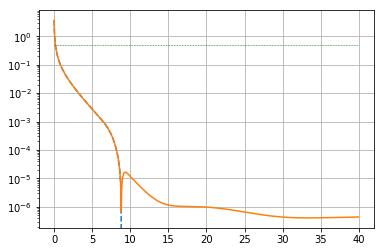

0.25093888208420795


In [10]:
print(len(rnpf[0,:]))
print(len(rnpf))
print(Nu)
print(len(urange))
plt.plot(vrange,drnpvf[0],'--')
plt.plot(vrange,np.abs(drnpvf[0]))
plt.plot([vrange[0],vrange[-1]],[.5,.5],'g--',linewidth=.5)
#plt.plot(vrange,np.abs(drnpvf[1]))
plt.yscale('log')
plt.grid()
#plt.savefig('num-rel-pics/prelim-result-3-Tol=10^-3-time=55min.png',dpi=300)
plt.show()
print(rnpf[0,0])


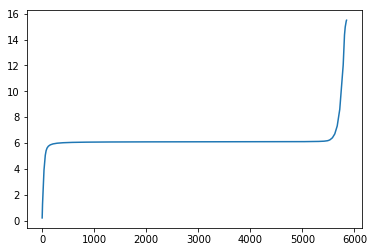

In [11]:
plt.plot(urange)
plt.show()

In [12]:
switch=0.0
np.save('rnputil',np.array([Nu*Nv,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD,switch,vbdytype]))
np.save('urange',urange)
np.save('vrange',vrange)

In [13]:
stop = timeit.default_timer()

In [14]:
acttime=stop - start

numpoints=Nu*Nv*uscal

print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

1019.6348093189881 seconds
16.993913488649802 minutes
0.2832318914774967 hours
584900000 points
573636.7517608127 points per second


conv=False
j=0
tempanswer=[]
    while conv==False:
        dv=TempTolv*dv0
        jcount=1
        while j<Nv-1:
            j1=mth.ceil(jcount*TempTolv)
            j2=mth.floor(jcount*TempTolv)
            answer=dnu.x4giveralt(0,j+mth.ceil((jcount-1)*TempTolv),du,dv*TempTolv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
            rnpf[1][j+j1]=answer[0]
            phinpf[1][j+j1]=answer[1]
            signpf[1][j+j1]=answer[2]
            massnpf[1][j+j1]=answer[3]
            #drunptemp[j+1]=answer[4]
            dsigunpv=answer[5]
            jcount=(jcount+1)**(0**j2)
            j=j+j2
        
        if np.abs(tempanswer[0]-answer[0])/answer[0]>0.01 or not tempanswer:
            tempanswer=answer
            TempTol=TempTolv/2
            
        else:
            conv=True
            